# ALUNOS: 

- Aluno1: André Noronha Salles Miranda Martins
- Aluno2: Igor felippe muzel kalomenconkovas



# CIÊNCIA DE DADOS

## Etapas previstas para realizar Análise e Tratamento de Dados:
- Importar as bibliotecas necessárias 
- Importar a base de dado e realizar o merge, caso necessário
- Tratamento dos Dados
- Visualização dos dados
- Verificar a base estatística dos dados numéricos e não numéricos
- Verificar as colunas categóricas
- Análise da base de dados
- Conclusões obtidas

## Análise de Perfil de risco de Beneficiários

O desafio consiste na **análise de perfil de risco de beneficiários com predição, analise de custo evitado e alertas de possíveis candidatos a doenças crônicas**, segundo a Portaria nº 483, de 1º de abril de 2014, as doenças crônicas são aquelas que apresentam início gradual, com duração longa ou incerta, que, em geral, apresentam múltiplas causas e cujo tratamento envolva mudanças de estilo de vida, em um processo de cuidado contínuo. Segundo a OMS as principais doenças crônicas não transmissíveis, (DCNT), um exemplo são:
- Doenças cerebrovasculares
- Doenças cardiovasculares
- Diabetes mellitus
- Doenças respiratórias crônicas (asma)
- Neoplasias (câncer)
- Obesidade
- Hipertensão

Na Unimed Ponta Grossa, temos o programa de acompanhamento linha de cuidado, em que os beneficiários identificados com as DCNT são acompanhados.

Para as análises e ETLs serão disponibilizadas informações referentes a utilização do plano de saúde por todos os beneficiários, procedimentos executados, dados do perfil de usuário, entradas em pronto atendimento e internação (em uma base separada para ser relacionada por id de pessoa). Também serão indicados os pacientes que já possuem diagnóstico de DCNT e já são acompanhados pela equipe de linha e cuidado e o tempo de acompanhamento. 

O **objetivo** é construir um modelo capaz calcular o custo evitado dos pacientes que estão no programa, identificar pacientes com maior probabilidade de desenvolver DCTNs ou que já possam estar com alguma DCNTs e não fazem parte da nossa linha de cuidado, com base em seus perfis e históricos médicos.

Resultados Esperados:
- Tratamento das informações
- Relacionamento entre o Datasets
- Identificação de padrões para cada grupo
- Alertas de possíveis pacientes com DCNTs
- Predição de possíveis casos:
- Resultado de custo Evitado (custo do paciente antes de entrar no programa e após a entrada no programa)
- Predição de custo evitado de pacientes que ainda não fazem parte do programa
Bônus: outras analises não indicadas acima
**Obs: na analise de custo evitado, levar em conta a correção monetária dos anos anteriores
 
Dados Gerais
- ID de usuário
- Data de nascimento
- Sexo
- Peso
- Número de Gestações
- Grau de dependência (Se Titular)
- Contratante
- Tipo de Plano
- Procedimentos Realizados
- Data do procedimento
- Especialidade do executante
- Especialidade do solicitante
- Paciente faz parte da linha de cuidado
- Programa que o paciente faz parte

Dados de PA e Internação (somente Beneficiários):
- ID do atendimento
- Data/hora da entrada
- Procedimento principal do atendimento
- CID
- Queixa
- Observação
- Clínica (tipo de atendimento)
- Especialidade Médico Responsável
- Classificação de Risco (Manchester)
- Data/hora da Internação
- Motivo da Alta
- Data da alta

## Importar as bibliotecas necessárias e a base de dados. Realizar o merge, caso necessário e Realizar a visualização da mesma 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Importar a base de dados
df1 = pd.read_excel("atendimento_hgu_cid.xlsx")
df2 = pd.read_excel("atendimento_hgu.xlsx")
df3 = pd.read_excel("beneficiario_custo_procedimento_plano_de_saude.xlsx", sheet_name=None, index_col=None)
df4 = pd.read_excel("beneficiarios_linha_cuidado.xlsx")
df5 = pd.read_excel("beneficiarios.xlsx")
df6 = pd.read_excel("cid_linha_cuidado.xlsx")
df7 = pd.read_excel("paciente_hgu.xlsx")
df8 = pd.read_excel("procedimento_atendimento_hgu.xlsx")
df9 = pd.read_excel("procedimento_linha_cuidado.xlsx")
df10 = pd.read_excel("procedimento.xlsx")

In [ ]:
df3 = pd.concat(df3.values(), ignore_index=True)

In [16]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36284 entries, 0 to 36283
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_item           36284 non-null  int64 
 1   ds_origem_item    36284 non-null  object
 2   cd_item           36284 non-null  int64 
 3   ds_item           36284 non-null  object
 4   ds_tipo_despesa   36284 non-null  object
 5   ds_classificacao  36284 non-null  object
 6   cd_grupo          36284 non-null  int64 
 7   ds_grupo          36284 non-null  object
dtypes: int64(3), object(5)
memory usage: 2.2+ MB


In [6]:
# conferindo colunas
for nome, df in {
    "atendimento_hgu_cid.xlsx": df1, "atendimento_hgu": df2, "beneficiario_procedimento_plano_de_saude": df3,
    "beneficiario_linha_cuidado": df4, "beneficiarios": df5, "cid_linha_cuidado": df6, "paciente_hgu": df7,
    "procedimento_atendimento_hgu": df8, "procedimento_linha_cuidado": df9, "procedimento": df10
}.items():
    print(f"\n{nome}:")
    print(df.columns.tolist())




atendimento_hgu_cid.xlsx:
['nr_atendimento', 'cd_doenca', 'dt_diagnostico', 'ds_classificacao_diagnostico', 'ds_linha_cuidado', 'id_linha_cuidado']

atendimento_hgu:
['nr_atendimento', 'cd_estabelecimento', 'id_paciente', 'dt_entrada', 'dt_alta', 'ds_especialidade_medico_responsavel', 'ds_motivo_alta', 'ds_triagem', 'ds_queixa', 'ds_tipo_atendimento', 'ds_clinica']

beneficiario_procedimento_plano_de_saude:
['id_conta', 'id_beneficiario', 'id_item', 'dt_item', 'ds_item', 'ds_especialidade_solicitante', 'ds_especialidade_executor', 'vl_item', "WITH producao AS (\n    SELECT\n        resumo.nr_seq_conta AS id_conta,\n        resumo.nr_seq_segurado AS id_beneficiario,\n        COALESCE(\n            hive.silver.obter_id_item(resumo.cd_procedimento, NULL, resumo.ie_origem_proced),\n            hive.silver.obter_id_item(NULL, resumo.nr_seq_material, '101')\n        ) AS id_item,\n        resumo.dt_item,\n        resumo.ds_item,\n        resumo.vl_liberado AS vl_item,\n        COALESCE(pres

In [ ]:
#colunas desejadas
df1u = df1[['nr_atendimento', 'cd_doenca', 'ds_classificacao_diagnostico', 'ds_linha_cuidado', 'id_linha_cuidado']]
df2u = df2[['nr_atendimento', 'id_paciente', 'dt_entrada', 'dt_alta', 'ds_especialidade_medico_responsavel', 'ds_motivo_alta', 'ds_tipo_atendimento', 'ds_clinica']]
df3u = df3[['id_beneficiario', 'ds_item', 'vl_item']]
df4u = df4[['id_beneficiario', 'id_linha_cuidado', 'ds_linha_cuidado']]
df5u = df5[['id_beneficiario', 'ds_plano', 'ds_formacao_preco', 'qt_idade', 'ds_sexo', 'ds_estado_civil']]
df6u = df6[['ds_cid', 'id_linha_cuidado']]
df7u = df7[['id_paciente', 'id_beneficiario', 'dt_nascimento', 'qt_idade', 'qt_imc', 'qt_altura_cm', 'cd_sexo', 'qt_peso']]
df8u = df8[['nr_atendimento', 'id_paciente', 'id_item', 'qt_item', 'ds_item']]
df9u = df9[['id_item', 'ds_item','ds_tipo_despesa', 'ds_grupo', 'ds_subgrupo', 'ds_linha_cuidado', 'id_linha_cuidado']]
df10u = df10[['id_item', 'ds_origem_item', 'ds_item', 'ds_tipo_despesa', 'ds_classificacao', 'cd_grupo', 'ds_grupo']]

In [58]:
#realizando o merge
cid_paciente = df2u.merge(df7u, on='id_paciente',how='right')\
                   .merge(df4u, on='id_beneficiario', how='right')\
                   .merge(df6u, on='id_linha_cuidado', how='left')\

custo_beneficiario = df5u.merge(df3u, on='id_beneficiario', how='left')

lc_beneficiario = df4u.merge(df5u, on='id_beneficiario', how='left')

cid_atendimento = df1u.merge(df2u, on='nr_atendimento', how='right')

at_hgu = df8u.merge(df2u, on='id_paciente', how='right')

lc_cid = df1u.merge(df6u, on='id_linha_cuidado', how='right')

beneficiario_hgu = df5u.merge(df7u, on='id_beneficiario', how='left')

# Resultado final
print(f"Linhas: {len(cid_paciente):,}  •  Colunas: {len(cid_paciente.columns)}")
print(f"Linhas: {len(custo_beneficiario):,}  •  Colunas: {len(custo_beneficiario.columns)}")
print(f"Linhas: {len(lc_beneficiario):,}  •  Colunas: {len(lc_beneficiario.columns)}")
print(f"Linhas: {len(cid_atendimento):,}  •  Colunas: {len(cid_atendimento.columns)}")
print(f"Linhas: {len(at_hgu):,}  •  Colunas: {len(at_hgu.columns)}")
print(f"Linhas: {len(lc_cid):,}  •  Colunas: {len(lc_cid.columns)}")
print(f"Linhas: {len(beneficiario_hgu):,}  •  Colunas: {len(beneficiario_hgu.columns)}")


Linhas: 4,070,133  •  Colunas: 18
Linhas: 5,642,599  •  Colunas: 8
Linhas: 3,430  •  Colunas: 8
Linhas: 713,602  •  Colunas: 12
Linhas: 12,450,062  •  Colunas: 12
Linhas: 892,522  •  Colunas: 6
Linhas: 112,646  •  Colunas: 13


In [9]:
# Visualizar a base de dados sobre o atendimento dos pacientes na linha de cuidado
pd.set_option('display.max_columns', None)
display(cid_paciente)

nr_atendimento  id_paciente               dt_entrada  \
0                   NaN          NaN                      NaN   
1                   NaN          NaN                      NaN   
2                   NaN          NaN                      NaN   
3                   NaN          NaN                      NaN   
4                   NaN          NaN                      NaN   
...                 ...          ...                      ...   
4070128       2454136.0    1011617.0  2024-06-22 08:18:42.000   
4070129       2590330.0    1011617.0  2024-11-07 18:00:13.000   
4070130       2595080.0    1011617.0  2024-11-13 06:24:15.000   
4070131       2597388.0    1011617.0  2024-11-14 18:46:10.000   
4070132       2597416.0    1011617.0  2024-11-14 19:36:06.000   

                         dt_alta ds_especialidade_medico_responsavel  \
0                            NaN                                 NaN   
1                            NaN                                 NaN   
2                            NaN                                 NaN   
3                            NaN                                 NaN   
4                            NaN                                 NaN   
...                          ...                                 ...   
4070128  2024-06-22 08:20:11.000                Medicina do Trabalho   
4070129  2024-11-09 01:01:01.000                      Clínica Médica   
4070130  2024-11-13 06:25:15.000    Medicina de Família e Comunidade   
4070131  2024-11-16 01:00:54.000    Medicina de Família e Comunidade   
4070132  2024-11-14 19:54:15.000    Medicina de Família e Comunidade   

        ds_motivo_alta ds_tipo_atendimento ds_clinica  id_beneficiario  \
0                  NaN                 NaN        NaN         446081.0   
1                  NaN                 NaN        NaN         446081.0   
2                  NaN                 NaN        NaN         446081.0   
3                  NaN                 NaN        NaN         446081.0   
4                  NaN                 NaN        NaN         446081.0   
...                ...                 ...        ...              ...   
4070128           Alta             Externo     Exames         468387.0   
4070129           Alta             Externo     Exames         468387.0   
4070130           Alta             Externo     Exames         468387.0   
4070131           Alta             Externo     Exames         468387.0   
4070132           Alta             Externo     Exames         468387.0   

                   dt_nascimento  qt_idade  qt_imc  qt_altura_cm cd_sexo  \
0                            NaN       NaN     NaN           NaN     NaN   
1                            NaN       NaN     NaN           NaN     NaN   
2                            NaN       NaN     NaN           NaN     NaN   
3                            NaN       NaN     NaN           NaN     NaN   
4                            NaN       NaN     NaN           NaN     NaN   
...                          ...       ...     ...           ...     ...   
4070128  1998-04-08 00:00:00.000      27.0    -1.0          -1.0       M   
4070129  1998-04-08 00:00:00.000      27.0    -1.0          -1.0       M   
4070130  1998-04-08 00:00:00.000      27.0    -1.0          -1.0       M   
4070131  1998-04-08 00:00:00.000      27.0    -1.0          -1.0       M   
4070132  1998-04-08 00:00:00.000      27.0    -1.0          -1.0       M   

         qt_peso  id_linha_cuidado      ds_linha_cuidado  \
0            NaN                 2  Hipertensão Arterial   
1            NaN                 2  Hipertensão Arterial   
2            NaN                 2  Hipertensão Arterial   
3            NaN                 2  Hipertensão Arterial   
4            NaN                 2  Hipertensão Arterial   
...          ...               ...                   ...   
4070128     -1.0                 6                Dengue   
4070129     -1.0                 6                Dengue   
4070130     -1.0     

In [10]:
# Visualizar a base de dados sobre beneficiario e tipo de linha de cuidado para o beneficiario
display(custo_beneficiario)

id_beneficiario                             ds_plano  \
0                 143274                FAMILIAR - REFERÊNCIA   
1                 143274                FAMILIAR - REFERÊNCIA   
2                 143274                FAMILIAR - REFERÊNCIA   
3                 143274                FAMILIAR - REFERÊNCIA   
4                 143274                FAMILIAR - REFERÊNCIA   
...                  ...                                  ...   
5642594           524848  INSTITUCIONAL - VISITA UNIMED PLENO   
5642595           524848  INSTITUCIONAL - VISITA UNIMED PLENO   
5642596           524848  INSTITUCIONAL - VISITA UNIMED PLENO   
5642597           524848  INSTITUCIONAL - VISITA UNIMED PLENO   
5642598           524848  INSTITUCIONAL - VISITA UNIMED PLENO   

        ds_formacao_preco  qt_idade    ds_sexo ds_estado_civil  \
0        Pré-estabelecido      54.0   Feminino        Solteiro   
1        Pré-estabelecido      54.0   Feminino        Solteiro   
2        Pré-estabelecido      54.0   Feminino        Solteiro   
3        Pré-estabelecido      54.0   Feminino        Solteiro   
4        Pré-estabelecido      54.0   Feminino        Solteiro   
...                   ...       ...        ...             ...   
5642594  Pré-estabelecido       1.0  Masculino        Solteiro   
5642595  Pré-estabelecido       1.0  Masculino        Solteiro   
5642596  Pré-estabelecido       1.0  Masculino        Solteiro   
5642597  Pré-estabelecido       1.0  Masculino        Solteiro   
5642598  Pré-estabelecido       1.0  Masculino        Solteiro   

                                                   ds_item  vl_item  
0                                   Tonometria - Binocular    23.82  
1                      Coluna Cervical Ou Dorsal Ou Lombar   797.89  
2             Procedimento Diagnóstico Em Peça Anatômica O    97.07  
3        Em Consultório (No Horário Normal Ou Preestabe...   125.00  
4        Em Consultório (No Horário Normal Ou Preestabe...   125.00  
...                                                    ...      ...  
5642594  Em Consultório (No Horário Normal Ou Preestabe...   135.00  
5642595  Em Consultório (No Horário Normal Ou Preestabe...   135.00  
5642596  Em Consultório (No Horário Normal Ou Preestabe...   135.00  
5642597  Em Consultório (No Horário Normal Ou Preestabe...   135.00  
5642598  Em Consultório (No Horário Normal Ou Preestabe...   135.00  

[5642599 rows x 8 columns]

In [11]:
# Visualizar a base de dados sobre procedimentos do beneficiário no hospital
display(lc_beneficiario)

id_beneficiario  id_linha_cuidado      ds_linha_cuidado  \
0            446081.0                 2  Hipertensão Arterial   
1            139023.0                 2  Hipertensão Arterial   
2            448901.0                 1              Diabetes   
3            492606.0                 2  Hipertensão Arterial   
4            491376.0                 2  Hipertensão Arterial   
...               ...               ...                   ...   
3425         552330.0                 4             Gestantes   
3426         568288.0                 4             Gestantes   
3427         373574.0                 6                Dengue   
3428         349073.0                 6                Dengue   
3429         468387.0                 6                Dengue   

                                               ds_plano ds_formacao_preco  \
0     COLETIVO EMPRESARIAL-PRE PAGAMENTO COM CO-PART...  Pré-estabelecido   
1                       COLETIVO EMPRESARIAL-UNIFAMILIA  Pré-estabelecido   
2             Coletivo Empresarial Municipal Enfermaria  Pré-estabelecido   
3     Coletivo Empresarial Regional Rede Propria Enf...  Pré-estabelecido   
4     Plano Estadual Unimed Coletivo Empresarial Apa...  Pré-estabelecido   
...                                                 ...               ...   
3425  Coletivo Empresarial Municipal Rede Propria En...  Pré-estabelecido   
3426     COLETIVO EMPRESARIAL NACIONAL ENFERMARIA 30-20  Pré-estabelecido   
3427                                                NaN               NaN   
3428                                                NaN               NaN   
3429    Plano Pleno Enfermaria Coletivo Empresarial OPS  Pré-estabelecido   

      qt_idade    ds_sexo            ds_estado_civil  
0         58.0   Feminino                     Casado  
1         78.0  Masculino                     Casado  
2         81.0   Feminino                     Casado  
3         48.0  Masculino                     Casado  
4         33.0   Feminino  Concubinato/União Estável  
...        ...        ...                        ...  
3425      44.0   Feminino                     Casado  
3426      28.0   Feminino                   Solteiro  
3427       NaN        NaN                        NaN  
3428       NaN        NaN                        NaN  
3429      27.0  Masculino                   Solteiro  

[3430 rows x 8 columns]

In [12]:
display(cid_atendimento)

nr_atendimento cd_doenca ds_classificacao_diagnostico  \
0              2482713       NaN                          NaN   
1              2500391       NaN                          NaN   
2              2573110       NaN                          NaN   
3              2628651       NaN                          NaN   
4              2682249       NaN                          NaN   
...                ...       ...                          ...   
713597         2655405       NaN                          NaN   
713598         2661175       NaN                          NaN   
713599         2746432       NaN                          NaN   
713600         1961209       NaN                          NaN   
713601         1967593       NaN                          NaN   

       ds_linha_cuidado  id_linha_cuidado  id_paciente  \
0                   NaN               NaN       606208   
1                   NaN               NaN       606208   
2                   NaN               NaN       668649   
3                   NaN               NaN      1108161   
4                   NaN               NaN       957888   
...                 ...               ...          ...   
713597              NaN               NaN       456525   
713598              NaN               NaN       951627   
713599              NaN               NaN      1108794   
713600              NaN               NaN       966657   
713601              NaN               NaN       968176   

                     dt_entrada                  dt_alta  \
0       2024-07-23 09:18:43.000  2024-07-25 01:00:13.000   
1       2024-08-12 07:49:50.000  2024-08-14 01:00:05.000   
2       2024-10-21 17:27:58.000  2024-10-26 07:41:02.000   
3       2024-12-19 17:11:05.000  2024-12-21 08:58:48.000   
4       2025-02-20 00:26:56.000  2025-03-06 15:56:16.000   
...                         ...                      ...   
713597  2025-01-23 14:28:29.000  2025-01-23 14:36:07.000   
713598  2025-01-29 16:27:00.000  2025-01-29 17:50:09.000   
713599  2025-04-26 08:05:35.000  2025-04-26 08:21:46.000   
713600  2023-03-07 18:56:30.000  2023-03-07 18:58:46.000   
713601  2023-03-15 16:21:00.000  2023-03-15 16:24:30.000   

       ds_especialidade_medico_responsavel  \
0                           Cirurgia Geral   
1                           Cirurgia Geral   
2                              Pneumologia   
3                                Pediatria   
4                        Oncologia Clinica   
...                                    ...   
713597           Ginecologia e Obstetrícia   
713598                      Cirurgia Geral   
713599                       Clínica Geral   
713600                      Clínica Médica   
713601                      Clínica Médica   

                                           ds_motivo_alta ds_tipo_atendimento  \
0                                                    Alta           Internado   
1                                                    Alta           Internado   
2       Óbito com declaração de Óbito fornecida - Serv...           Internado   
3                                          Alta melhorado           Internado   
4                                          Alta melhorado           Internado   
...                                                   ...                 ...   
713597                                               Alta      Estadia mínima   
713598                                               Alta      Estadia mínima   
713599                                               Alta      Estadia mínima   
713600                                               Alta          Telessaúde   
713601                                               Alta          Telessaúde   

                       ds_clinica  
0                          Médica  
1                          Médica  
2                          Médica  
3                          Médica  
4                          Médica  
...                           ...  
713597  Aplicação De Medicament

In [13]:
display(at_hgu)

nr_atendimento_x  id_paciente       id_item  qt_item  \
0                1921672.0       606208  6.900541e+12      1.0   
1                2328698.0       606208  6.900541e+12      1.0   
2                1921672.0       606208  6.900541e+12      1.0   
3                2328698.0       606208  6.900541e+12      1.0   
4                2573110.0       668649  6.900541e+12      1.0   
...                    ...          ...           ...      ...   
12450057         2121276.0       951627  6.900510e+12      1.0   
12450058         2121276.0       951627  6.900510e+12      1.0   
12450059               NaN      1108794           NaN      NaN   
12450060               NaN       966657           NaN      NaN   
12450061               NaN       968176           NaN      NaN   

                                                    ds_item  nr_atendimento_y  \
0                         Mamografia convencional bilateral           2482713   
1                         Mamografia convencional bilateral           2482713   
2                         Mamografia convencional bilateral           2500391   
3                         Mamografia convencional bilateral           2500391   
4         Doppler colorido venoso de membro superior - u...           2573110   
...                                                     ...               ...   
12450057           Atendimento Ao Recém-Nascido Em Berçário           2661175   
12450058  Atendimento Ao Recém-Nascido Em Sala De Parto ...           2661175   
12450059                                                NaN           2746432   
12450060                                                NaN           1961209   
12450061                                                NaN           1967593   

                       dt_entrada                  dt_alta  \
0         2024-07-23 09:18:43.000  2024-07-25 01:00:13.000   
1         2024-07-23 09:18:43.000  2024-07-25 01:00:13.000   
2         2024-08-12 07:49:50.000  2024-08-14 01:00:05.000   
3         2024-08-12 07:49:50.000  2024-08-14 01:00:05.000   
4         2024-10-21 17:27:58.000  2024-10-26 07:41:02.000   
...                           ...                      ...   
12450057  2025-01-29 16:27:00.000  2025-01-29 17:50:09.000   
12450058  2025-01-29 16:27:00.000  2025-01-29 17:50:09.000   
12450059  2025-04-26 08:05:35.000  2025-04-26 08:21:46.000   
12450060  2023-03-07 18:56:30.000  2023-03-07 18:58:46.000   
12450061  2023-03-15 16:21:00.000  2023-03-15 16:24:30.000   

         ds_especialidade_medico_responsavel  \
0                             Cirurgia Geral   
1                             Cirurgia Geral   
2                             Cirurgia Geral   
3                             Cirurgia Geral   
4                                Pneumologia   
...                                      ...   
12450057                      Cirurgia Geral   
12450058                      Cirurgia Geral   
12450059                       Clínica Geral   
12450060                      Clínica Médica   
12450061                      Clínica Médica   

                                             ds_motivo_alta  \
0                                                      Alta   
1                                                      Alta   
2                                                      Alta   
3                                                      Alta   
4         Óbito com declaração de Óbito fornecida - Serv...   
...                                                     ...   
12450057                                               Alta   
12450058                                               Alta   
12450059                                               Alta   
12450060                                               Alta   
12450061                                               Alta   

         ds_tipo_atendimento                 ds_clinica  
0                  Internado                     Médica  
1                  Internado                     

In [14]:
display(lc_cid)

nr_atendimento cd_doenca ds_classificacao_diagnostico  \
0              2722543       E10                    Principal   
1              2710657       E10                    Principal   
2              2717333       E10                    Principal   
3              2732759       E10                    Principal   
4              2721112       E10                    Principal   
...                ...       ...                          ...   
892517         1919971      Z359                    Principal   
892518         1924862      Z359                    Principal   
892519         1920306      Z359                    Principal   
892520         1925826      Z359                    Principal   
892521         1925815      Z359                    Principal   

       ds_linha_cuidado  id_linha_cuidado  \
0              Diabetes                 1   
1              Diabetes                 1   
2              Diabetes                 1   
3              Diabetes                 1   
4              Diabetes                 1   
...                 ...               ...   
892517        Gestantes                 4   
892518        Gestantes                 4   
892519        Gestantes                 4   
892520        Gestantes                 4   
892521        Gestantes                 4   

                                                ds_cid  
0       Diabetes mellitus insulino-dependente - C/coma  
1       Diabetes mellitus insulino-dependente - C/coma  
2       Diabetes mellitus insulino-dependente - C/coma  
3       Diabetes mellitus insulino-dependente - C/coma  
4       Diabetes mellitus insulino-dependente - C/coma  
...                                                ...  
892517           Obstétrica 1º Trimestre (Endovaginal)  
892518           Obstétrica 1º Trimestre (Endovaginal)  
892519           Obstétrica 1º Trimestre (Endovaginal)  
892520           Obstétrica 1º Trimestre (Endovaginal)  
892521           Obstétrica 1º Trimestre (Endovaginal)  

[892522 rows x 6 columns]

In [15]:
display(beneficiario_hgu)

id_beneficiario                                   ds_plano  \
0                143274                      FAMILIAR - REFERÊNCIA   
1                138347                      FAMILIAR - REFERÊNCIA   
2                140363                      FAMILIAR - REFERÊNCIA   
3                143358                      FAMILIAR - REFERÊNCIA   
4                168425                      FAMILIAR - REFERÊNCIA   
...                 ...                                        ...   
112641           177610  Coletivo Empresarial Regional Apartamento   
112642           177556  Coletivo Empresarial Regional Apartamento   
112643           177928  Coletivo Empresarial Regional Apartamento   
112644           440829                INSTITUCIONAL - VISITAS NDH   
112645           524848        INSTITUCIONAL - VISITA UNIMED PLENO   

       ds_formacao_preco  qt_idade_x    ds_sexo ds_estado_civil  id_paciente  \
0       Pré-estabelecido        54.0   Feminino        Solteiro     666333.0   
1       Pré-estabelecido        57.0   Feminino          Casado     664331.0   
2       Pré-estabelecido        61.0   Feminino          Casado     664854.0   
3       Pré-estabelecido        47.0   Feminino          Casado     666357.0   
4       Pré-estabelecido        13.0  Masculino        Solteiro     667179.0   
...                  ...         ...        ...             ...          ...   
112641  Pré-estabelecido        33.0  Masculino          Casado     779531.0   
112642  Pré-estabelecido        55.0   Feminino          Casado     779493.0   
112643  Pré-estabelecido        48.0  Masculino          Casado     779616.0   
112644  Pré-estabelecido         NaN  Masculino        Solteiro          NaN   
112645  Pré-estabelecido         1.0  Masculino        Solteiro          NaN   

                  dt_nascimento  qt_idade_y  qt_imc  qt_altura_cm cd_sexo  \
0       1970-10-15 00:00:00.000        54.0    23.9         165.0       F   
1       1967-09-18 00:00:00.000        57.0    27.6         165.0       F   
2       1963-12-25 00:00:00.000        61.0    -1.0          -1.0       F   
3       1978-05-02 00:00:00.000        47.0    24.2         170.0       F   
4       2012-01-11 00:00:00.000        13.0    27.8         153.0       M   
...                         ...         ...     ...           ...     ...   
112641  1991-10-02 00:00:00.000        33.0    25.5         168.0       M   
112642  1970-02-18 00:00:00.000        55.0    37.9         164.0       F   
112643  1976-09-27 00:00:00.000        48.0    -1.0          -1.0       M   
112644                      NaN         NaN     NaN           NaN     NaN   
112645                      NaN         NaN     NaN           NaN     NaN   

        qt_peso  
0          65.0  
1          75.0  
2          -1.0  
3          70.0  
4          65.0  
...         ...  
112641     72.0  
112642     93.3  
112643     -1.0  
112644      NaN  
112645      NaN  

[112646 rows x 13 columns]

In [16]:
# Procedimentos que indicam que uma mulher é gestante.
display(df9u)

id_item                                       ds_item  \
0  6900840901270       Obstétrica Gestação Múltipla: Cada Feto   
1  6900840901246  Obstétrica Convencional Com Doppler Colorido   
2  6900840901262                        Obstétrica Morfológica   
3  6900840901297         Obstétrica 1º Trimestre (Endovaginal)   
4  6900840901238                                    Obstétrica   
5  6900840901254            Obstétrica Com Translucência Nucal   

            ds_tipo_despesa          ds_grupo              ds_subgrupo  \
0  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   
1  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   
2  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   
3  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   
4  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   
5  Procedimentos e Serviços  Ultra-Sonografia  Ultra-Sonografia Diagnó   

  ds_linha_cuidado  id_linha_cuidado  
0        Gestantes                 4  
1        Gestantes                 4  
2        Gestantes                 4  
3        Gestantes                 4  
4        Gestantes                 4  
5        Gestantes                 4

In [17]:
# Procedimentos fora do hospital
display(df10u)

id_item ds_origem_item  \
0       6900440305872        PROPRIO   
1       6900427040020        PROPRIO   
2           690042415        PROPRIO   
3             6900411        PROPRIO   
4         69004184825        PROPRIO   
...               ...            ...   
36279  69007504010034       SUS_2008   
36280  69007101050097       SUS_2008   
36281  69007309050146       SUS_2008   
36282  69007702010200       SUS_2008   
36283  69007604350023       SUS_2008   

                                                 ds_item  \
0               5-hidroxi-n-metil-2-pirrolidona Na Urina   
1      Antigeno Australia Hbsag Por Componente Hemote...   
2                       Atendimento De Assistente Social   
3                        Avaliação / Sessão Fisioterapia   
4             Avaliação / Visita - Terapeuta Ocupacional   
...                                                  ...   
36279    Separacao E Avaliacao Biomicroscopica Da Cornea   
36280            Sessao De Antroposofia Aplicada A Saude   
36281                               Sessao De Geoterapia   
36282                              Shunt Lombo-peritonal   
36283                 Sildenafila 25 Mg (por Comprimido)   

                ds_tipo_despesa ds_classificacao  cd_grupo     ds_grupo  
0      Procedimentos e Serviços    Procedimentos        10     Próprios  
1      Procedimentos e Serviços    Procedimentos        10     Próprios  
2      Procedimentos e Serviços    Procedimentos        10     Próprios  
3      Procedimentos e Serviços    Procedimentos        10     Próprios  
4      Procedimentos e Serviços    Procedimentos        10     Próprios  
...                         ...              ...       ...          ...  
36279  Procedimentos e Serviços    Procedimentos       151  SUS - TUNEP  
36280  Procedimentos e Serviços    Procedimentos       151  SUS - TUNEP  
36281  Procedimentos e Serviços    Procedimentos       151  SUS - TUNEP  
36282  Procedimentos e Serviços    Procedimentos       151  SUS - TUNEP  
36283  Procedimentos e Serviços    Procedimentos       151  SUS - TUNEP  

[36284 rows x 7 columns]

## Tratamento dos dados: verificar e corrigir o domínios dos campos, se há dados faltantes, verificar cardinalidade, identificar colunas categóricas, de visualizar as informações estatísticas da base (dados numéricos e não numéricos)

### Resumo das bases


In [18]:
#Visualizar o domínio das variáveis do at_paciente
cid_paciente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4070133 entries, 0 to 4070132
Data columns (total 18 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   nr_atendimento                       float64
 1   id_paciente                          float64
 2   dt_entrada                           object 
 3   dt_alta                              object 
 4   ds_especialidade_medico_responsavel  object 
 5   ds_motivo_alta                       object 
 6   ds_tipo_atendimento                  object 
 7   ds_clinica                           object 
 8   id_beneficiario                      float64
 9   dt_nascimento                        object 
 10  qt_idade                             float64
 11  qt_imc                               float64
 12  qt_altura_cm                         float64
 13  cd_sexo                              object 
 14  qt_peso                              float64
 15  id_linha_cuidado                

In [19]:
#Visualizar o domínio das variáveis do beneficiário
custo_beneficiario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5642599 entries, 0 to 5642598
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_beneficiario    int64  
 1   ds_plano           object 
 2   ds_formacao_preco  object 
 3   qt_idade           float64
 4   ds_sexo            object 
 5   ds_estado_civil    object 
 6   ds_item            object 
 7   vl_item            float64
dtypes: float64(2), int64(1), object(5)
memory usage: 344.4+ MB


In [20]:
#Visualizar o domínio das variáveis do lc_paciente
lc_beneficiario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3430 entries, 0 to 3429
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_beneficiario    3426 non-null   float64
 1   id_linha_cuidado   3430 non-null   int64  
 2   ds_linha_cuidado   3430 non-null   object 
 3   ds_plano           2922 non-null   object 
 4   ds_formacao_preco  2922 non-null   object 
 5   qt_idade           2922 non-null   float64
 6   ds_sexo            2922 non-null   object 
 7   ds_estado_civil    2922 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 214.5+ KB


In [21]:
cid_atendimento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713602 entries, 0 to 713601
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   nr_atendimento                       713602 non-null  int64  
 1   cd_doenca                            11028 non-null   object 
 2   ds_classificacao_diagnostico         11028 non-null   object 
 3   ds_linha_cuidado                     11028 non-null   object 
 4   id_linha_cuidado                     11028 non-null   float64
 5   id_paciente                          713602 non-null  int64  
 6   dt_entrada                           713602 non-null  object 
 7   dt_alta                              713602 non-null  object 
 8   ds_especialidade_medico_responsavel  699169 non-null  object 
 9   ds_motivo_alta                       713602 non-null  object 
 10  ds_tipo_atendimento                  713602 non-null  object 
 11  ds_clinica   

In [22]:
at_hgu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12450062 entries, 0 to 12450061
Data columns (total 12 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   nr_atendimento_x                     float64
 1   id_paciente                          int64  
 2   id_item                              float64
 3   qt_item                              float64
 4   ds_item                              object 
 5   nr_atendimento_y                     int64  
 6   dt_entrada                           object 
 7   dt_alta                              object 
 8   ds_especialidade_medico_responsavel  object 
 9   ds_motivo_alta                       object 
 10  ds_tipo_atendimento                  object 
 11  ds_clinica                           object 
dtypes: float64(3), int64(2), object(7)
memory usage: 1.1+ GB


In [23]:
lc_cid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892522 entries, 0 to 892521
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   nr_atendimento                892522 non-null  int64 
 1   cd_doenca                     892522 non-null  object
 2   ds_classificacao_diagnostico  892522 non-null  object
 3   ds_linha_cuidado              892522 non-null  object
 4   id_linha_cuidado              892522 non-null  int64 
 5   ds_cid                        892522 non-null  object
dtypes: int64(2), object(4)
memory usage: 40.9+ MB


In [24]:
beneficiario_hgu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112646 entries, 0 to 112645
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id_beneficiario    112646 non-null  int64  
 1   ds_plano           112646 non-null  object 
 2   ds_formacao_preco  112646 non-null  object 
 3   qt_idade_x         112633 non-null  float64
 4   ds_sexo            112631 non-null  object 
 5   ds_estado_civil    112612 non-null  object 
 6   id_paciente        74376 non-null   float64
 7   dt_nascimento      74376 non-null   object 
 8   qt_idade_y         74376 non-null   float64
 9   qt_imc             74376 non-null   float64
 10  qt_altura_cm       74376 non-null   float64
 11  cd_sexo            74376 non-null   object 
 12  qt_peso            74376 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 11.2+ MB


In [25]:
#Visualizar o domínio das variáveis do procedimento_linha_cuidado
df9u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_item           6 non-null      int64 
 1   ds_item           6 non-null      object
 2   ds_tipo_despesa   6 non-null      object
 3   ds_grupo          6 non-null      object
 4   ds_subgrupo       6 non-null      object
 5   ds_linha_cuidado  6 non-null      object
 6   id_linha_cuidado  6 non-null      int64 
dtypes: int64(2), object(5)
memory usage: 468.0+ bytes


In [26]:
# Visualizar o domínio das variáveis do procedimento
df10u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36284 entries, 0 to 36283
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_item           36284 non-null  int64 
 1   ds_origem_item    36284 non-null  object
 2   ds_item           36284 non-null  object
 3   ds_tipo_despesa   36284 non-null  object
 4   ds_classificacao  36284 non-null  object
 5   cd_grupo          36284 non-null  int64 
 6   ds_grupo          36284 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.9+ MB


### Domínios incorretos, caso existam

In [59]:
# cid_paciente

# Datas
cid_paciente['dt_entrada'] = pd.to_datetime(cid_paciente['dt_entrada'], errors='coerce')
cid_paciente['dt_alta'] = pd.to_datetime(cid_paciente['dt_alta'], errors='coerce')
cid_paciente['dt_nascimento'] = pd.to_datetime(cid_paciente['dt_nascimento'], errors='coerce')

# Float para int
cid_paciente['qt_idade'] = cid_paciente['qt_idade'].astype('Int64')

In [60]:
# custo_beneficiario

# Float para int
custo_beneficiario['qt_idade'] = custo_beneficiario['qt_idade'].astype('Int64')

In [61]:
# lc_beneficiario

# Float para int
lc_beneficiario['qt_idade'] = lc_beneficiario['qt_idade'].astype('Int64')

In [62]:
#cid_atendimento

#Datas
cid_atendimento['dt_entrada'] = pd.to_datetime(cid_atendimento['dt_entrada'], errors='coerce')
cid_atendimento['dt_alta'] = pd.to_datetime(cid_atendimento['dt_alta'], errors='coerce')

In [8]:
#at_hgu

#Datas
at_hgu['dt_entrada'] = pd.to_datetime(at_hgu['dt_entrada'], errors='coerce')
at_hgu['dt_alta'] = pd.to_datetime(at_hgu['dt_alta'], errors='coerce')

In [64]:
#lc_cid

# Sem alteração

In [65]:
#beneficiario_hgu

#Datas
beneficiario_hgu['dt_nascimento'] = pd.to_datetime(beneficiario_hgu['dt_nascimento'], errors='coerce')

# Float para int
beneficiario_hgu['qt_idade_x'] = beneficiario_hgu['qt_idade_x'].astype('Int64')

In [66]:
# procedimento_linha_cuidado

# Sem alteração	

In [67]:
# procedimento

# Sem alteração

### Tratamento dos valores nulos, caso existam


In [68]:
cid_paciente.isnull().sum()

nr_atendimento                          87284
id_paciente                             81856
dt_entrada                              87284
dt_alta                                 87284
ds_especialidade_medico_responsavel    263734
ds_motivo_alta                          87284
ds_tipo_atendimento                     87284
ds_clinica                              87709
id_beneficiario                           202
dt_nascimento                           81856
qt_idade                                81856
qt_imc                                  81856
qt_altura_cm                            81856
cd_sexo                                 81856
qt_peso                                 81856
id_linha_cuidado                            0
ds_linha_cuidado                            0
ds_cid                                   6363
dtype: int64

In [69]:
cid_paciente = cid_paciente.dropna(how='any', axis=0)

In [70]:
custo_beneficiario.isnull().sum()

id_beneficiario          0
ds_plano                 0
ds_formacao_preco        0
qt_idade               131
ds_sexo                 52
ds_estado_civil        828
ds_item              29611
vl_item              29611
dtype: int64

In [71]:
custo_beneficiario = custo_beneficiario.dropna(how='any', axis=0)

In [72]:
cid_atendimento.isnull().sum()

nr_atendimento                              0
cd_doenca                              702574
ds_classificacao_diagnostico           702574
ds_linha_cuidado                       702574
id_linha_cuidado                       702574
id_paciente                                 0
dt_entrada                                  0
dt_alta                                     0
ds_especialidade_medico_responsavel     14433
ds_motivo_alta                              0
ds_tipo_atendimento                         0
ds_clinica                                382
dtype: int64

In [73]:
cid_atendimento = cid_atendimento.dropna(how='any', axis=0)

In [9]:
at_hgu.isnull().sum()

nr_atendimento_x                        76461
id_paciente                                 0
id_item                                 76461
qt_item                                 76461
ds_item                                 76461
nr_atendimento_y                            0
dt_entrada                                  0
dt_alta                                     0
ds_especialidade_medico_responsavel    228057
ds_motivo_alta                              0
ds_tipo_atendimento                         0
ds_clinica                              21771
dtype: int64

In [10]:
at_hgu = at_hgu.dropna(how='any', axis=0)

In [76]:
beneficiario_hgu.isnull().sum()

id_beneficiario          0
ds_plano                 0
ds_formacao_preco        0
qt_idade_x              13
ds_sexo                 15
ds_estado_civil         34
id_paciente          38270
dt_nascimento        38270
qt_idade_y           38270
qt_imc               38270
qt_altura_cm         38270
cd_sexo              38270
qt_peso              38270
dtype: int64

In [77]:
beneficiario_hgu = beneficiario_hgu.dropna(how='any', axis=0)

### Cardinalidade dos dados

In [46]:
# cid_paciente

for col in cid_paciente.columns:
    print(f"{col}: {cid_paciente[col].nunique()} valores diferentes")

nr_atendimento: 23519 valores diferentes
id_paciente: 2030 valores diferentes
dt_entrada: 23506 valores diferentes
dt_alta: 23492 valores diferentes
ds_especialidade_medico_responsavel: 56 valores diferentes
ds_motivo_alta: 7 valores diferentes
ds_tipo_atendimento: 6 valores diferentes
ds_clinica: 21 valores diferentes
id_beneficiario: 2030 valores diferentes
dt_nascimento: 1873 valores diferentes
qt_idade: 79 valores diferentes
qt_imc: 355 valores diferentes
qt_altura_cm: 67 valores diferentes
cd_sexo: 2 valores diferentes
qt_peso: 211 valores diferentes
id_linha_cuidado: 3 valores diferentes
ds_linha_cuidado: 3 valores diferentes
ds_cid: 276 valores diferentes


In [47]:
# custo_beneficiario

for col in custo_beneficiario.columns:
    print(f"{col}: {custo_beneficiario[col].nunique()} valores diferentes")

id_beneficiario: 82994 valores diferentes
ds_plano: 121 valores diferentes
ds_formacao_preco: 2 valores diferentes
qt_idade: 105 valores diferentes
ds_sexo: 2 valores diferentes
ds_estado_civil: 8 valores diferentes
ds_item: 3070 valores diferentes
vl_item: 12410 valores diferentes


In [48]:
# lc_beneficiario

for col in lc_beneficiario.columns:
    print(f"{col}: {lc_beneficiario[col].nunique()} valores diferentes")

id_beneficiario: 3419 valores diferentes
id_linha_cuidado: 5 valores diferentes
ds_linha_cuidado: 5 valores diferentes
ds_plano: 62 valores diferentes
ds_formacao_preco: 2 valores diferentes
qt_idade: 93 valores diferentes
ds_sexo: 2 valores diferentes
ds_estado_civil: 8 valores diferentes


In [49]:
# cid_atendimento

for col in cid_atendimento.columns:
    print(f"{col}: {cid_atendimento[col].nunique()} valores diferentes")

nr_atendimento: 10310 valores diferentes
cd_doenca: 140 valores diferentes
ds_classificacao_diagnostico: 2 valores diferentes
ds_linha_cuidado: 4 valores diferentes
id_linha_cuidado: 4 valores diferentes
id_paciente: 6990 valores diferentes
dt_entrada: 10310 valores diferentes
dt_alta: 10309 valores diferentes
ds_especialidade_medico_responsavel: 32 valores diferentes
ds_motivo_alta: 10 valores diferentes
ds_tipo_atendimento: 5 valores diferentes
ds_clinica: 14 valores diferentes


In [50]:
# at_hgu

for col in at_hgu.columns:
    print(f"{col}: {at_hgu[col].nunique()} valores diferentes")

nr_atendimento_x: 373342 valores diferentes
id_paciente: 107377 valores diferentes
id_item: 1910 valores diferentes
qt_item: 39 valores diferentes
ds_item: 1863 valores diferentes
nr_atendimento_y: 626760 valores diferentes
dt_entrada: 619463 valores diferentes
dt_alta: 618763 valores diferentes
ds_especialidade_medico_responsavel: 85 valores diferentes
ds_motivo_alta: 15 valores diferentes
ds_tipo_atendimento: 7 valores diferentes
ds_clinica: 26 valores diferentes


In [51]:
# lc_cid

for col in lc_cid.columns:
    print(f"{col}: {lc_cid[col].nunique()} valores diferentes")

nr_atendimento: 10320 valores diferentes
cd_doenca: 141 valores diferentes
ds_classificacao_diagnostico: 2 valores diferentes
ds_linha_cuidado: 4 valores diferentes
id_linha_cuidado: 4 valores diferentes
ds_cid: 278 valores diferentes


In [52]:
# beneficiario_hgu

for col in beneficiario_hgu.columns:
    print(f"{col}: {beneficiario_hgu[col].nunique()} valores diferentes")

id_beneficiario: 74360 valores diferentes
ds_plano: 117 valores diferentes
ds_formacao_preco: 2 valores diferentes
qt_idade_x: 104 valores diferentes
ds_sexo: 2 valores diferentes
ds_estado_civil: 8 valores diferentes
id_paciente: 74360 valores diferentes
dt_nascimento: 25484 valores diferentes
qt_idade_y: 104 valores diferentes
qt_imc: 2312 valores diferentes
qt_altura_cm: 339 valores diferentes
cd_sexo: 2 valores diferentes
qt_peso: 2131 valores diferentes


In [53]:
# procedimento_linha_cuidado

for col in df9u.columns:
    print(f"{col}: {df9u[col].nunique()} valores diferentes")

id_item: 6 valores diferentes
ds_item: 6 valores diferentes
ds_tipo_despesa: 1 valores diferentes
ds_grupo: 1 valores diferentes
ds_subgrupo: 1 valores diferentes
ds_linha_cuidado: 1 valores diferentes
id_linha_cuidado: 1 valores diferentes


In [54]:
# procedimento

for col in df10u.columns:
    print(f"{col}: {df10u[col].nunique()} valores diferentes")

id_item: 36284 valores diferentes
ds_origem_item: 7 valores diferentes
ds_item: 29027 valores diferentes
ds_tipo_despesa: 1 valores diferentes
ds_classificacao: 4 valores diferentes
cd_grupo: 145 valores diferentes
ds_grupo: 113 valores diferentes


### Tratamento dos valores duplicados, caso existam

In [78]:
cid_paciente = cid_paciente.drop_duplicates()

cid_paciente.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3799794 entries, 16 to 4069902
Data columns (total 18 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   nr_atendimento                       float64       
 1   id_paciente                          float64       
 2   dt_entrada                           datetime64[ns]
 3   dt_alta                              datetime64[ns]
 4   ds_especialidade_medico_responsavel  object        
 5   ds_motivo_alta                       object        
 6   ds_tipo_atendimento                  object        
 7   ds_clinica                           object        
 8   id_beneficiario                      float64       
 9   dt_nascimento                        datetime64[ns]
 10  qt_idade                             Int64         
 11  qt_imc                               float64       
 12  qt_altura_cm                         float64       
 13  cd_sexo                        

In [79]:
custo_beneficiario = custo_beneficiario.drop_duplicates()

custo_beneficiario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3061434 entries, 0 to 5642594
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_beneficiario    int64  
 1   ds_plano           object 
 2   ds_formacao_preco  object 
 3   qt_idade           Int64  
 4   ds_sexo            object 
 5   ds_estado_civil    object 
 6   ds_item            object 
 7   vl_item            float64
dtypes: Int64(1), float64(1), int64(1), object(5)
memory usage: 213.1+ MB


In [80]:
lc_beneficiario = lc_beneficiario.drop_duplicates()

lc_beneficiario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3428 entries, 0 to 3429
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_beneficiario    3426 non-null   float64
 1   id_linha_cuidado   3428 non-null   int64  
 2   ds_linha_cuidado   3428 non-null   object 
 3   ds_plano           2922 non-null   object 
 4   ds_formacao_preco  2922 non-null   object 
 5   qt_idade           2922 non-null   Int64  
 6   ds_sexo            2922 non-null   object 
 7   ds_estado_civil    2922 non-null   object 
dtypes: Int64(1), float64(1), int64(1), object(5)
memory usage: 244.4+ KB


In [81]:
cid_atendimento = cid_atendimento.drop_duplicates()

cid_atendimento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 137 to 713570
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   nr_atendimento                       10462 non-null  int64         
 1   cd_doenca                            10462 non-null  object        
 2   ds_classificacao_diagnostico         10462 non-null  object        
 3   ds_linha_cuidado                     10462 non-null  object        
 4   id_linha_cuidado                     10462 non-null  float64       
 5   id_paciente                          10462 non-null  int64         
 6   dt_entrada                           10462 non-null  datetime64[ns]
 7   dt_alta                              10462 non-null  datetime64[ns]
 8   ds_especialidade_medico_responsavel  10462 non-null  object        
 9   ds_motivo_alta                       10462 non-null  object        
 10  ds_tipo_aten

In [11]:
at_hgu = at_hgu.drop_duplicates()

at_hgu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9808669 entries, 0 to 12450058
Data columns (total 12 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   nr_atendimento_x                     float64       
 1   id_paciente                          int64         
 2   id_item                              float64       
 3   qt_item                              float64       
 4   ds_item                              object        
 5   nr_atendimento_y                     int64         
 6   dt_entrada                           datetime64[ns]
 7   dt_alta                              datetime64[ns]
 8   ds_especialidade_medico_responsavel  object        
 9   ds_motivo_alta                       object        
 10  ds_tipo_atendimento                  object        
 11  ds_clinica                           object        
dtypes: datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 972.8+ MB


In [83]:
lc_cid = lc_cid.drop_duplicates()

lc_cid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 883304 entries, 0 to 892521
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   nr_atendimento                883304 non-null  int64 
 1   cd_doenca                     883304 non-null  object
 2   ds_classificacao_diagnostico  883304 non-null  object
 3   ds_linha_cuidado              883304 non-null  object
 4   id_linha_cuidado              883304 non-null  int64 
 5   ds_cid                        883304 non-null  object
dtypes: int64(2), object(4)
memory usage: 47.2+ MB


In [84]:
beneficiario_hgu = beneficiario_hgu.drop_duplicates()

beneficiario_hgu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74360 entries, 0 to 112643
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_beneficiario    74360 non-null  int64         
 1   ds_plano           74360 non-null  object        
 2   ds_formacao_preco  74360 non-null  object        
 3   qt_idade_x         74360 non-null  Int64         
 4   ds_sexo            74360 non-null  object        
 5   ds_estado_civil    74360 non-null  object        
 6   id_paciente        74360 non-null  float64       
 7   dt_nascimento      74360 non-null  datetime64[ns]
 8   qt_idade_y         74360 non-null  float64       
 9   qt_imc             74360 non-null  float64       
 10  qt_altura_cm       74360 non-null  float64       
 11  cd_sexo            74360 non-null  object        
 12  qt_peso            74360 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(5), int64(1), object(5)
m

### Excluir linhas e colunas desnecessárias

In [85]:
cid_paciente['id_beneficiario'] = cid_paciente['id_beneficiario'].astype('Int64')

In [86]:
#lista das colunas para remoção de cid_paciente
colunas_para_remover = [
    'id_linha_cuidado',
    'nr_atendimento',           
    'id_paciente', 
    'dt_nascimento',
]

#filtros para remoção de linhas
limite_imc_inferior = 10
limite_imc_superior = 50
limite_altura_inferior = 80
limite_altura_superior = 251
limite_peso_inferior = 2

cid_paciente = cid_paciente[(cid_paciente['qt_imc'] >= limite_imc_inferior)
                          & (cid_paciente['qt_imc'] <= limite_imc_superior)]

cid_paciente = cid_paciente[(cid_paciente['qt_altura_cm'] >= limite_altura_inferior)
                          & (cid_paciente['qt_altura_cm'] <= limite_altura_superior)]

cid_paciente = cid_paciente[(cid_paciente['qt_peso'] >= limite_peso_inferior)]

cid_paciente = cid_paciente.drop(columns=colunas_para_remover, errors='ignore')
display(cid_paciente)

dt_entrada             dt_alta  \
16      2023-07-03 08:59:17 2023-07-06 14:11:11   
17      2023-07-03 08:59:17 2023-07-06 14:11:11   
18      2023-07-03 08:59:17 2023-07-06 14:11:11   
19      2023-07-03 08:59:17 2023-07-06 14:11:11   
20      2023-07-03 08:59:17 2023-07-06 14:11:11   
...                     ...                 ...   
4067277 2025-04-09 07:17:59 2025-04-09 07:19:28   
4067278 2025-04-09 07:17:59 2025-04-09 07:19:28   
4067279 2025-04-09 07:17:59 2025-04-09 07:19:28   
4067280 2025-04-09 07:17:59 2025-04-09 07:19:28   
4067281 2025-04-09 07:17:59 2025-04-09 07:19:28   

        ds_especialidade_medico_responsavel ds_motivo_alta  \
16                                 Urologia           Alta   
17                                 Urologia           Alta   
18                                 Urologia           Alta   
19                                 Urologia           Alta   
20                                 Urologia           Alta   
...                                     ...            ...   
4067277           Ginecologia e Obstetrícia           Alta   
4067278           Ginecologia e Obstetrícia           Alta   
4067279           Ginecologia e Obstetrícia           Alta   
4067280           Ginecologia e Obstetrícia           Alta   
4067281           Ginecologia e Obstetrícia           Alta   

        ds_tipo_atendimento ds_clinica  id_beneficiario  qt_idade  qt_imc  \
16                Internado  Cirurgica           139023        78    24.2   
17                Internado  Cirurgica           139023        78    24.2   
18                Internado  Cirurgica           139023        78    24.2   
19                Internado  Cirurgica           139023        78    24.2   
20                Internado  Cirurgica           139023        78    24.2   
...                     ...        ...              ...       ...     ...   
4067277             Externo     Exames           526386        31    31.3   
4067278             Externo     Exames           526386        31    31.3   
4067279             Externo     Exames           526386        31    31.3   
4067280             Externo     Exames           526386        31    31.3   
4067281             Externo     Exames           526386        31    31.3   

         qt_altura_cm cd_sexo  qt_peso      ds_linha_cuidado  \
16              175.0       M     74.0  Hipertensão Arterial   
17              175.0       M     74.0  Hipertensão Arterial   
18              175.0       M     74.0  Hipertensão Arterial   
19              175.0       M     74.0  Hipertensão Arterial   
20              175.0       M     74.0  Hipertensão Arterial   
...               ...     ...      ...                   ...   
4067277         159.0       F     79.0             Gestantes   
4067278         159.0       F     79.0             Gestantes   
4067279         159.0       F     79.0             Gestantes   
4067280         159.0       F     79.0             Gestantes   
4067281         159.0       F     79.0             Gestantes   

                                                    ds_cid  
16       Doenc cardiaca hipertensiva - Doenc cardiaca h...  
17                                Doenc renal hipertensiva  
18       Doenc renal hipertensiva - Doenc renal hiperte...  
19       Doenc renal hipertensiva - Doenc renal hiperte...  
20                     Doenc cardiaca e renal hipertensiva  
...                                                    ...  
4067277       Obstétrica Convencional Com Doppler Colorido  
4067278                 Obstétrica Com Translucência Nucal  
4067279                             Obstétrica Morfológica  
4067280            Obstétrica Gestação Múltipla: Cada Feto  
4067281              Obstétrica 1º Trimestre (Endovaginal)  

[2900930 rows x 14 columns]

In [87]:
#lista das colunas para remoção de custo_beneficiario
colunas_para_remover = [
    'id_beneficiario',
    'ds_formacao_preco'
]

custo_beneficiario = custo_beneficiario.drop(columns=colunas_para_remover, errors='ignore')
display(custo_beneficiario)

ds_plano  qt_idade    ds_sexo  \
0                            FAMILIAR - REFERÊNCIA        54   Feminino   
1                            FAMILIAR - REFERÊNCIA        54   Feminino   
2                            FAMILIAR - REFERÊNCIA        54   Feminino   
3                            FAMILIAR - REFERÊNCIA        54   Feminino   
5                            FAMILIAR - REFERÊNCIA        54   Feminino   
...                                            ...       ...        ...   
5642491  Coletivo Empresarial Regional Apartamento        48  Masculino   
5642492  Coletivo Empresarial Regional Apartamento        48  Masculino   
5642493  Coletivo Empresarial Regional Apartamento        48  Masculino   
5642510  Coletivo Empresarial Regional Apartamento        48  Masculino   
5642594        INSTITUCIONAL - VISITA UNIMED PLENO         1  Masculino   

        ds_estado_civil                                            ds_item  \
0              Solteiro                             Tonometria - Binocular   
1              Solteiro                Coluna Cervical Ou Dorsal Ou Lombar   
2              Solteiro       Procedimento Diagnóstico Em Peça Anatômica O   
3              Solteiro  Em Consultório (No Horário Normal Ou Preestabe...   
5              Solteiro                                         Creatinina   
...                 ...                                                ...   
5642491          Casado               Paquimetria Ultra-Sônica - Monocular   
5642492          Casado                             Tonometria - Binocular   
5642493          Casado       Patologias Osteomioarticulares Com Dependênc   
5642510          Casado              Consulta ambulatorial em fisioterapia   
5642594        Solteiro  Em Consultório (No Horário Normal Ou Preestabe...   

         vl_item  
0          23.82  
1         797.89  
2          97.07  
3         125.00  
5           4.30  
...          ...  
5642491   187.20  
5642492    25.61  
5642493    33.89  
5642510    33.89  
5642594   135.00  

[3061434 rows x 6 columns]

In [88]:
lc_beneficiario['id_beneficiario'] = lc_beneficiario['id_beneficiario'].astype('Int64')

In [89]:
#lista das colunas para remoção de lc_beneficiario
colunas_para_remover = [
    'id_linha_cuidado',
    'ds_formacao_preco',
]

#filtros para remoção de linhas
limite_idade_inferior = 1


lc_beneficiario = lc_beneficiario[(lc_beneficiario['qt_idade'] >= limite_idade_inferior)]

lc_beneficiario = lc_beneficiario.drop(columns=colunas_para_remover, errors='ignore')
display(lc_beneficiario)

id_beneficiario      ds_linha_cuidado  \
0              446081  Hipertensão Arterial   
1              139023  Hipertensão Arterial   
2              448901              Diabetes   
3              492606  Hipertensão Arterial   
4              491376  Hipertensão Arterial   
...               ...                   ...   
3422           536778             Gestantes   
3423           533538                Dengue   
3425           552330             Gestantes   
3426           568288             Gestantes   
3429           468387                Dengue   

                                               ds_plano  qt_idade    ds_sexo  \
0     COLETIVO EMPRESARIAL-PRE PAGAMENTO COM CO-PART...        58   Feminino   
1                       COLETIVO EMPRESARIAL-UNIFAMILIA        78  Masculino   
2             Coletivo Empresarial Municipal Enfermaria        81   Feminino   
3     Coletivo Empresarial Regional Rede Propria Enf...        48  Masculino   
4     Plano Estadual Unimed Coletivo Empresarial Apa...        33   Feminino   
...                                                 ...       ...        ...   
3422                    COLETIVO EMPRESARIAL-UNIFAMILIA        28   Feminino   
3423          Coletivo Empresarial Regional Apartamento        39   Feminino   
3425  Coletivo Empresarial Municipal Rede Propria En...        44   Feminino   
3426     COLETIVO EMPRESARIAL NACIONAL ENFERMARIA 30-20        28   Feminino   
3429    Plano Pleno Enfermaria Coletivo Empresarial OPS        27  Masculino   

                ds_estado_civil  
0                        Casado  
1                        Casado  
2                        Casado  
3                        Casado  
4     Concubinato/União Estável  
...                         ...  
3422                     Casado  
3423                     Casado  
3425                     Casado  
3426                   Solteiro  
3429                   Solteiro  

[2918 rows x 6 columns]

In [90]:
#lista das colunas para remoção de cid_atendimento
colunas_para_remover = [
    'ds_classificacao_diagnostico',
    'id_linha_cuidado',
]

cid_atendimento = cid_atendimento.drop(columns=colunas_para_remover, errors='ignore')
display(cid_atendimento)

nr_atendimento cd_doenca            ds_linha_cuidado  id_paciente  \
137            1921027      E106                    Diabetes       672309   
236            1924749      O200                   Gestantes       552054   
523            1935950      O200                   Gestantes       730087   
536            1936234      E115                    Diabetes       746326   
969            1951416       I10        Hipertensão Arterial       667594   
...                ...       ...                         ...          ...   
713392         2749690       A90  Acidente Vascular Cerebral       816869   
713395         2749738       A90  Acidente Vascular Cerebral       737633   
713402         2750338       I10        Hipertensão Arterial       141064   
713414         2750647       A90  Acidente Vascular Cerebral       820735   
713570         2084155      Z359                   Gestantes       758141   

                dt_entrada             dt_alta  \
137    2023-01-09 12:54:22 2023-01-09 20:09:50   
236    2023-01-14 09:44:15 2023-01-14 18:45:13   
523    2023-01-31 10:20:22 2023-02-01 17:11:32   
536    2023-01-31 17:16:01 2023-02-04 13:22:48   
969    2023-02-22 21:03:28 2023-03-01 15:01:44   
...                    ...                 ...   
713392 2025-04-29 17:34:43 2025-04-29 18:10:27   
713395 2025-04-29 18:23:15 2025-04-29 18:49:33   
713402 2025-04-30 09:23:57 2025-04-30 12:23:57   
713414 2025-04-30 13:24:22 2025-04-30 14:08:30   
713570 2023-08-17 07:30:12 2023-08-17 19:30:12   

       ds_especialidade_medico_responsavel ds_motivo_alta  \
137              Ortopedia e Traumatologia           Alta   
236              Ginecologia e Obstetrícia           Alta   
523              Ginecologia e Obstetrícia           Alta   
536                             Nefrologia           Alta   
969                         Cirurgia Geral           Alta   
...                                    ...            ...   
713392    Medicina de Família e Comunidade  Alta a pedido   
713395    Medicina de Família e Comunidade  Alta a pedido   
713402                              Médico           Alta   
713414                              Médico           Alta   
713570           Ginecologia e Obstetrícia           Alta   

             ds_tipo_atendimento       ds_clinica  
137                    Internado        Cirurgica  
236                    Internado        Cirurgica  
523                    Internado        Cirurgica  
536                    Internado        Cirurgica  
969                    Internado        Cirurgica  
...                          ...              ...  
713392  Atendimento Ambulatorial    Clínica Geral  
713395  Atendimento Ambulatorial    Clínica Geral  
713402  Atendimento Ambulatorial    Clínica Geral  
713414  Atendimento Ambulatorial    Clínica Geral  
713570  Atendimento Ambulatorial  Não Plantonista  

[10462 rows x 10 columns]

In [12]:
#lista das colunas para remoção de at_hgu
colunas_para_remover = [
    'nr_atendimento_x',
    'nr_atendimento_y',
]

#filtros para remoção de linhas
limite_qt_item_inferior = 1


at_hgu = at_hgu[(at_hgu['qt_item'] >= limite_qt_item_inferior)]

at_hgu = at_hgu.drop(columns=colunas_para_remover, errors='ignore')
display(at_hgu)

id_paciente       id_item  qt_item  \
0              606208  6.900541e+12      1.0   
1              606208  6.900541e+12      1.0   
2              606208  6.900541e+12      1.0   
3              606208  6.900541e+12      1.0   
4              668649  6.900541e+12      1.0   
...               ...           ...      ...   
12450054       951627  6.900419e+12      1.0   
12450055       951627  6.900510e+12      1.0   
12450056       951627  6.900531e+12      1.0   
12450057       951627  6.900510e+12      1.0   
12450058       951627  6.900510e+12      1.0   

                                                    ds_item  \
0                         Mamografia convencional bilateral   
1                         Mamografia convencional bilateral   
2                         Mamografia convencional bilateral   
3                         Mamografia convencional bilateral   
4         Doppler colorido venoso de membro superior - u...   
...                                                     ...   
12450054                                 Taxa ESU Operadora   
12450055  Em Consultório (No Horário Normal Ou Preestabe...   
12450056                 Cesariana (Feto Único Ou Múltiplo)   
12450057           Atendimento Ao Recém-Nascido Em Berçário   
12450058  Atendimento Ao Recém-Nascido Em Sala De Parto ...   

                  dt_entrada             dt_alta  \
0        2024-07-23 09:18:43 2024-07-25 01:00:13   
1        2024-07-23 09:18:43 2024-07-25 01:00:13   
2        2024-08-12 07:49:50 2024-08-14 01:00:05   
3        2024-08-12 07:49:50 2024-08-14 01:00:05   
4        2024-10-21 17:27:58 2024-10-26 07:41:02   
...                      ...                 ...   
12450054 2025-01-29 16:27:00 2025-01-29 17:50:09   
12450055 2025-01-29 16:27:00 2025-01-29 17:50:09   
12450056 2025-01-29 16:27:00 2025-01-29 17:50:09   
12450057 2025-01-29 16:27:00 2025-01-29 17:50:09   
12450058 2025-01-29 16:27:00 2025-01-29 17:50:09   

         ds_especialidade_medico_responsavel  \
0                             Cirurgia Geral   
1                             Cirurgia Geral   
2                             Cirurgia Geral   
3                             Cirurgia Geral   
4                                Pneumologia   
...                                      ...   
12450054                      Cirurgia Geral   
12450055                      Cirurgia Geral   
12450056                      Cirurgia Geral   
12450057                      Cirurgia Geral   
12450058                      Cirurgia Geral   

                                             ds_motivo_alta  \
0                                                      Alta   
1                                                      Alta   
2                                                      Alta   
3                                                      Alta   
4         Óbito com declaração de Óbito fornecida - Serv...   
...                                                     ...   
12450054                                               Alta   
12450055                                               Alta   
12450056                                               Alta   
12450057                                               Alta   
12450058                                               Alta   

         ds_tipo_atendimento                 ds_clinica  
0                  Internado                     Médica  
1                  Internado                     Médica  
2                  Internado                     Médica  
3                  Internado                     Médica  
4                  Internado                     Médica  
...                      ...                        ...  
12450054      Estadia mínima  Aplicação De Medicamentos  
12450055      Estadia mínima  Aplicação De Medicamentos  
12450056      Estadia mínima  Aplicação De Medicamentos  
12450057      Estadia mínima  Aplicação De Medicamentos  
12450058      Estadia mínima  Aplicação De Medicamentos  

[9798444 rows x 10 c

In [92]:
#lista das colunas para remoção de lc_cid
colunas_para_remover = [
    'id_linha_cuidado',
    'cd_doenca',
    'ds_classificacao_diagnostico'
]

lc_cid = lc_cid.drop(columns=colunas_para_remover, errors='ignore')
display(lc_cid)

nr_atendimento ds_linha_cuidado  \
0              2722543         Diabetes   
1              2710657         Diabetes   
2              2717333         Diabetes   
3              2732759         Diabetes   
4              2721112         Diabetes   
...                ...              ...   
892517         1919971        Gestantes   
892518         1924862        Gestantes   
892519         1920306        Gestantes   
892520         1925826        Gestantes   
892521         1925815        Gestantes   

                                                ds_cid  
0       Diabetes mellitus insulino-dependente - C/coma  
1       Diabetes mellitus insulino-dependente - C/coma  
2       Diabetes mellitus insulino-dependente - C/coma  
3       Diabetes mellitus insulino-dependente - C/coma  
4       Diabetes mellitus insulino-dependente - C/coma  
...                                                ...  
892517           Obstétrica 1º Trimestre (Endovaginal)  
892518           Obstétrica 1º Trimestre (Endovaginal)  
892519           Obstétrica 1º Trimestre (Endovaginal)  
892520           Obstétrica 1º Trimestre (Endovaginal)  
892521           Obstétrica 1º Trimestre (Endovaginal)  

[883304 rows x 3 columns]

In [93]:
#lista das colunas para remoção de beneficiario_hgu
colunas_para_remover = [
    'qt_idade_y',
    'id_paciente',
    'dt_nascimento',
    'ds_sexo',
    'ds_formacao_preco'
]

#filtros para remoção de linhas
limite_imc_inferior = 10
limite_imc_superior = 50
limite_altura_inferior = 80
limite_altura_superior = 251
limite_peso_inferior = 2
limite_idade_inferior = 1

beneficiario_hgu = beneficiario_hgu[(beneficiario_hgu['qt_imc'] >= limite_imc_inferior)
                          & (beneficiario_hgu['qt_imc'] <= limite_imc_superior)]

beneficiario_hgu = beneficiario_hgu[(beneficiario_hgu['qt_altura_cm'] >= limite_altura_inferior)
                          & (beneficiario_hgu['qt_altura_cm'] <= limite_altura_superior)]

beneficiario_hgu = beneficiario_hgu[(beneficiario_hgu['qt_peso'] >= limite_peso_inferior)]

beneficiario_hgu = beneficiario_hgu[(beneficiario_hgu['qt_idade_x'] >= limite_idade_inferior)]

beneficiario_hgu = beneficiario_hgu.drop(columns=colunas_para_remover, errors='ignore')
display(beneficiario_hgu)

id_beneficiario                                   ds_plano  \
0                143274                      FAMILIAR - REFERÊNCIA   
1                138347                      FAMILIAR - REFERÊNCIA   
3                143358                      FAMILIAR - REFERÊNCIA   
4                168425                      FAMILIAR - REFERÊNCIA   
7                141026                      FAMILIAR - REFERÊNCIA   
...                 ...                                        ...   
112632           215685  Coletivo Empresarial Regional Apartamento   
112636           524273  Coletivo Empresarial Regional Apartamento   
112637           184186  Coletivo Empresarial Regional Apartamento   
112641           177610  Coletivo Empresarial Regional Apartamento   
112642           177556  Coletivo Empresarial Regional Apartamento   

        qt_idade_x ds_estado_civil  qt_imc  qt_altura_cm cd_sexo  qt_peso  
0               54        Solteiro    23.9         165.0       F     65.0  
1               57          Casado    27.6         165.0       F     75.0  
3               47          Casado    24.2         170.0       F     70.0  
4               13        Solteiro    27.8         153.0       M     65.0  
7               48        Solteiro    33.5         162.0       F     88.0  
...            ...             ...     ...           ...     ...      ...  
112632          15        Solteiro    14.5         144.0       M     34.0  
112636          30        Solteiro    42.4         173.0       M    127.0  
112637          40          Casado    30.1         166.0       F     83.0  
112641          33          Casado    25.5         168.0       M     72.0  
112642          55          Casado    37.9         164.0       F     93.3  

[29588 rows x 8 columns]

In [94]:
#lista das colunas para remoção de procedimento_linha_cuidado
colunas_para_remover = [
    'ds_tipo_despesa',
]

df9u = df9u.drop(columns=colunas_para_remover, errors='ignore')
display(df9u)

id_item                                       ds_item  \
0  6900840901270       Obstétrica Gestação Múltipla: Cada Feto   
1  6900840901246  Obstétrica Convencional Com Doppler Colorido   
2  6900840901262                        Obstétrica Morfológica   
3  6900840901297         Obstétrica 1º Trimestre (Endovaginal)   
4  6900840901238                                    Obstétrica   
5  6900840901254            Obstétrica Com Translucência Nucal   

           ds_grupo              ds_subgrupo ds_linha_cuidado  \
0  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   
1  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   
2  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   
3  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   
4  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   
5  Ultra-Sonografia  Ultra-Sonografia Diagnó        Gestantes   

   id_linha_cuidado  
0                 4  
1                 4  
2                 4  
3                 4  
4                 4  
5                 4

In [95]:
#lista das colunas para remoção de procedimento
colunas_para_remover = [
    'ds_tipo_despesa', 
    'cd_grupo'
]

df10u = df10u.drop(columns=colunas_para_remover, errors='ignore')
display(df10u)

id_item ds_origem_item  \
0       6900440305872        PROPRIO   
1       6900427040020        PROPRIO   
2           690042415        PROPRIO   
3             6900411        PROPRIO   
4         69004184825        PROPRIO   
...               ...            ...   
36279  69007504010034       SUS_2008   
36280  69007101050097       SUS_2008   
36281  69007309050146       SUS_2008   
36282  69007702010200       SUS_2008   
36283  69007604350023       SUS_2008   

                                                 ds_item ds_classificacao  \
0               5-hidroxi-n-metil-2-pirrolidona Na Urina    Procedimentos   
1      Antigeno Australia Hbsag Por Componente Hemote...    Procedimentos   
2                       Atendimento De Assistente Social    Procedimentos   
3                        Avaliação / Sessão Fisioterapia    Procedimentos   
4             Avaliação / Visita - Terapeuta Ocupacional    Procedimentos   
...                                                  ...              ...   
36279    Separacao E Avaliacao Biomicroscopica Da Cornea    Procedimentos   
36280            Sessao De Antroposofia Aplicada A Saude    Procedimentos   
36281                               Sessao De Geoterapia    Procedimentos   
36282                              Shunt Lombo-peritonal    Procedimentos   
36283                 Sildenafila 25 Mg (por Comprimido)    Procedimentos   

          ds_grupo  
0         Próprios  
1         Próprios  
2         Próprios  
3         Próprios  
4         Próprios  
...            ...  
36279  SUS - TUNEP  
36280  SUS - TUNEP  
36281  SUS - TUNEP  
36282  SUS - TUNEP  
36283  SUS - TUNEP  

[36284 rows x 5 columns]

### Verificando informações estatísticas da base

In [73]:
# Para dados numéricos de cid_paciente
display(cid_paciente.describe())

nr_atendimento    id_paciente                     dt_entrada  \
count       2900930.0      2900930.0                        2900930   
mean   2439359.325793  775266.686494  2024-06-20 04:12:39.113334016   
min         1916313.0         5361.0            2023-01-01 09:19:06   
25%         2306559.0       702019.0            2024-02-06 07:05:57   
50%         2485475.0       757840.0            2024-07-25 16:07:13   
75%         2628276.0       825112.0            2024-12-19 10:07:48   
max         2754942.0      1121138.0            2025-05-05 20:15:21   
std     227370.865907  179787.308202                            NaN   

                             dt_alta  id_beneficiario   qt_idade  \
count                        2900930        2900930.0  2900930.0   
mean   2024-06-20 08:11:36.119802624    348519.963719  32.413966   
min              2023-01-01 10:03:38         136010.0        5.0   
25%              2024-02-06 07:12:38         218640.0       28.0   
50%              2024-07-25 19:25:27         296989.0       31.0   
75%              2024-12-19 12:30:06         483261.0       35.0   
max              2025-05-06 00:06:09         572805.0       94.0   
std                              NaN    141488.696089   8.155133   

             qt_imc  qt_altura_cm       qt_peso  id_linha_cuidado  
count  2.900930e+06  2.900930e+06  2.900930e+06      2.900930e+06  
mean   2.901552e+01  1.637841e+02  7.748155e+01      3.887040e+00  
min    1.400000e+01  1.050000e+02  2.120000e+00      1.000000e+00  
25%    2.510000e+01  1.600000e+02  6.700000e+01      4.000000e+00  
50%    2.860000e+01  1.640000e+02  7.600000e+01      4.000000e+00  
75%    3.200000e+01  1.690000e+02  8.700000e+01      4.000000e+00  
max    4.890000e+01  1.950000e+02  1.630000e+02      4.000000e+00  
std    5.444260e+00  6.794513e+00  1.570319e+01      5.485776e-01

In [74]:
# Para dados não numéricos de at_paciente
display(cid_paciente.describe(include='object'))

ds_especialidade_medico_responsavel ds_motivo_alta ds_tipo_atendimento  \
count                              2900930        2900930             2900930   
unique                                  54              7                   6   
top              Ginecologia e Obstetrícia           Alta             Externo   
freq                               1877474        2130082             1716234   

       ds_clinica  cd_sexo ds_linha_cuidado  \
count     2900930  2900930          2900930   
unique         19        2                3   
top        Exames        F        Gestantes   
freq      1670332  2843872          2779524   

                                       ds_cid  
count                                 2900930  
unique                                    276  
top     Obstétrica 1º Trimestre (Endovaginal)  
freq                                    14038

In [75]:
# Para dados numéricos de custo_beneficiario
display(custo_beneficiario.describe())

qt_idade       vl_item
count  3061434.0  3.061434e+06
mean   41.261378  9.038600e+01
std    20.758831  3.440950e+02
min          0.0  1.000000e-02
25%         27.0  8.590000e+00
50%         41.0  2.424000e+01
75%         55.0  7.098000e+01
max        125.0  6.540990e+04

In [76]:
# Para dados não numéricos de custo_beneficiario
display(custo_beneficiario.describe(include='object'))

ds_plano   ds_sexo ds_estado_civil  \
count                           3061434   3061434         3061434   
unique                              121         2               8   
top     COLETIVO EMPRESARIAL-UNIFAMILIA  Feminino          Casado   
freq                             362063   1903431         1501043   

                                                  ds_item  
count                                             3061434  
unique                                               3070  
top     Em Consultório (No Horário Normal Ou Preestabe...  
freq                                               133207

In [77]:
# Para dados numéricos de lc_beneficiario
display(lc_beneficiario.describe())

id_beneficiario   qt_idade
count           2918.0     2918.0
mean     384976.928033  37.539068
std      148411.534259   16.15125
min           136010.0        1.0
25%           227902.0      27.25
50%           464321.5       33.0
75%           510620.5       44.0
max           578391.0       95.0

In [78]:
# Para dados não numéricos de lc_beneficiario
display(lc_beneficiario.describe(include='object'))

ds_linha_cuidado                                           ds_plano  \
count              2918                                               2918   
unique                5                                                 62   
top           Gestantes  Coletivo Empresarial Municipal Rede Propria En...   
freq               1615                                                358   

         ds_sexo ds_estado_civil  
count       2918            2918  
unique         2               8  
top     Feminino          Casado  
freq        2294            1525

In [79]:
# Para dados numéricos de cid_atendimento
display(cid_atendimento.describe())

id_paciente                     dt_entrada  \
count  1.046200e+04                          10462   
mean   7.647532e+05  2024-04-18 18:08:40.105811712   
min    1.220000e+02            2023-01-01 15:04:38   
25%    6.524300e+05  2024-01-13 12:13:01.249999872   
50%    7.758030e+05            2024-05-03 11:29:06   
75%    1.032117e+06     2024-07-23 15:15:26.500000   
max    1.133837e+06            2025-05-04 23:03:57   
std    2.665280e+05                            NaN   

                             dt_alta  
count                          10462  
mean   2024-04-19 01:34:09.370387968  
min              2023-01-01 15:34:02  
25%    2024-01-13 15:42:10.249999872  
50%       2024-05-03 14:35:32.500000  
75%    2024-07-23 22:03:32.750000128  
max              2025-05-05 01:49:31  
std                              NaN

In [80]:
# Para dados não numéricos de cid_atendimento
display(cid_atendimento.describe(include='object'))

cd_doenca            ds_linha_cuidado  \
count      10462                       10462   
unique       140                           4   
top          A90  Acidente Vascular Cerebral   
freq        4127                        4368   

       ds_especialidade_medico_responsavel ds_motivo_alta ds_tipo_atendimento  \
count                                10462          10462               10462   
unique                                  32             10                   5   
top              Ginecologia e Obstetrícia  Alta a pedido      Pronto socorro   
freq                                  3833           5488                8943   

           ds_clinica  
count           10462  
unique             14  
top     Clínica Geral  
freq             5563

In [81]:
# Para dados numéricos de at_hgu
display(at_hgu.describe())

qt_item                     dt_entrada  \
count  9.798444e+06                        9798444   
mean   1.013489e+00  2024-04-01 14:50:26.394873600   
min    1.000000e+00            2023-01-01 00:38:01   
25%    1.000000e+00            2023-09-13 08:20:56   
50%    1.000000e+00            2024-04-20 23:15:23   
75%    1.000000e+00            2024-10-16 12:50:22   
max    3.100000e+01            2025-05-06 06:52:02   
std    2.315477e-01                            NaN   

                             dt_alta  
count                        9798444  
mean   2024-04-02 01:00:32.746809344  
min              2023-01-01 02:07:11  
25%              2023-09-13 13:51:08  
50%              2024-04-22 07:07:52  
75%              2024-10-16 23:22:22  
max              2025-05-06 08:01:27  
std                              NaN

In [82]:
# Para dados não numéricos de at_hgu
display(at_hgu.describe(include='object'))

ds_item ds_especialidade_medico_responsavel  \
count                      9798444                             9798444   
unique                        1863                                  85   
top     Consulta em Pronto Socorro                           Pediatria   
freq                       2513638                             1552057   

       ds_motivo_alta ds_tipo_atendimento ds_clinica  
count         9798444             9798444    9798444  
unique             15                   7         26  
top              Alta      Pronto socorro     Exames  
freq          6205250             4277069    3874561

In [83]:
# Para dados numéricos de lc_cid
# lc_cid não possui dados numericos

In [84]:
# Para dados não numéricos de lc_cid
display(lc_cid.describe(include='object'))

ds_linha_cuidado                                       ds_cid
count            883304                                       883304
unique                4                                          278
top           Gestantes  Febre hemorrágica devida ao vírus da dengue
freq             817938                                         4373

In [85]:
# Para dados numéricos de beneficiario_hgu
display(beneficiario_hgu.describe())

id_beneficiario  qt_idade_x        qt_imc  qt_altura_cm       qt_peso
count     29588.000000     29588.0  29588.000000  29588.000000  29588.000000
mean     314926.660403   38.388468     26.114337    162.237184     71.534886
std      157473.911026   18.997511      5.840881     19.708580     22.992318
min      135984.000000         1.0     10.000000     80.000000      2.000000
25%      180886.000000        26.0     22.500000    159.000000     60.000000
50%      241870.000000        37.0     26.000000    165.000000     73.000000
75%      495729.500000        50.0     29.700000    173.000000     85.000000
max      579504.000000       103.0     50.000000    207.000000    172.000000

In [86]:
# Para dados não numéricos de beneficiario_hgu
display(beneficiario_hgu.describe(include='object'))

ds_plano ds_estado_civil cd_sexo
count                             29588           29588   29588
unique                              105               8       2
top     COLETIVO EMPRESARIAL-UNIFAMILIA        Solteiro       F
freq                               3507           13986   16558

In [87]:
# Para dados numéricos de procedimento_linha_cuidado
# Procedimento_linha_cuidado não possui dados numéricos

In [88]:
# Para dados não numéricos de procedimento_linha_cuidado
display(df9u.describe())

id_item  id_linha_cuidado
count  6.000000e+00               6.0
mean   6.900841e+12               4.0
std    2.088460e+01               0.0
min    6.900841e+12               4.0
25%    6.900841e+12               4.0
50%    6.900841e+12               4.0
75%    6.900841e+12               4.0
max    6.900841e+12               4.0

In [89]:
# Para dados numéricos de procedimento
# Procedimento não possui dados numéricos

In [90]:
# Para dados não numéricos de procedimento
display(df10u.describe())

id_item
count  3.628400e+04
mean   1.791457e+13
std    3.735608e+14
min    6.900150e+05
25%    6.900239e+12
50%    6.900531e+12
75%    6.900841e+12
max    6.900580e+16

### Verificando cardinalidade

In [91]:
# Verificando cardinalidade de cid_paciente
for coluna in cid_paciente.columns:
  print(f"{coluna}")
  print(f"Tipo: {cid_paciente[coluna].dtype}")
  print(f"Valores únicos: {cid_paciente[coluna].nunique()}")
  print()

nr_atendimento
Tipo: Int64
Valores únicos: 17688

id_paciente
Tipo: Int64
Valores únicos: 1248

dt_entrada
Tipo: datetime64[ns]
Valores únicos: 17679

dt_alta
Tipo: datetime64[ns]
Valores únicos: 17674

ds_especialidade_medico_responsavel
Tipo: object
Valores únicos: 54

ds_motivo_alta
Tipo: object
Valores únicos: 7

ds_tipo_atendimento
Tipo: object
Valores únicos: 6

ds_clinica
Tipo: object
Valores únicos: 19

id_beneficiario
Tipo: Int64
Valores únicos: 1248

qt_idade
Tipo: Int64
Valores únicos: 77

qt_imc
Tipo: float64
Valores únicos: 244

qt_altura_cm
Tipo: float64
Valores únicos: 47

cd_sexo
Tipo: object
Valores únicos: 2

qt_peso
Tipo: float64
Valores únicos: 165

id_linha_cuidado
Tipo: int64
Valores únicos: 3

ds_linha_cuidado
Tipo: object
Valores únicos: 3

ds_cid
Tipo: object
Valores únicos: 276



In [92]:
# Verificando cardinalidade de custo_beneficiario
for coluna in custo_beneficiario.columns:
  print(f"{coluna}")
  print(f"Tipo: {custo_beneficiario[coluna].dtype}")
  print(f"Valores únicos: {custo_beneficiario[coluna].nunique()}")
  print()

ds_plano
Tipo: object
Valores únicos: 121

qt_idade
Tipo: Int64
Valores únicos: 105

ds_sexo
Tipo: object
Valores únicos: 2

ds_estado_civil
Tipo: object
Valores únicos: 8

ds_item
Tipo: object
Valores únicos: 3070

vl_item
Tipo: float64
Valores únicos: 12410



In [93]:
# Verificando cardinalidade de lc_beneficiario
for coluna in lc_beneficiario.columns:
  print(f"{coluna}")
  print(f"Tipo: {lc_beneficiario[coluna].dtype}")
  print(f"Valores únicos: {lc_beneficiario[coluna].nunique()}")
  print()

id_beneficiario
Tipo: Int64
Valores únicos: 2911

ds_linha_cuidado
Tipo: object
Valores únicos: 5

ds_plano
Tipo: object
Valores únicos: 62

qt_idade
Tipo: Int64
Valores únicos: 92

ds_sexo
Tipo: object
Valores únicos: 2

ds_estado_civil
Tipo: object
Valores únicos: 8



In [94]:
# Verificando cardinalidade de cid_atendimento
for coluna in cid_atendimento.columns:
  print(f"{coluna}")
  print(f"Tipo: {cid_atendimento[coluna].dtype}")
  print(f"Valores únicos: {cid_atendimento[coluna].nunique()}")
  print()

cd_doenca
Tipo: object
Valores únicos: 140

ds_linha_cuidado
Tipo: object
Valores únicos: 4

id_paciente
Tipo: int64
Valores únicos: 6990

dt_entrada
Tipo: datetime64[ns]
Valores únicos: 10310

dt_alta
Tipo: datetime64[ns]
Valores únicos: 10309

ds_especialidade_medico_responsavel
Tipo: object
Valores únicos: 32

ds_motivo_alta
Tipo: object
Valores únicos: 10

ds_tipo_atendimento
Tipo: object
Valores únicos: 5

ds_clinica
Tipo: object
Valores únicos: 14



In [95]:
# Verificando cardinalidade de at_hgu
for coluna in at_hgu.columns:
  print(f"{coluna}")
  print(f"Tipo: {at_hgu[coluna].dtype}")
  print(f"Valores únicos: {at_hgu[coluna].nunique()}")
  print()

qt_item
Tipo: float64
Valores únicos: 25

ds_item
Tipo: object
Valores únicos: 1863

dt_entrada
Tipo: datetime64[ns]
Valores únicos: 619462

dt_alta
Tipo: datetime64[ns]
Valores únicos: 618762

ds_especialidade_medico_responsavel
Tipo: object
Valores únicos: 85

ds_motivo_alta
Tipo: object
Valores únicos: 15

ds_tipo_atendimento
Tipo: object
Valores únicos: 7

ds_clinica
Tipo: object
Valores únicos: 26



In [96]:
# Verificando cardinalidade de lc_cid
for coluna in lc_cid.columns:
  print(f"{coluna}")
  print(f"Tipo: {lc_cid[coluna].dtype}")
  print(f"Valores únicos: {lc_cid[coluna].nunique()}")
  print()

nr_atendimento
Tipo: int64
Valores únicos: 10320

ds_linha_cuidado
Tipo: object
Valores únicos: 4

ds_cid
Tipo: object
Valores únicos: 278



In [97]:
# Verificando cardinalidade de beneficiario_hgu
for coluna in beneficiario_hgu.columns:
  print(f"{coluna}")
  print(f"Tipo: {beneficiario_hgu[coluna].dtype}")
  print(f"Valores únicos: {beneficiario_hgu[coluna].nunique()}")
  print()

id_beneficiario
Tipo: int64
Valores únicos: 29588

ds_plano
Tipo: object
Valores únicos: 105

qt_idade_x
Tipo: Int64
Valores únicos: 102

ds_estado_civil
Tipo: object
Valores únicos: 8

qt_imc
Tipo: float64
Valores únicos: 385

qt_altura_cm
Tipo: float64
Valores únicos: 183

cd_sexo
Tipo: object
Valores únicos: 2

qt_peso
Tipo: float64
Valores únicos: 1311



In [98]:
# Verificando cardinalidade de procedimento_linha_cuidado
for coluna in df9u.columns:
  print(f"{coluna}")
  print(f"Tipo: {df9u[coluna].dtype}")
  print(f"Valores únicos: {df9u[coluna].nunique()}")
  print()

id_item
Tipo: int64
Valores únicos: 6

ds_item
Tipo: object
Valores únicos: 6

ds_grupo
Tipo: object
Valores únicos: 1

ds_subgrupo
Tipo: object
Valores únicos: 1

ds_linha_cuidado
Tipo: object
Valores únicos: 1

id_linha_cuidado
Tipo: int64
Valores únicos: 1



In [99]:
# Verificando cardinalidade de procedimento
for coluna in df10u.columns:
  print(f"{coluna}")
  print(f"Tipo: {df10u[coluna].dtype}")
  print(f"Valores únicos: {df10u[coluna].nunique()}")
  print()

id_item
Tipo: int64
Valores únicos: 36284

ds_origem_item
Tipo: object
Valores únicos: 7

ds_item
Tipo: object
Valores únicos: 29027

ds_classificacao
Tipo: object
Valores únicos: 4

ds_grupo
Tipo: object
Valores únicos: 113



### Tratamento das colunas categóricas

In [96]:
# Colunas categoricas de cid_paciente
colunas_categoricas = [
    'ds_especialidade_medico_responsavel',
    'ds_motivo_alta',
    'ds_tipo_atendimento',
    'ds_clinica',
    'cd_sexo',
    'ds_linha_cuidado',
    'ds_cid'
]

for coluna in colunas_categoricas:
    cid_paciente[coluna] = cid_paciente[coluna].astype('category')
    
cid_paciente.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 2900930 entries, 16 to 4067281
Data columns (total 14 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   dt_entrada                           datetime64[ns]
 1   dt_alta                              datetime64[ns]
 2   ds_especialidade_medico_responsavel  category      
 3   ds_motivo_alta                       category      
 4   ds_tipo_atendimento                  category      
 5   ds_clinica                           category      
 6   id_beneficiario                      Int64         
 7   qt_idade                             Int64         
 8   qt_imc                               float64       
 9   qt_altura_cm                         float64       
 10  cd_sexo                              category      
 11  qt_peso                              float64       
 12  ds_linha_cuidado                     category      
 13  ds_cid                         

In [97]:
# Analisando o resultado da definição das colunas categóricas de cid_paciente
for coluna in cid_paciente.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {cid_paciente[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {cid_paciente[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {cid_paciente[coluna].cat.codes.unique()}")
    print()

ds_especialidade_medico_responsavel
ds_especialidade_medico_responsavel.cat.categories: Index(['Acupuntura', 'Alergia e Imunologia', 'Anestesiologia', 'Cardiologia',
       'Cirurgia Buco Maxilo Facial', 'Cirurgia Cardiovascular',
       'Cirurgia Geral', 'Cirurgia Oncológica', 'Cirurgia Pediátrica',
       'Cirurgia Plástica', 'Cirurgia Torácica', 'Cirurgia Vascular',
       'Cirurgia do Aparelho Digestivo', 'Clínica Geral', 'Clínica Médica',
       'Coloproctologia', 'Dentista', 'Dermatologia', 'Endocrinologia',
       'Endocrinologia e Metabologia', 'Endoscopia', 'Enfermeiro',
       'Fonoaudiologia', 'Gastroenterologia', 'Genética Médica', 'Geriatria',
       'Ginecologia', 'Ginecologia e Obstetrícia', 'Hematologia e Hemoterapia',
       'Infectologia', 'Mastologia', 'Medicina Intensiva',
       'Medicina de Família e Comunidade', 'Medicina de Tráfego',
       'Medicina de emergência', 'Medicina do Trabalho',
       'Medico Neurocirurgiao', 'Médico', 'Nefrologia', 'Neurocirurgia',


In [98]:
# Colunas categoricas de custo_beneficiario
colunas_categoricas = [
    'ds_plano',
    'ds_sexo',
    'ds_estado_civil',
]

for coluna in colunas_categoricas:
    custo_beneficiario[coluna] = custo_beneficiario[coluna].astype('category')
    
custo_beneficiario.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 3061434 entries, 0 to 5642594
Data columns (total 6 columns):
 #   Column           Dtype   
---  ------           -----   
 0   ds_plano         category
 1   qt_idade         Int64   
 2   ds_sexo          category
 3   ds_estado_civil  category
 4   ds_item          object  
 5   vl_item          float64 
dtypes: Int64(1), category(3), float64(1), object(1)
memory usage: 105.1+ MB


In [99]:
# Analisando o resultado da definição das colunas categóricas de custo_beneficiario
for coluna in custo_beneficiario.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {custo_beneficiario[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {custo_beneficiario[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {custo_beneficiario[coluna].cat.codes.unique()}")
    print()

ds_plano
ds_plano.cat.categories: Index(['ADAPTACAO BAS+1+2 - PLANO 7', 'ADAPTACAO BAS+1+3 - PLANO 9',
       'ADAPTACAO BASICO - PLANO 11', 'ADAPTAÇÃO BAS+1 - PLANO 11',
       'ADAPTAÇÃO BAS+1 - PLANO 13', 'ADAPTAÇÃO BAS+1 - PLANO 15',
       'ADAPTAÇÃO BAS+1 - PLANO 17', 'ADAPTAÇÃO BAS+1 - PLANO 19',
       'ADAPTAÇÃO BAS+1 - PLANO 5', 'ADAPTAÇÃO BAS+1 - PLANO 6',
       ...
       'UNIFAMILIA INDIVIDUAL/FAMILIAR - AMB/HOSP.ENFERM./OBSTET',
       'UNIPLAN BASICO', 'UNIPLAN BASICO + OPC 1', 'UNIPLAN BASICO + OPC 1+2',
       'UNIPLAN BASICO + OPC 1+2+3', 'UNIPLAN BASICO + OPC 1+3',
       'UNIPLAN BASICO + OPC 2', 'UNIPLAN BASICO + OPC 3',
       'Unifamilia Individual Familiar Regional Apartamento',
       'Unifamilia Individual Familiar Regional Enfermaria'],
      dtype='object', length=121)
ds_plano.cat.ordered: False
ds_plano.cat.codes: [ 64  75  74  73  72  69 110 120  80  82  99  84  83  58  61  47  56  54
  91  90  51  98  81  88 119 107  93  46  55  57  49  97  96  44  48  

In [100]:
# Colunas categoricas de lc_beneficiario
colunas_categoricas = [
    'ds_linha_cuidado',
    'ds_plano',
    'ds_estado_civil',
    'ds_sexo'
]

for coluna in colunas_categoricas:
    lc_beneficiario[coluna] = lc_beneficiario[coluna].astype('category')
    
lc_beneficiario.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 2918 entries, 0 to 3429
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id_beneficiario   2918 non-null   Int64   
 1   ds_linha_cuidado  2918 non-null   category
 2   ds_plano          2918 non-null   category
 3   qt_idade          2918 non-null   Int64   
 4   ds_sexo           2918 non-null   category
 5   ds_estado_civil   2918 non-null   category
dtypes: Int64(2), category(4)
memory usage: 88.7 KB


In [101]:
# Analisando o resultado da definição das colunas categóricas de lc_beneficiario
for coluna in lc_beneficiario.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {lc_beneficiario[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {lc_beneficiario[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {lc_beneficiario[coluna].cat.codes.unique()}")
    print()

ds_linha_cuidado
ds_linha_cuidado.cat.categories: Index(['Dengue', 'Diabetes', 'Diabetes e Hipertensão Arterial', 'Gestantes',
       'Hipertensão Arterial'],
      dtype='object')
ds_linha_cuidado.cat.ordered: False
ds_linha_cuidado.cat.codes: [4 1 3 0 2]

ds_plano
ds_plano.cat.categories: Index(['ADAPTACAO BASICO - PLANO 11', 'ADAPTAÇÃO BASICO - PLANO 13',
       'ADAPTAÇÃO BASICO - PLANO 15', 'ADAPTAÇÃO BASICO - PLANO 9',
       'ADAPTAÇÃO BÁSICO - PLANO 13',
       'COLETIVO EMPRESARIAL NACIONAL APARTAMENTO 30-20',
       'COLETIVO EMPRESARIAL NACIONAL ENFERMARIA 30-20',
       'COLETIVO EMPRESARIAL-CUSTO OPERACIONAL',
       'COLETIVO EMPRESARIAL-PRE PAGAMENTO',
       'COLETIVO EMPRESARIAL-PRE PAGAMENTO COM CO-PARTICIPACAO',
       'COLETIVO EMPRESARIAL-UNIFAMILIA',
       'Coletivo Empresarial Municipal Apartamento',
       'Coletivo Empresarial Municipal Enfermaria',
       'Coletivo Empresarial Municipal Rede Propria Apartamento',
       'Coletivo Empresarial Municipal Rede Pr

In [102]:
# Colunas categoricas de cid_atendimento
colunas_categoricas = [
    'cd_doenca',
    'ds_linha_cuidado',
    'ds_especialidade_medico_responsavel',
    'ds_motivo_alta',
    'ds_tipo_atendimento',
    'ds_clinica'
]

for coluna in colunas_categoricas:
    cid_atendimento[coluna] = cid_atendimento[coluna].astype('category')
    
cid_atendimento.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 137 to 713570
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   nr_atendimento                       10462 non-null  int64         
 1   cd_doenca                            10462 non-null  category      
 2   ds_linha_cuidado                     10462 non-null  category      
 3   id_paciente                          10462 non-null  int64         
 4   dt_entrada                           10462 non-null  datetime64[ns]
 5   dt_alta                              10462 non-null  datetime64[ns]
 6   ds_especialidade_medico_responsavel  10462 non-null  category      
 7   ds_motivo_alta                       10462 non-null  category      
 8   ds_tipo_atendimento                  10462 non-null  category      
 9   ds_clinica                           10462 non-null  category      
dtypes: category(

In [103]:
# Analisando o resultado da definição das colunas categóricas de cid_atendimento
for coluna in cid_atendimento.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {cid_atendimento[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {cid_atendimento[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {cid_atendimento[coluna].cat.codes.unique()}")
    print()

cd_doenca
cd_doenca.cat.categories: Index(['A90', 'A91', 'E10', 'E100', 'E101', 'E104', 'E105', 'E106', 'E107',
       'E108',
       ...
       'O479', 'O990', 'O994', 'O995', 'O996', 'O998', 'P700', 'Z349', 'Z351',
       'Z359'],
      dtype='object', length=140)
cd_doenca.cat.ordered: False
cd_doenca.cat.codes: [  7  66  14  32  47 111   6  44  17  56  90 101  16  92  64 105  51   2
  46  82  11   0 138  10 137  59  89 139 116 104  71 110 128 136  58  68
  61  70 107 115 127  60 121 123  87 114 122 129  53 135 103 109 102 113
  49  81  83 100  74  57  91  65  50  98  52 112 118   4  15 119   9  20
   8  12  35  85  27 108  25   3   1  38  18  37  29  36  34 134 131  55
  67  72  73 125 126  69  77  79 132  78  86 130  76  48  42 120  43  54
  63  80  88  45  95 133  75 117  94 124 106  84  99  96  39  93  21  22
  23  24   5  26  41  33  31  28  19  30  97  13  62  40]

ds_linha_cuidado
ds_linha_cuidado.cat.categories: Index(['Acidente Vascular Cerebral', 'Diabetes', 'Gestantes',
 

In [13]:
# Colunas categoricas de at_hgu
colunas_categoricas = [
    'ds_item',
    'ds_especialidade_medico_responsavel',
    'ds_motivo_alta',
    'ds_tipo_atendimento',
    'ds_clinica'
]

for coluna in colunas_categoricas:
    at_hgu[coluna] = at_hgu[coluna].astype('category')
    
at_hgu.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 9798444 entries, 0 to 12450058
Data columns (total 10 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   id_paciente                          int64         
 1   id_item                              float64       
 2   qt_item                              float64       
 3   ds_item                              category      
 4   dt_entrada                           datetime64[ns]
 5   dt_alta                              datetime64[ns]
 6   ds_especialidade_medico_responsavel  category      
 7   ds_motivo_alta                       category      
 8   ds_tipo_atendimento                  category      
 9   ds_clinica                           category      
dtypes: category(5), datetime64[ns](2), float64(2), int64(1)
memory usage: 504.7 MB


In [105]:
# Analisando o resultado da definição das colunas categóricas de at_hgu
for coluna in at_hgu.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {at_hgu[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {at_hgu[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {at_hgu[coluna].cat.codes.unique()}")
    print()

ds_item
ds_item.cat.categories: Index(['ANGIOTOMOGRAFIA DE CORONARIAS',
       'ARTROSCOPIA EM JOELHO, TORNOZELO, COTOVELO E PUNHO (PARA DIAGNOSTICO)',
       'Abaixamento Miotendinoso No Antebraço',
       'Abdome Inferior Feminino (Bexiga, Útero, Ová',
       'Abdome Total (Abdome Superior, Pelve E Retro',
       'Abdomen + Mama + Lipoaspiração', 'Abdomen + Mama Redutora',
       'Abdominoplastia ou dermolipectomia', 'Abdominoplastia pós bariátrica',
       'Abertura De Bainha Tendinosa - Tratamento Cirúrgico',
       ...
       'Video histeroscópio cirúrgico',
       'Visita Hospitalar (Paciente Internado)',
       'Vulvectomia ampliada (não inclui a linfadenectomia)',
       'Vídeo-Endoscopia Naso-Sinusal Com Ótica Flexível',
       'Vídeo-Endoscopia Naso-Sinusal Com Ótica Rígida',
       'Vídeo-Faringo-Laringoscopia Com Endoscópio Flexível',
       'Vídeo-Laringo-Estroboscopia Com Endoscópio Flexível',
       'Vídeo-Laringo-Estroboscopia Com Endoscópio Rígido',
       'Áxilo-Palma

In [106]:
# Colunas categoricas de lc_cid
colunas_categoricas = [
    'ds_linha_cuidado',
    'ds_cid'
]

for coluna in colunas_categoricas:
    lc_cid[coluna] = lc_cid[coluna].astype('category')
    
lc_cid.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 883304 entries, 0 to 892521
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   nr_atendimento    883304 non-null  int64   
 1   ds_linha_cuidado  883304 non-null  category
 2   ds_cid            883304 non-null  category
dtypes: category(2), int64(1)
memory usage: 16.0 MB


In [107]:
# Analisando o resultado da definição das colunas categóricas de lc_cid
for coluna in lc_cid.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {lc_cid[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {lc_cid[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {lc_cid[coluna].cat.codes.unique()}")
    print()

ds_linha_cuidado
ds_linha_cuidado.cat.categories: Index(['Acidente Vascular Cerebral', 'Diabetes', 'Gestantes',
       'Hipertensão Arterial'],
      dtype='object')
ds_linha_cuidado.cat.ordered: False
ds_linha_cuidado.cat.codes: [1 3 2 0]

ds_cid
ds_cid.cat.categories: Index(['Achados anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Achados anorm rastr antenatal da mae NE',
       'Achados anorm rastr antenatal mae - Achados bioquim anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Achados citolog anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Achados cromos genet anorm rastr antenat mae',
       'Achados anorm rastr antenatal mae - Achados hematolog anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Achados radiolog anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Achados ultrasson anorm rastr antenatal mae',
       'Achados anorm rastr antenatal mae - Outr achados anorm 

In [108]:
# Colunas categoricas de beneficiario_hgu
colunas_categoricas = [
    'ds_plano',
    'ds_estado_civil',
    'cd_sexo'
]

for coluna in colunas_categoricas:
    beneficiario_hgu[coluna] = beneficiario_hgu[coluna].astype('category')
    
beneficiario_hgu.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 29588 entries, 0 to 112642
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   id_beneficiario  29588 non-null  int64   
 1   ds_plano         29588 non-null  category
 2   qt_idade_x       29588 non-null  Int64   
 3   ds_estado_civil  29588 non-null  category
 4   qt_imc           29588 non-null  float64 
 5   qt_altura_cm     29588 non-null  float64 
 6   cd_sexo          29588 non-null  category
 7   qt_peso          29588 non-null  float64 
dtypes: Int64(1), category(3), float64(3), int64(1)
memory usage: 1.5 MB


In [109]:
# Analisando o resultado da definição das colunas categóricas de beneficiario_hgu
for coluna in beneficiario_hgu.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {beneficiario_hgu[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {beneficiario_hgu[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {beneficiario_hgu[coluna].cat.codes.unique()}")
    print()

ds_plano
ds_plano.cat.categories: Index(['ADAPTACAO BAS+1+2 - PLANO 7', 'ADAPTACAO BAS+1+3 - PLANO 9',
       'ADAPTACAO BASICO - PLANO 11', 'ADAPTAÇÃO BAS+1 - PLANO 11',
       'ADAPTAÇÃO BAS+1 - PLANO 13', 'ADAPTAÇÃO BAS+1 - PLANO 15',
       'ADAPTAÇÃO BAS+1 - PLANO 5', 'ADAPTAÇÃO BAS+1 - PLANO 6',
       'ADAPTAÇÃO BAS+1 - PLANO 7', 'ADAPTAÇÃO BAS+1 - PLANO 9',
       ...
       'UNIFAMILIA INDIVIDUAL/FAMILIAR - AMB/HOSP.ENFERM./OBSTET',
       'UNIPLAN BASICO', 'UNIPLAN BASICO + OPC 1', 'UNIPLAN BASICO + OPC 1+2',
       'UNIPLAN BASICO + OPC 1+2+3', 'UNIPLAN BASICO + OPC 1+3',
       'UNIPLAN BASICO + OPC 2', 'UNIPLAN BASICO + OPC 3',
       'Unifamilia Individual Familiar Regional Apartamento',
       'Unifamilia Individual Familiar Regional Enfermaria'],
      dtype='object', length=105)
ds_plano.cat.ordered: False
ds_plano.cat.codes: [ 58  68  67  66  63  94 104  70  72  87  74  73  52  55  41  50  48  79
  78  45  86  71  76 103  91  81  40  49  51  43  85  84  38  42  39  61

In [110]:
# Colunas categoricas de procedimento_linha_cuidado
colunas_categoricas = [
    'ds_grupo',
    'ds_subgrupo',
    'ds_linha_cuidado'
]

for coluna in colunas_categoricas:
    df9u[coluna] = df9u[coluna].astype('category')
    
df9u.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id_item           6 non-null      int64   
 1   ds_item           6 non-null      object  
 2   ds_grupo          6 non-null      category
 3   ds_subgrupo       6 non-null      category
 4   ds_linha_cuidado  6 non-null      category
 5   id_linha_cuidado  6 non-null      int64   
dtypes: category(3), int64(2), object(1)
memory usage: 642.0+ bytes


In [111]:
# Analisando o resultado da definição das colunas categóricas de procedimento_linha_cuidado
for coluna in df9u.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {df9u[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {df9u[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {df9u[coluna].cat.codes.unique()}")
    print()

ds_grupo
ds_grupo.cat.categories: Index(['Ultra-Sonografia'], dtype='object')
ds_grupo.cat.ordered: False
ds_grupo.cat.codes: [0]

ds_subgrupo
ds_subgrupo.cat.categories: Index(['Ultra-Sonografia Diagnó'], dtype='object')
ds_subgrupo.cat.ordered: False
ds_subgrupo.cat.codes: [0]

ds_linha_cuidado
ds_linha_cuidado.cat.categories: Index(['Gestantes'], dtype='object')
ds_linha_cuidado.cat.ordered: False
ds_linha_cuidado.cat.codes: [0]



In [112]:
# Colunas categoricas de procedimento
colunas_categoricas = [
    'ds_origem_item',
    'ds_classificacao',
    'ds_grupo'
]

for coluna in colunas_categoricas:
    df10u[coluna] = df10u[coluna].astype('category')
    
df10u.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36284 entries, 0 to 36283
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   id_item           36284 non-null  int64   
 1   ds_origem_item    36284 non-null  category
 2   ds_item           36284 non-null  object  
 3   ds_classificacao  36284 non-null  category
 4   ds_grupo          36284 non-null  category
dtypes: category(3), int64(1), object(1)
memory usage: 678.9+ KB


In [113]:
# Analisando o resultado da definição das colunas categóricas de procedimento
for coluna in df10u.select_dtypes(include="category"):
    print(f"{coluna}")
    print(f"{coluna}.cat.categories: {df10u[coluna].cat.categories}")
    print(f"{coluna}.cat.ordered: {df10u[coluna].cat.ordered}")
    print(f"{coluna}.cat.codes: {df10u[coluna].cat.codes.unique()}")
    print()

ds_origem_item
ds_origem_item.cat.categories: Index(['AMB', 'CBHPM', 'PROPRIO', 'SUS-AIH', 'SUS-BPA', 'SUS_2008', 'TUSS'], dtype='object')
ds_origem_item.cat.ordered: False
ds_origem_item.cat.codes: [2 0 1 4 6 5 3]

ds_classificacao
ds_classificacao.cat.categories: Index(['Diárias', 'Procedimentos', 'Serviços Hospitalares',
       'erro: valor não encontrado'],
      dtype='object')
ds_classificacao.cat.ordered: False
ds_classificacao.cat.codes: [1 2 0 3]

ds_grupo
ds_grupo.cat.categories: Index(['Alergologia', 'Anatomia Patológica E Citop',
       'Anatomia Patológica E Citopatologia',
       'Anatomia Patológica e Citopatologia', 'Anestesiologia',
       'Angiologia - Cirurgia Vascular e Linfática', 'Bloqueio Fenólico',
       'Cabeça E Pescoço', 'Cardiologia', 'Cirurgia',
       ...
       'Sistema Urinário', 'Taxas', 'Taxas Diversas',
       'Testes Para Diagnóstico', 'Tisiopneumologia',
       'Tomografia Computadorizada', 'Transplantes De Órgãos',
       'Ultra - Sonografia', 'Ul

### Análise da base

#### cid_paciente

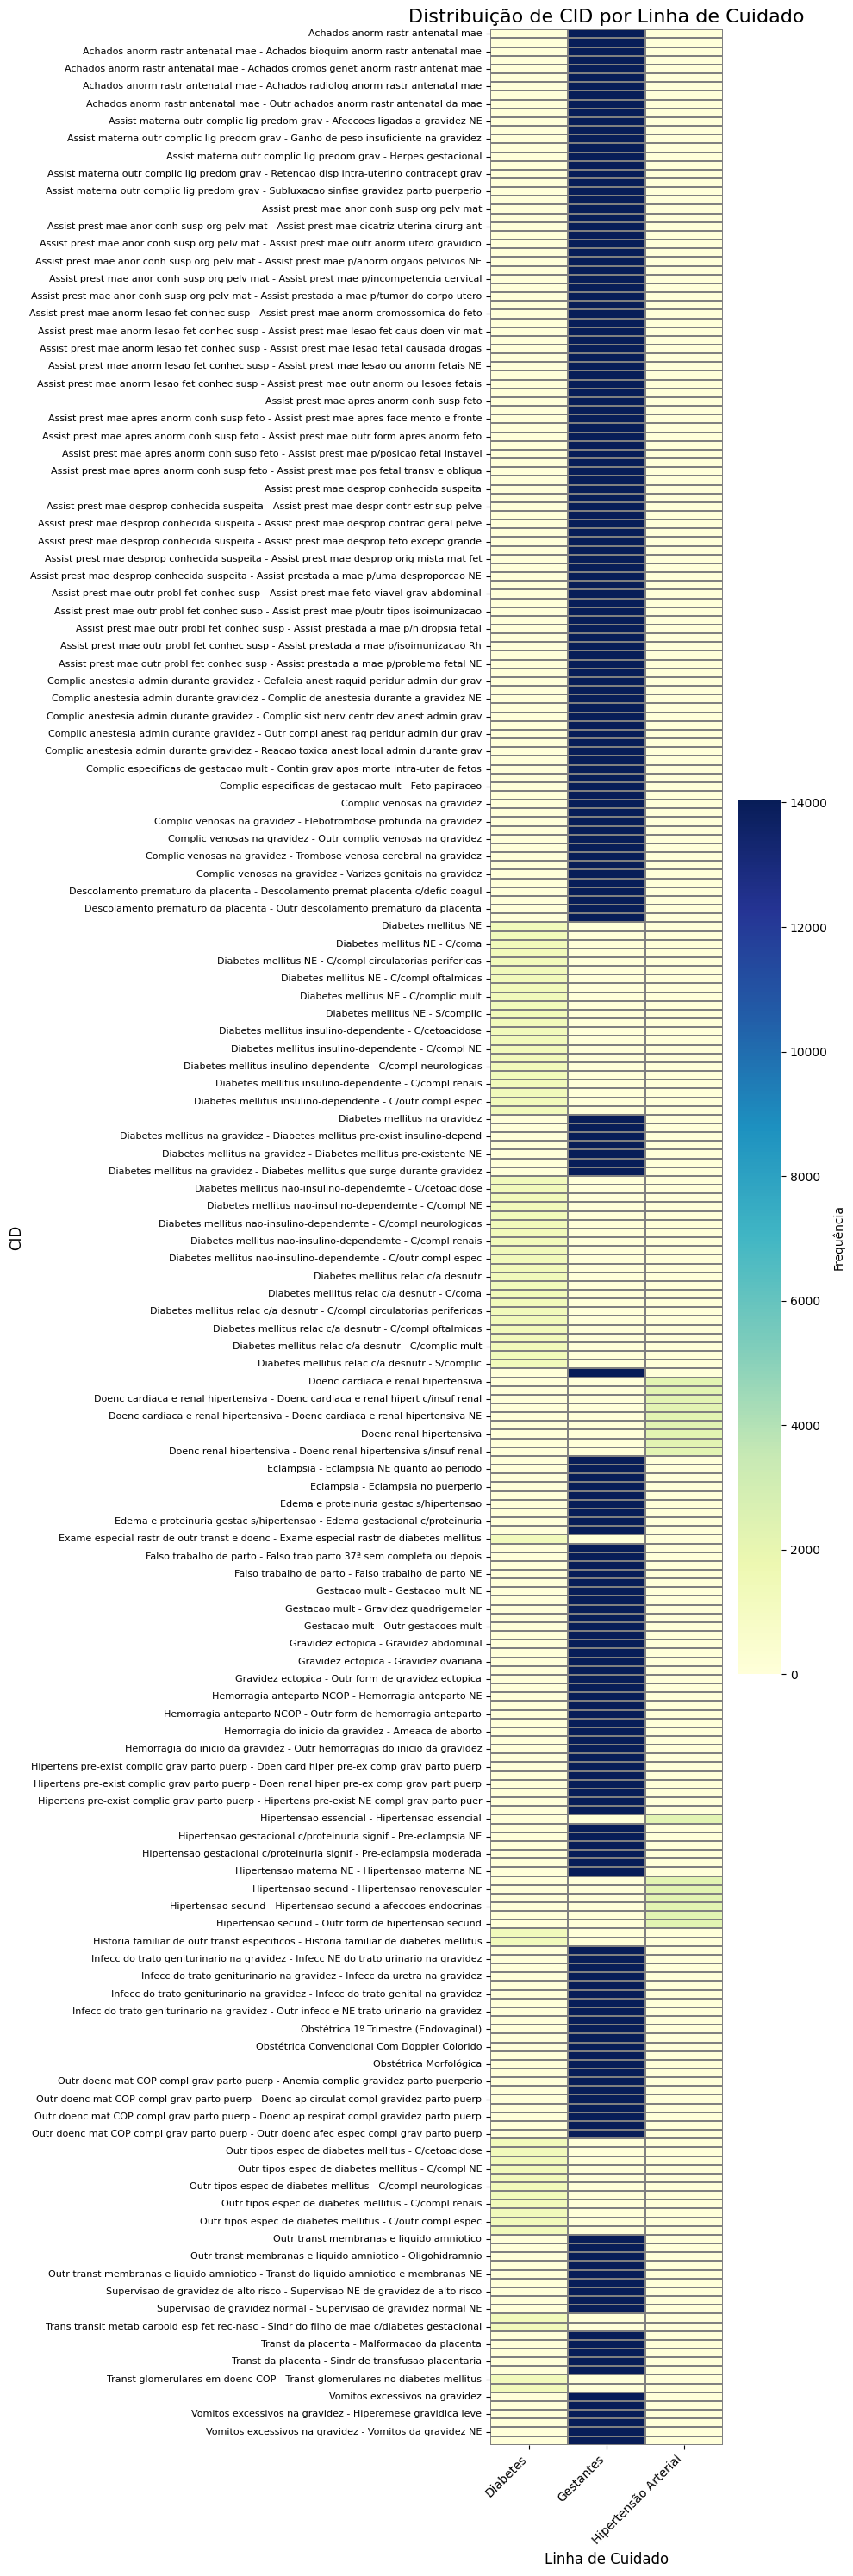

In [116]:
# Linha de cuidado em relação ao diagnistico
# Calcula a crosstab
crosstab = pd.crosstab(cid_paciente['ds_cid'], cid_paciente['ds_linha_cuidado'])

# Criação da figura com tamanho maior para acomodar todos os rótulos
plt.figure(figsize=(10, 30))

# Criação do heatmap SEM os valores numéricos
sns.heatmap(
    crosstab,
    annot=False,
    cmap="YlGnBu",
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label': 'Frequência'}
)

# Títulos e rótulos
plt.title("Distribuição de CID por Linha de Cuidado", fontsize=16)
plt.ylabel("CID", fontsize=12)
plt.xlabel("Linha de Cuidado", fontsize=12)

# Rotação dos rótulos
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

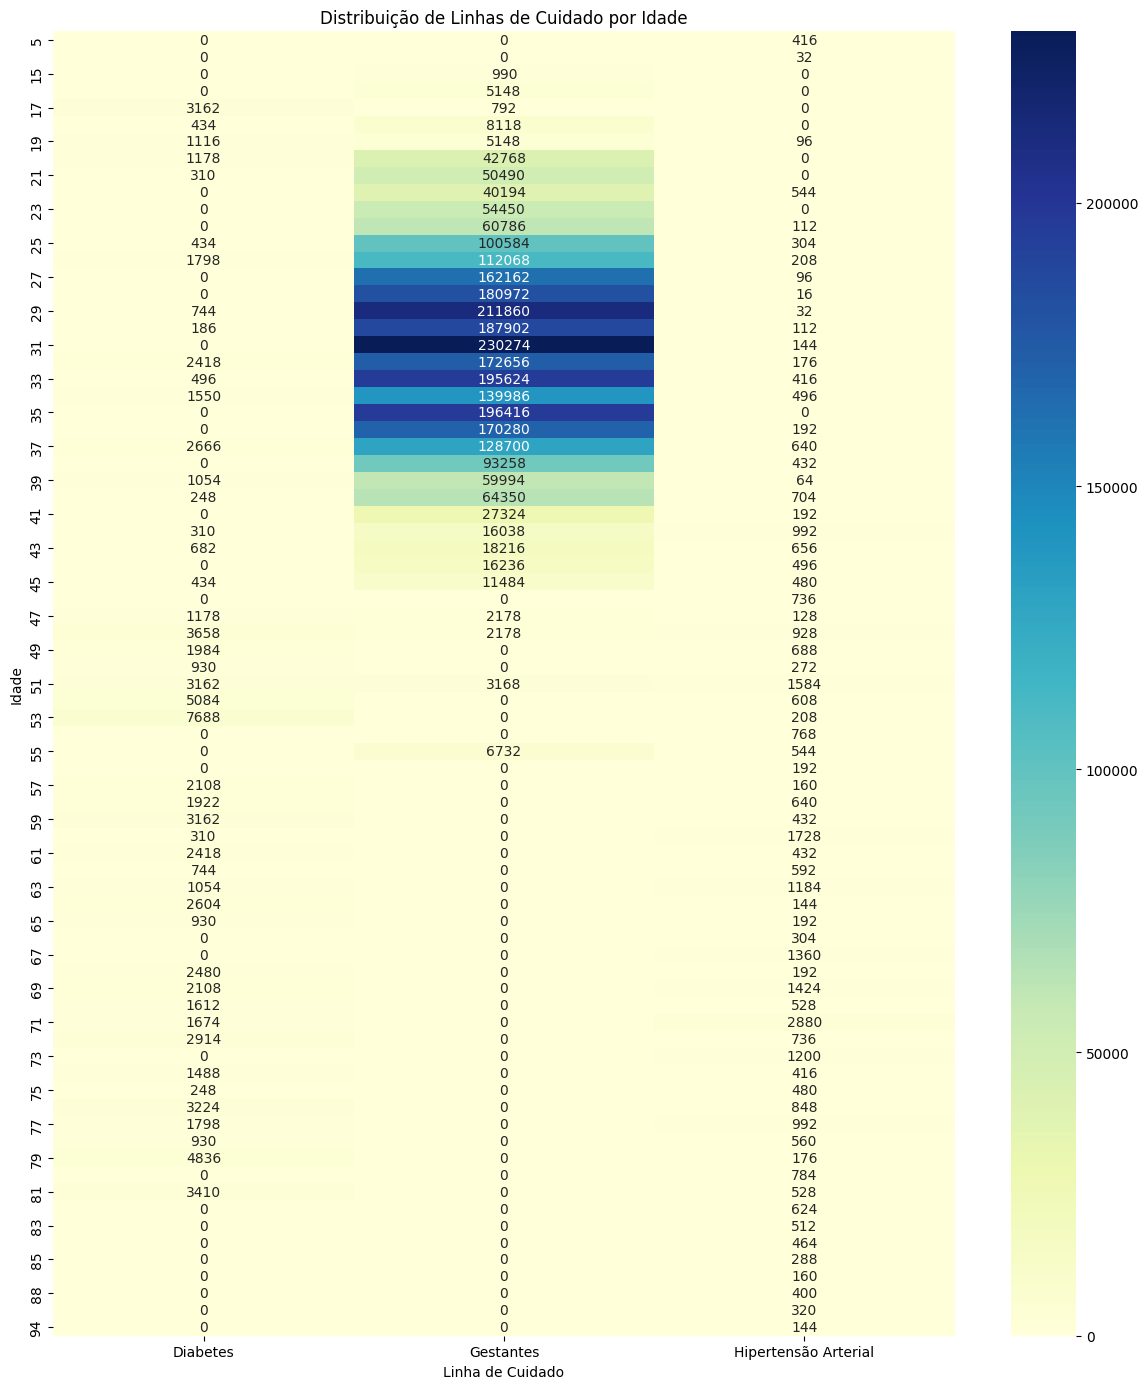

In [117]:
# Linha de cuidado em relação a idade
crosstab = pd.crosstab(
    cid_paciente['qt_idade'], 
    cid_paciente['ds_linha_cuidado']
)

plt.figure(figsize=(12, 14))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribuição de Linhas de Cuidado por Idade')
plt.ylabel('Idade')
plt.xlabel('Linha de Cuidado')
plt.tight_layout()
plt.show()

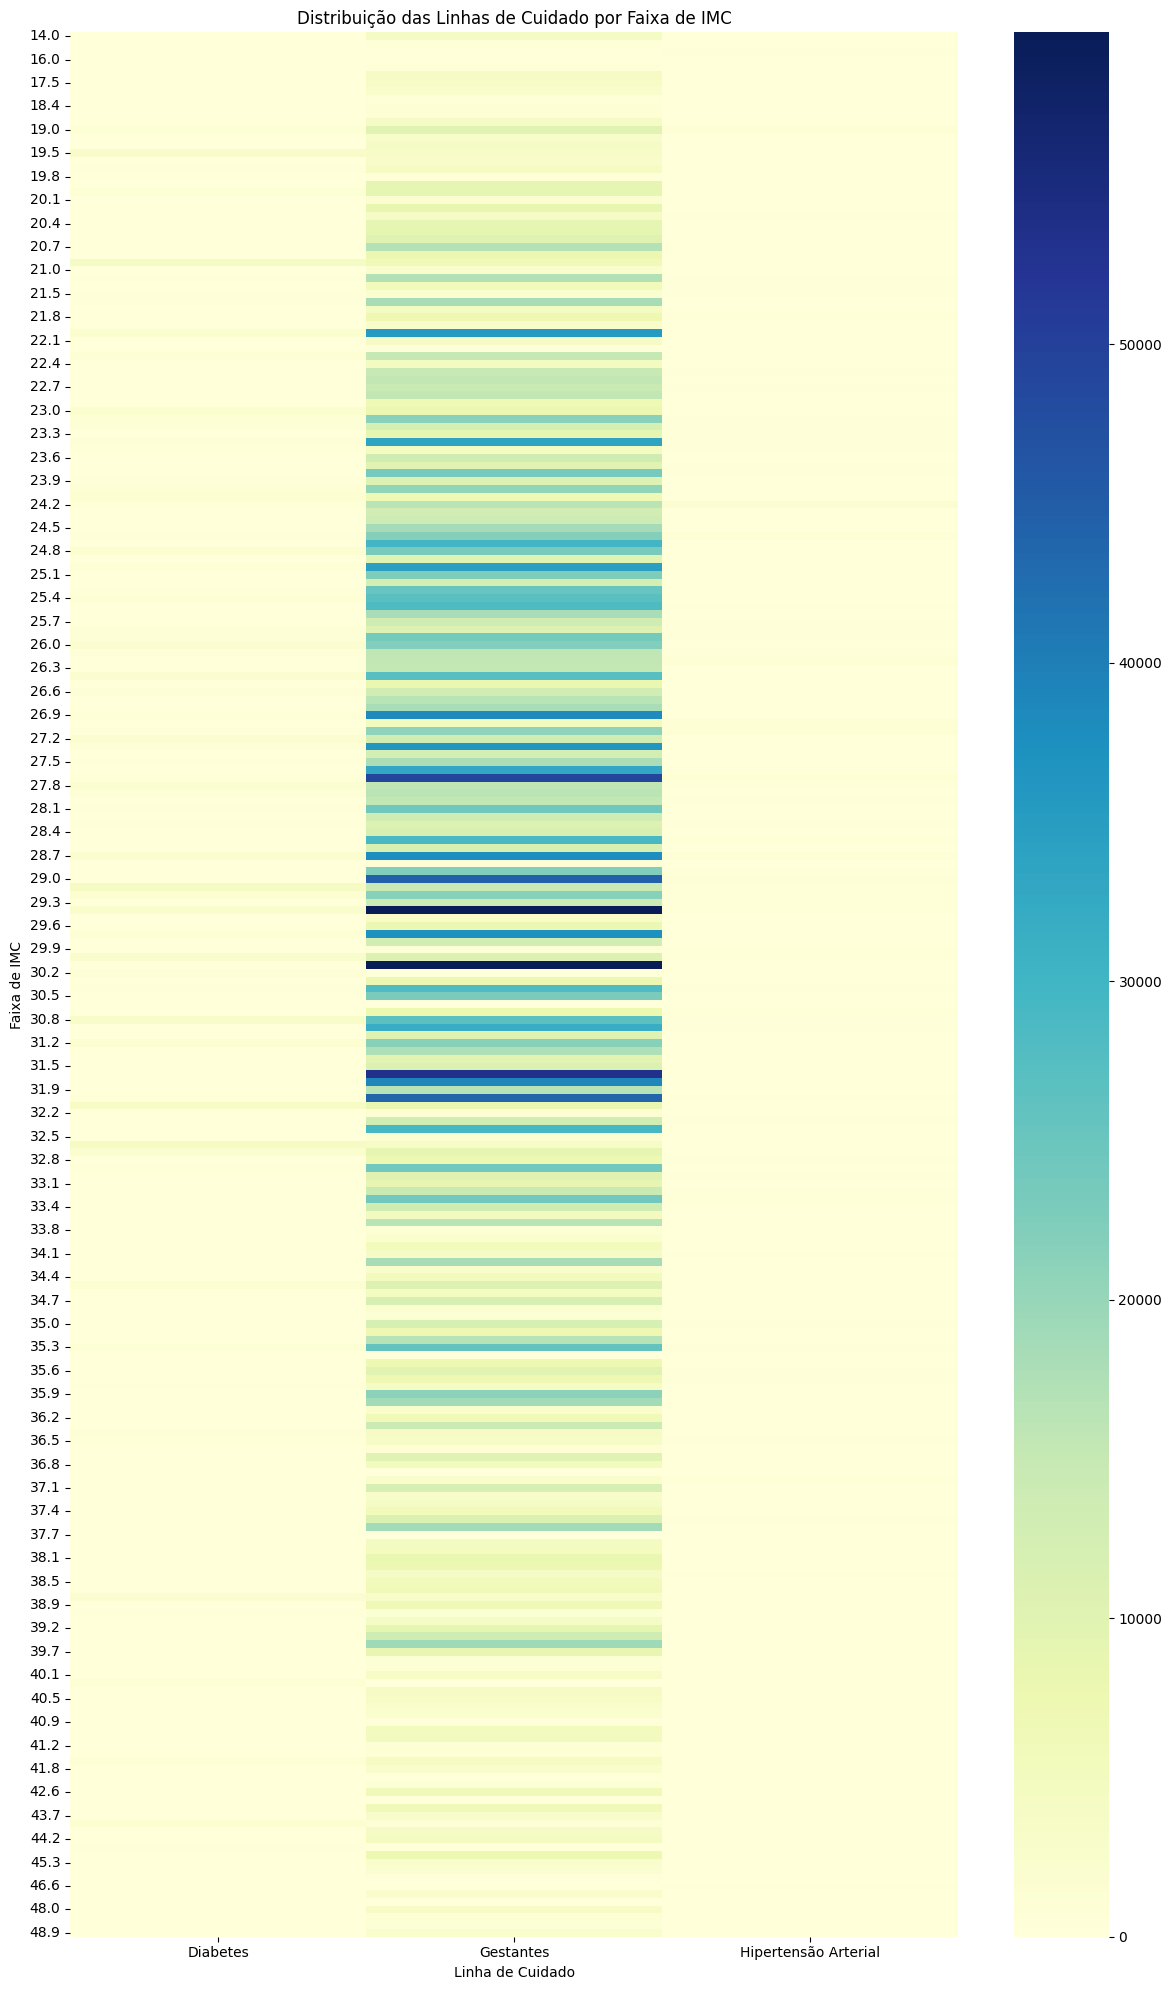

In [118]:
# Linha de cuidado em relação ao imc
tabela_heatmap = pd.crosstab(
    cid_paciente['qt_imc'], 
    cid_paciente['ds_linha_cuidado']
)

# Plotando
plt.figure(figsize=(12, 20))
sns.heatmap(tabela_heatmap, annot=False, fmt='d', cmap='YlGnBu')
plt.title('Distribuição das Linhas de Cuidado por Faixa de IMC')
plt.xlabel('Linha de Cuidado')
plt.ylabel('Faixa de IMC')
plt.tight_layout()
plt.show()

In [119]:
# Linha de cuidado em relação ao sexo
# Tabela de frequências com totais
tabela = pd.crosstab(
    cid_paciente['cd_sexo'], 
    cid_paciente['ds_linha_cuidado'], 
    margins=True, 
    normalize='index'  # porcentagem por linha
) * 100

# Arredonda e renomeia
tabela = tabela.round(1)
tabela.rename(index={'All': 'Total'}, columns={'All': 'Total'}, inplace=True)

print(tabela)

ds_linha_cuidado  Diabetes  Gestantes  Hipertensão Arterial
cd_sexo                                                    
F                      1.5       97.7                   0.7
M                     72.0        0.0                  28.0
Total                  2.9       95.8                   1.3


In [120]:
# Linha de cuidado em relação ao peso
# Definir faixas de peso personalizadas
bins = [0, 50, 60, 70, 80, 90, 100, 120, float('inf')]
labels = ['<50kg', '50-60kg', '60-70kg', '70-80kg', '80-90kg', '90-100kg', '100-120kg', '>120kg']

# Nova coluna com faixas
cid_paciente['faixa_peso'] = pd.cut(cid_paciente['qt_peso'], bins=bins, labels=labels)

# Tabela com porcentagem por linha (faixa de peso)
tabela = pd.crosstab(
    cid_paciente['faixa_peso'], 
    cid_paciente['ds_linha_cuidado'], 
    normalize='index'
) * 100

tabela = tabela.round(1)
print(tabela)

ds_linha_cuidado  Diabetes  Gestantes  Hipertensão Arterial
faixa_peso                                                 
<50kg                  5.7       92.9                   1.4
50-60kg                2.9       95.7                   1.5
60-70kg                2.4       96.5                   1.1
70-80kg                2.1       96.7                   1.2
80-90kg                3.1       96.0                   0.9
90-100kg               4.3       94.6                   1.1
100-120kg              3.7       93.7                   2.6
>120kg                 8.1       85.2                   6.7


#### custo_beneficiario

In [121]:
# Gasto em relação a idade
# Criar faixas de idade (exemplo: crianças, jovens, adultos, idosos)
bins_idade = [0, 18, 35, 50, 65, 120]
labels_idade = ['0-17', '18-34', '35-49', '50-64', '65+']
custo_beneficiario['faixa_idade'] = pd.cut(custo_beneficiario['qt_idade'], bins=bins_idade, labels=labels_idade)

# Criar faixas de gasto (exemplo em unidades monetárias, ajuste conforme necessário)
bins_gasto = [0, 100, 500, 1000, 5000, 10000, float('inf')]
labels_gasto = ['0-100', '101-500', '501-1000', '1001-5000', '5001-10000', '>10000']
custo_beneficiario['faixa_gasto'] = pd.cut(custo_beneficiario['vl_item'], bins=bins_gasto, labels=labels_gasto)

# Crosstab com frequência absoluta
tabela = pd.crosstab(custo_beneficiario['faixa_idade'], custo_beneficiario['faixa_gasto'])

print(tabela)

faixa_gasto   0-100  101-500  501-1000  1001-5000  5001-10000  >10000
faixa_idade                                                          
0-17         364185    88642      6145       2478          98      81
18-34        597883   122791     18282       6561        1219      24
35-49        691719   138068     24403       8056         498      50
50-64        446660    97117     17763       6201          74      61
65+          321018    74192     13533       6041          70      47


In [122]:
# Gasto em relação ao sexo
# Média, mediana, std do gasto agrupado por sexo
resumo = custo_beneficiario.groupby('ds_sexo', observed=True)['vl_item'].agg(['mean', 'max', 'min', 'count']).round(2)
print(resumo)

            mean      max   min    count
ds_sexo                                 
Feminino   88.39  44000.0  0.01  1903431
Masculino  93.67  65409.9  0.01  1158003


In [123]:
# Gasto em relação ao estado civil
resumo = custo_beneficiario.groupby('ds_estado_civil', observed=True)['vl_item'].agg(['mean', 'max', 'min', 'count']).round(2)
print(resumo)

                             mean       max   min    count
ds_estado_civil                                           
Casado                      94.12  58183.44  0.01  1501043
Concubinato/União Estável   97.37  16216.10  0.01   126470
Desquitado                 154.08   3591.50  1.31      310
Divorciado                 100.15  15500.00  0.01    41543
Outros                      91.72   8201.07  0.01     5625
Separado                    91.24   9487.24  0.01    12962
Solteiro                    84.89  65409.90  0.01  1314612
Viúvo                       95.44  16216.10  0.01    58869


In [124]:
# Gasto em relação ao estado civil
bins_gasto = [0, 100, 500, 1000, 5000, 10000, float('inf')]
labels_gasto = ['0-100', '101-500', '501-1000', '1001-5000', '5001-10000', '>10000']

custo_beneficiario['faixa_gasto'] = pd.cut(custo_beneficiario['vl_item'], bins=bins_gasto, labels=labels_gasto)

tabela = pd.crosstab(custo_beneficiario['ds_estado_civil'], custo_beneficiario['faixa_gasto'], normalize='index') * 100
tabela = tabela.round(1)
print(tabela)

faixa_gasto                0-100  101-500  501-1000  1001-5000  5001-10000  \
ds_estado_civil                                                              
Casado                      79.3     16.6       2.9        1.1         0.1   
Concubinato/União Estável   79.9     16.2       2.8        1.0         0.2   
Desquitado                  69.7     21.0       6.8        2.6         0.0   
Divorciado                  77.4     17.9       3.4        1.3         0.0   
Outros                      78.5     17.8       2.7        0.9         0.1   
Separado                    78.6     17.7       2.7        1.1         0.0   
Solteiro                    79.2     17.7       2.2        0.8         0.1   
Viúvo                       77.7     17.9       3.1        1.3         0.0   

faixa_gasto                >10000  
ds_estado_civil                    
Casado                        0.0  
Concubinato/União Estável     0.0  
Desquitado                    0.0  
Divorciado                    0.0  
Out

In [125]:
# Gastos totais por plano
##1. Análise básica de gastos por item e plano
gastos_por_item_plano = custo_beneficiario.groupby(
    ['ds_plano', 'ds_item'], 
    observed=True
).agg(
    total_gasto=('vl_item', 'sum'),
    quantidade=('vl_item', 'count'),
    valor_medio=('vl_item', 'mean')
).reset_index()

##2. Ordenar por maior gasto
gastos_por_item_plano = gastos_por_item_plano.sort_values(
    ['ds_plano', 'total_gasto'], 
    ascending=[True, False]
)

##3. Adicionar porcentagem do gasto total por plano
gastos_por_item_plano['%_do_plano'] = (
    gastos_por_item_plano['total_gasto'] / 
    gastos_por_item_plano.groupby('ds_plano')['total_gasto'].transform('sum')
) * 100

## 4. Análise complementar - Top 10 itens mais caros por plano
top_itens_por_plano = gastos_por_item_plano.groupby('ds_plano').head(10)

## 5. Visualização dos resultados
print("Gastos totais por item em cada plano:")
display(gastos_por_item_plano)

Gastos totais por item em cada plano:


C:\Users\andre\AppData\Local\Temp\ipykernel_18424\2024184998.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gastos_por_item_plano.groupby('ds_plano')['total_gasto'].transform('sum')
C:\Users\andre\AppData\Local\Temp\ipykernel_18424\2024184998.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_itens_por_plano = gastos_por_item_plano.groupby('ds_plano').head(10)


ds_plano  \
52                           ADAPTACAO BAS+1+2 - PLANO 7   
17                           ADAPTACAO BAS+1+2 - PLANO 7   
27                           ADAPTACAO BAS+1+2 - PLANO 7   
67                           ADAPTACAO BAS+1+2 - PLANO 7   
1                            ADAPTACAO BAS+1+2 - PLANO 7   
...                                                  ...   
63276  Unifamilia Individual Familiar Regional Enferm...   
63838  Unifamilia Individual Familiar Regional Enferm...   
63932  Unifamilia Individual Familiar Regional Enferm...   
63280  Unifamilia Individual Familiar Regional Enferm...   
63926  Unifamilia Individual Familiar Regional Enferm...   

                                                 ds_item  total_gasto  \
52                                   PROCEDIMENTO ATÉ 3H      9389.33   
17                   Consulta domiciliar em fisioterapia      3055.00   
27      ENFERMEIRO - COLETA DOMICILIAR - ENFERMEIRO - PG      2980.00   
67     TAXA DE AUXILIAR/TÉCNICO DE ENFERMAGEM NO DOMI...      2027.10   
1                              ATENDIMENTO DE ENFERMAGEM      1161.24   
...                                                  ...          ...   
63276            FOTOCOAG. (LASER) P/ SESSAO - MONOCULAR         3.24   
63838        S. Sífilis Vdrl Por Componente Hemoterápico         3.22   
63932                        Tempo De Sangramento (Duke)         2.86   
63280                               Falcização, Teste De         2.71   
63926                                 Taxa ESU Operadora         1.06   

       quantidade  valor_medio  %_do_plano  
52              6  1564.888333   38.063180  
17              5   611.000000   12.384591  
27              4   745.000000   12.080551  
67              1  2027.100000    8.217612  
1               6   193.540000    4.707523  
...           ...          ...         ...  
63276           2     1.620000    0.000049  
63838           1     3.220000    0.000049  
63932           1     2.860000    0.000043  
63280           1     2.710000    0.000041  
63926         106     0.010000    0.000016  

[64073 rows x 6 columns]

#### lc_beneficiario

In [126]:
#Linha de cuidado em relação a idade
# Definindo faixas de idade
bins = [0, 12, 18, 30, 45, 60, 75, 90, 120]
labels = ['0-11', '12-17', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']

lc_beneficiario['faixa_idade'] = pd.cut(lc_beneficiario['qt_idade'], bins=bins, labels=labels, right=False)

tabela = pd.crosstab(lc_beneficiario['faixa_idade'], lc_beneficiario['ds_linha_cuidado'])
print(tabela)


ds_linha_cuidado  Dengue  Diabetes  Diabetes e Hipertensão Arterial  \
faixa_idade                                                           
0-11                  70         0                                1   
12-17                 41         4                                0   
18-29                 86        14                                2   
30-44                110        23                                9   
45-59                 61        46                               33   
60-74                 25        42                               45   
75-89                  7        17                               24   
90+                    1         0                                0   

ds_linha_cuidado  Gestantes  Hipertensão Arterial  
faixa_idade                                        
0-11                      0                     3  
12-17                    10                     2  
18-29                   703                    57  
30-44                   893  

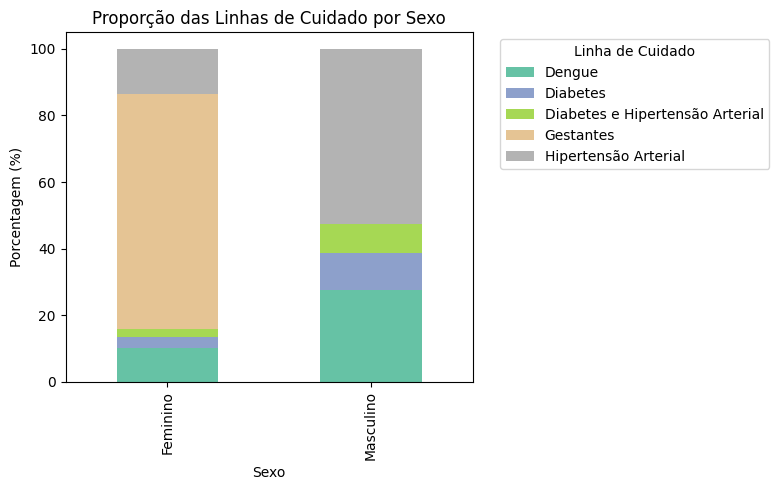

In [127]:
#Linha de cuidado em relação ao sexo
# Calcular proporção (% por linha)
tabela_pct = pd.crosstab(lc_beneficiario['ds_sexo'], lc_beneficiario['ds_linha_cuidado'], normalize='index') * 100

# Plotar gráfico de barras empilhadas
tabela_pct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.title('Proporção das Linhas de Cuidado por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Porcentagem (%)')
plt.legend(title='Linha de Cuidado', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [128]:
#Linha de cuidado em relação ao estado_civil
# Criar o crosstab com totais nas margens e normalizado por linha para ver proporções
ct = pd.crosstab(
    lc_beneficiario['ds_estado_civil'], 
    lc_beneficiario['ds_linha_cuidado'], 
    margins=True,  # adiciona totais
    normalize='index'  # mostra proporção em cada estado civil (linha)
)

# Formatar para porcentagem, duas casas decimais
ct_percentage = (ct * 100).round(2).astype(str) + '%'

# Melhorar visualização com estilo do pandas (opcional)
styled_ct = ct_percentage.style.background_gradient(cmap='Blues').set_caption("Distribuição % da Linha de Cuidado por Estado Civil")

display(styled_ct)

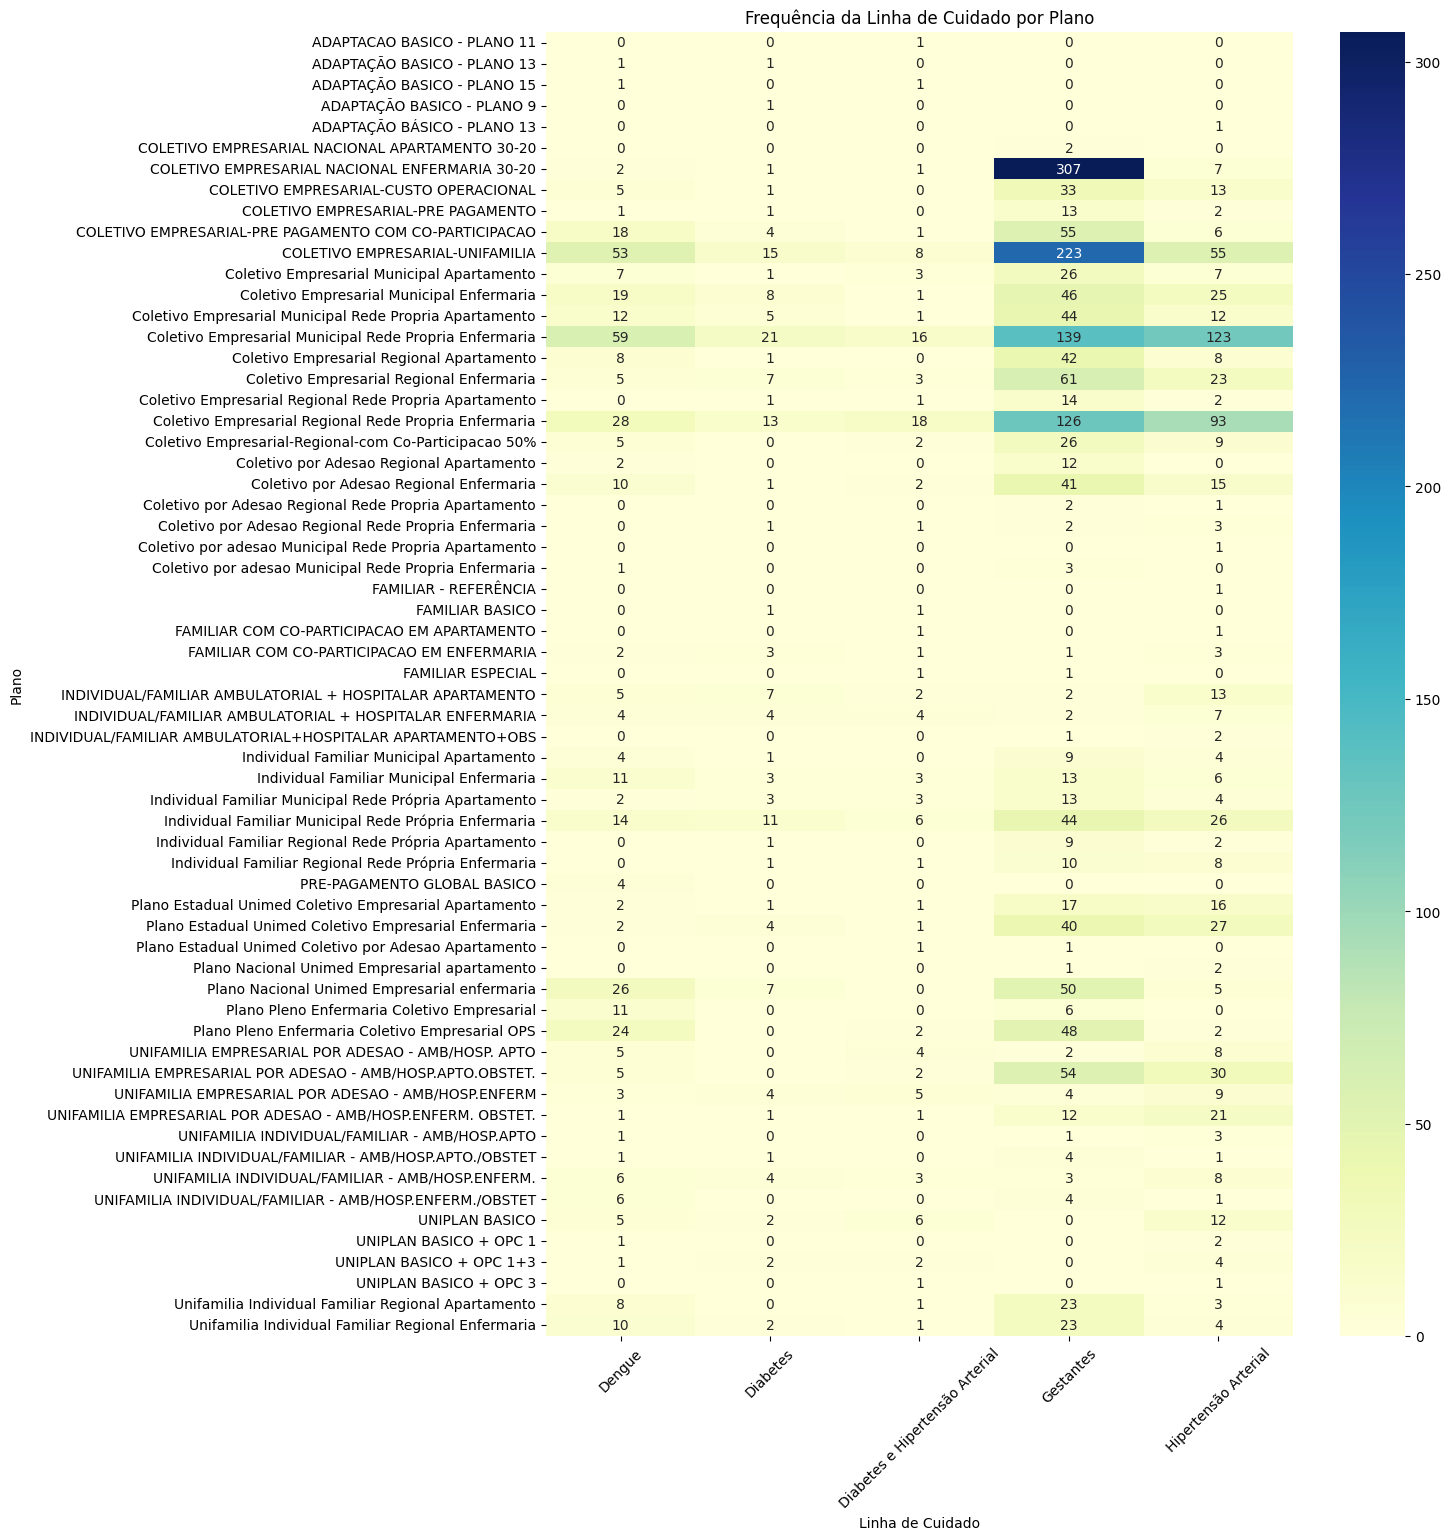

In [129]:
#Linha de cuidado em relação ao plano
tabela = pd.crosstab(lc_beneficiario['ds_plano'], lc_beneficiario['ds_linha_cuidado'])

plt.figure(figsize=(15, 14))
sns.heatmap(tabela, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Frequência da Linha de Cuidado por Plano')
plt.xlabel('Linha de Cuidado')
plt.ylabel('Plano')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### cid_atendimento

<Figure size 2000x1000 with 0 Axes>

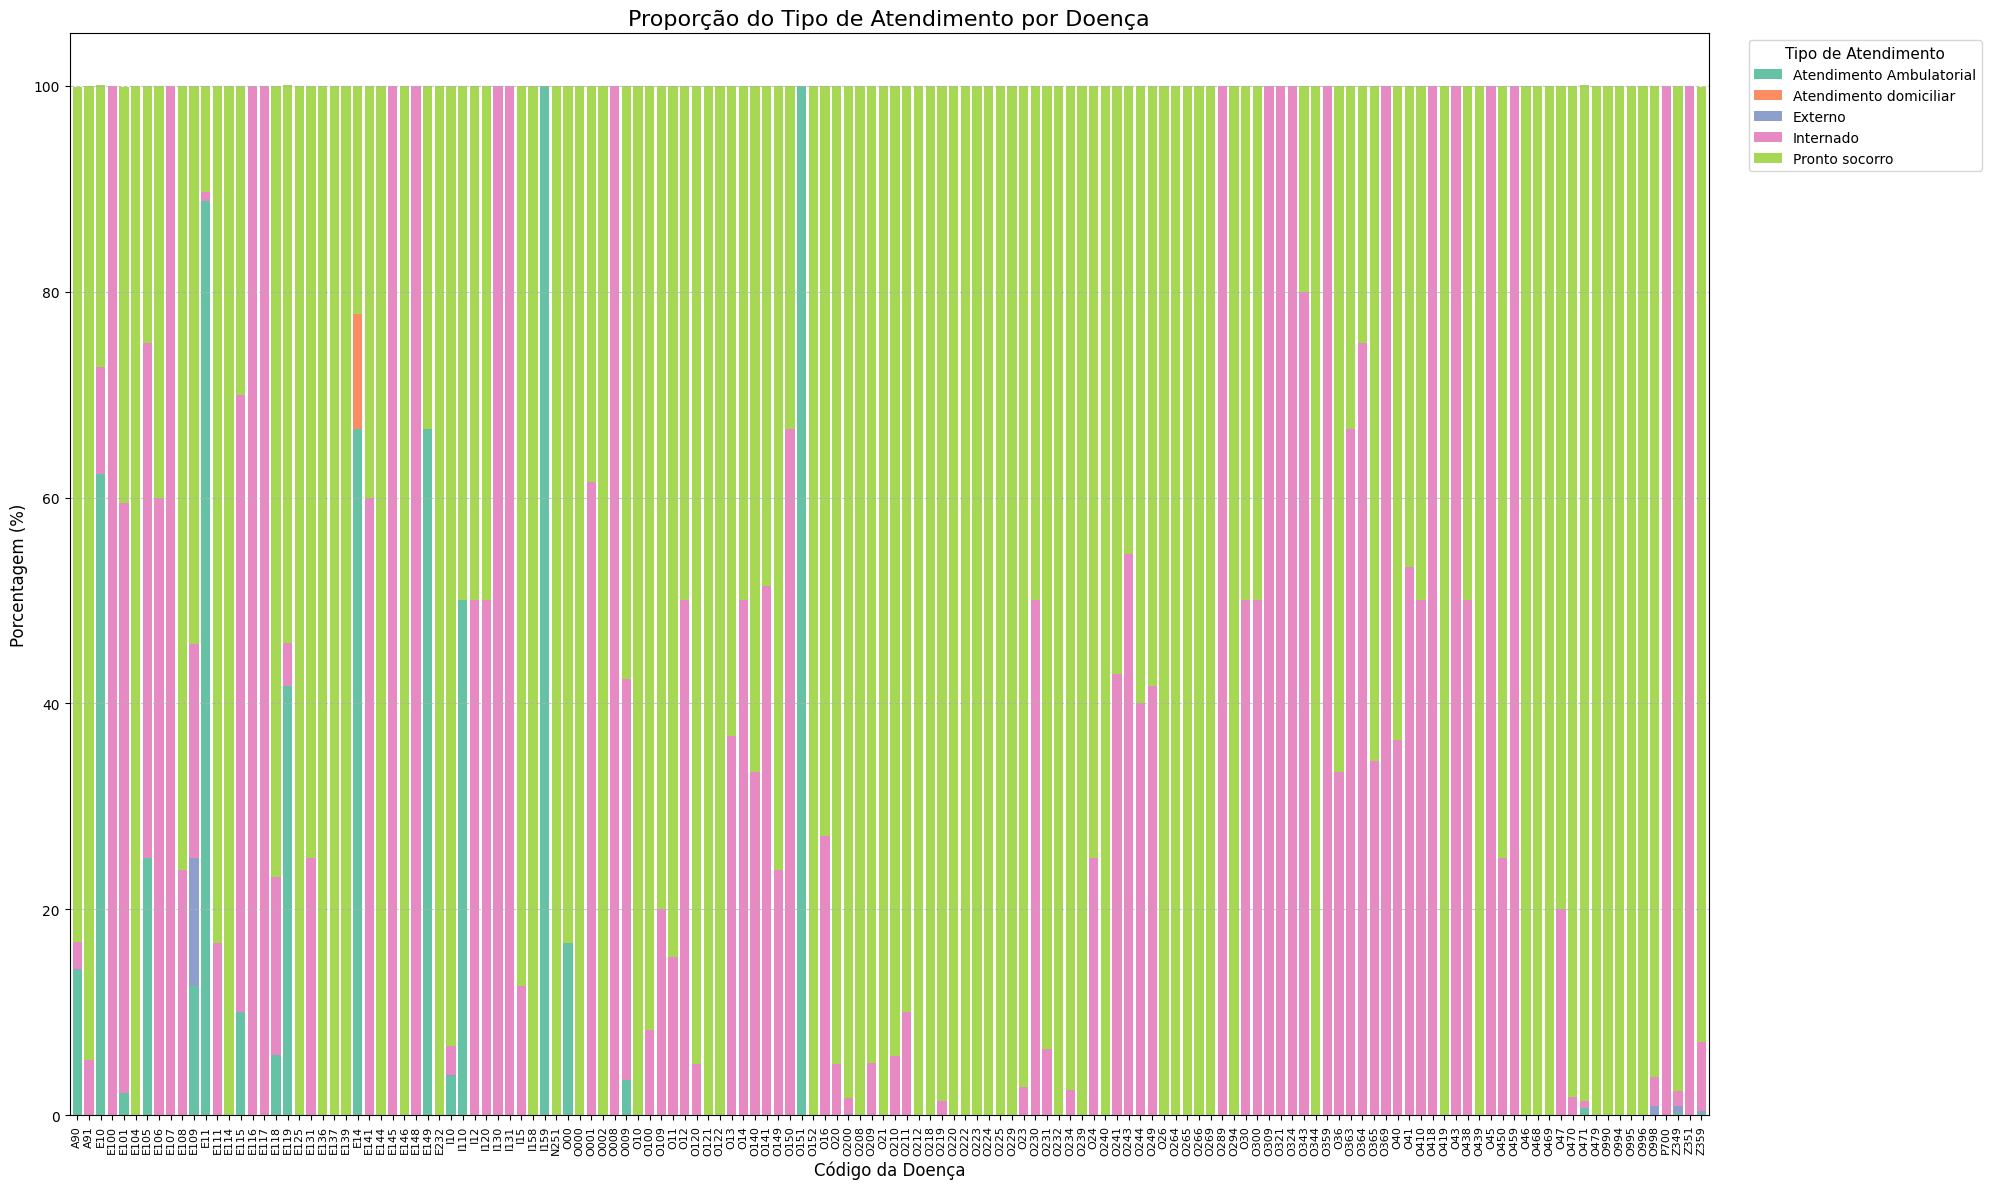

In [130]:
#Atendimento em relação a cid
# Cálculo das proporções
tabela_pct = pd.crosstab(cid_atendimento['cd_doenca'], cid_atendimento['ds_tipo_atendimento'], normalize='index') * 100
tabela_pct = tabela_pct.round(1)

# Plotagem com seaborn e matplotlib
plt.figure(figsize=(20, 10))
colors = sns.color_palette("Set2", n_colors=len(tabela_pct.columns))  # paleta mais suave

tabela_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    color=colors,
    width=0.8
)

plt.title('Proporção do Tipo de Atendimento por Doença', fontsize=16)
plt.xlabel('Código da Doença', fontsize=12)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.legend(title='Tipo de Atendimento', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### at_hgu

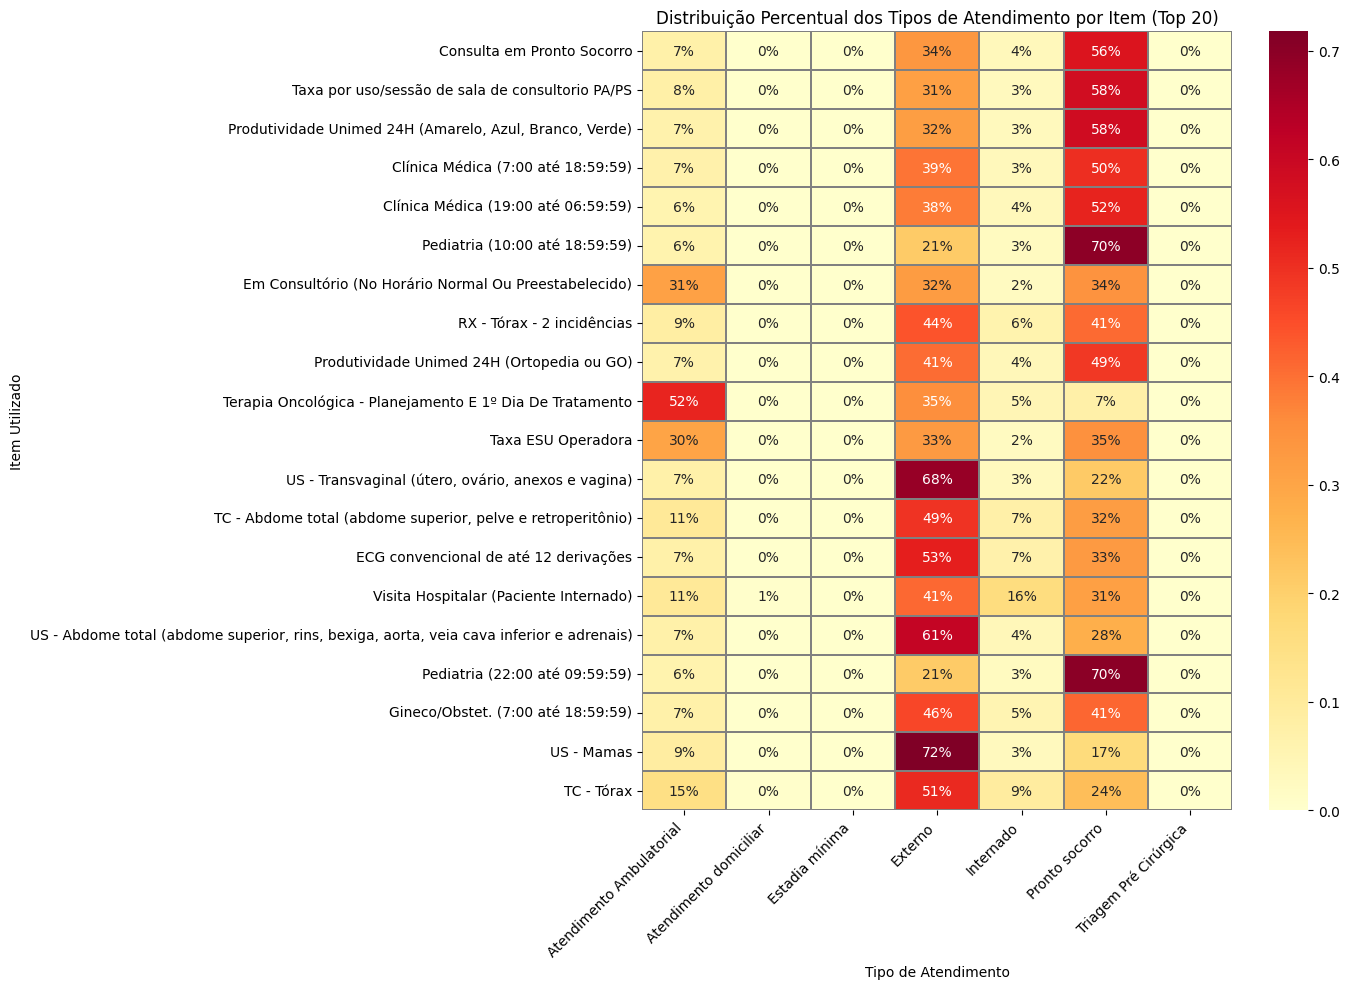

In [14]:
#item utilizado em relação ao tipo de atendimemento
# Crosstab básico
ct = pd.crosstab(at_hgu['ds_item'], at_hgu['ds_tipo_atendimento'])

# Selecionar os 20 itens mais utilizados
top_itens = ct.sum(axis=1).sort_values(ascending=False).head(20).index
ct_top = ct.loc[top_itens]

ct_percent = ct_top.div(ct_top.sum(axis=1), axis=0)

plt.figure(figsize=(14, 10))
sns.heatmap(ct_percent, annot=True, fmt='.0%', cmap='YlOrRd', linewidths=0.3, linecolor='gray')
plt.title('Distribuição Percentual dos Tipos de Atendimento por Item (Top 20)')
plt.xlabel('Tipo de Atendimento')
plt.ylabel('Item Utilizado')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

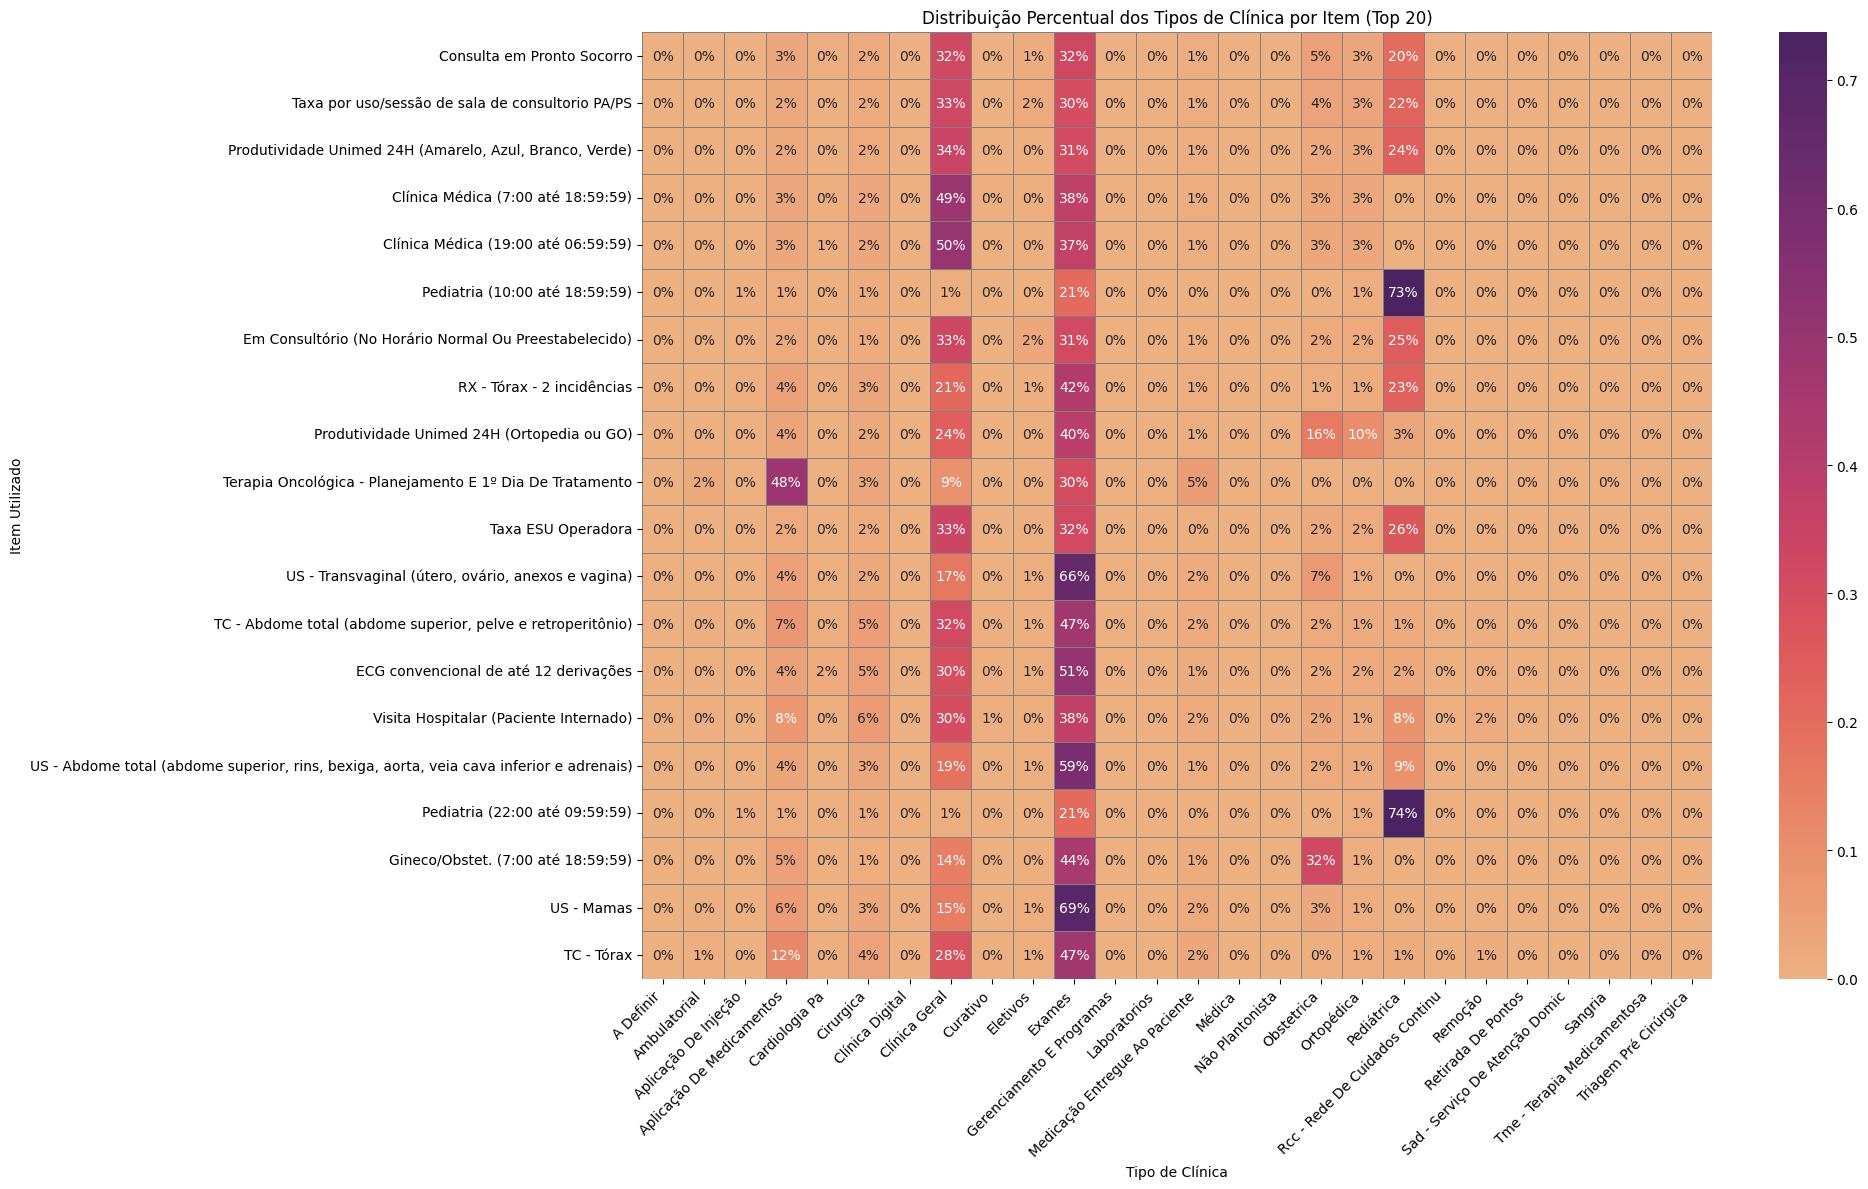

In [15]:
#item utilizado em relação ao tipo de clinica
# Geração do crosstab
ct_clinica = pd.crosstab(at_hgu['ds_item'], at_hgu['ds_clinica'])

# Selecionar os 20 itens mais utilizados
top_itens = ct_clinica.sum(axis=1).sort_values(ascending=False).head(20).index
ct_clinica_top = ct_clinica.loc[top_itens]

ct_percent_clinica = ct_clinica_top.div(ct_clinica_top.sum(axis=1), axis=0)

plt.figure(figsize=(20, 12))
sns.heatmap(ct_percent_clinica, annot=True, fmt='.0%', cmap='flare', linewidths=0.5, linecolor='gray')
plt.title('Distribuição Percentual dos Tipos de Clínica por Item (Top 20)')
plt.xlabel('Tipo de Clínica')
plt.ylabel('Item Utilizado')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### lc_cid

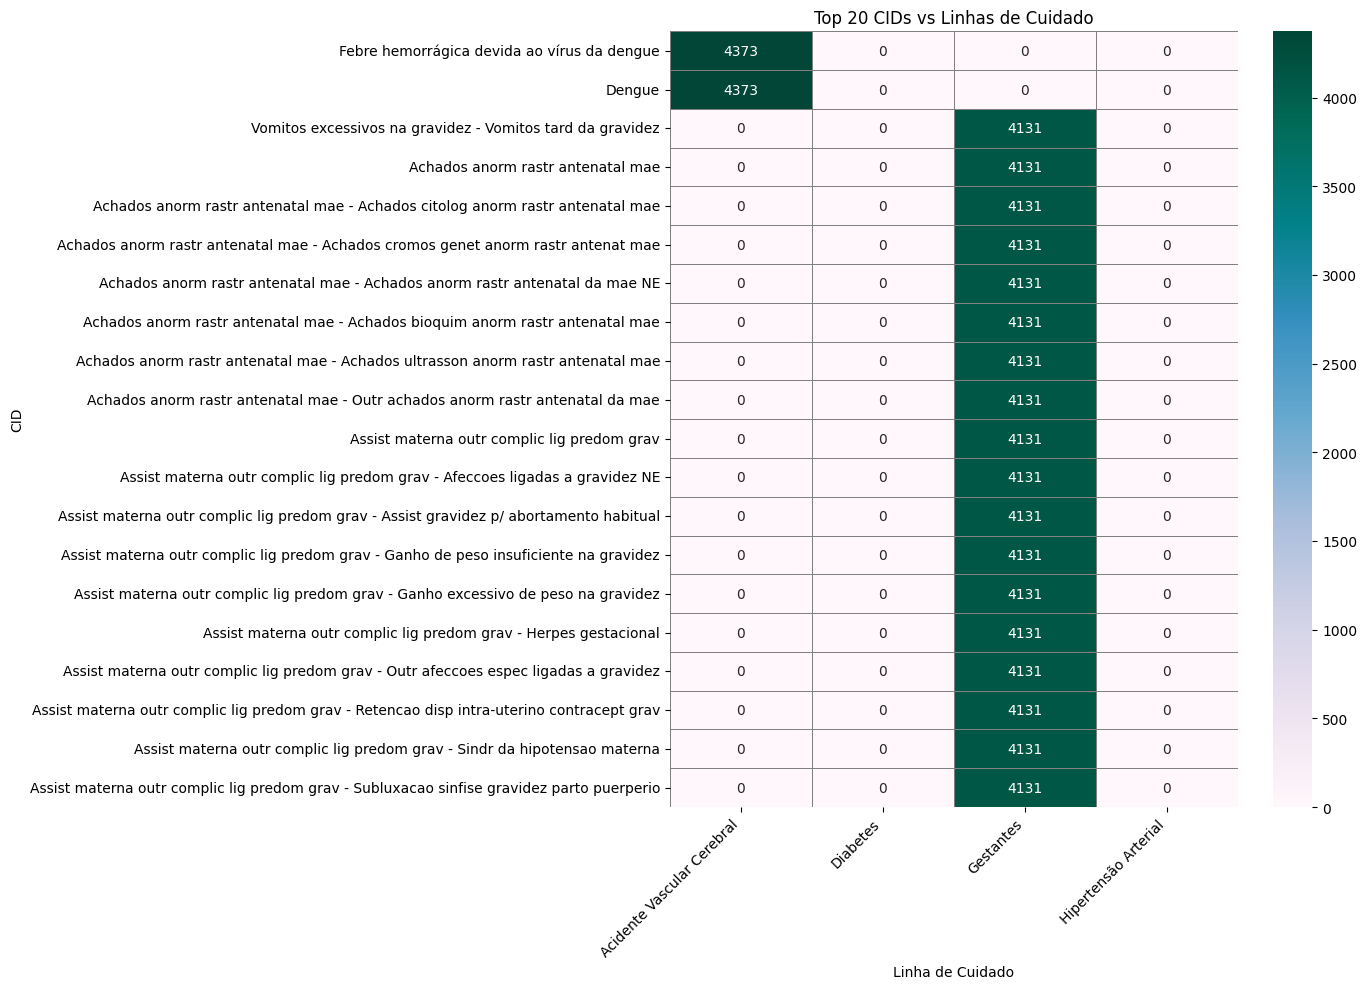

In [133]:
# Crosstab: relação entre CID e linha de cuidado
ct_cid = pd.crosstab(lc_cid['ds_cid'], lc_cid['ds_linha_cuidado'])

# Selecionar os 20 CIDs mais frequentes
top_cids = ct_cid.sum(axis=1).sort_values(ascending=False).head(20).index
ct_cid_top = ct_cid.loc[top_cids]

plt.figure(figsize=(14, 10))
sns.heatmap(ct_cid_top, annot=True, fmt='d', cmap='PuBuGn', linewidths=0.5, linecolor='gray')
plt.title('Top 20 CIDs vs Linhas de Cuidado')
plt.xlabel('Linha de Cuidado')
plt.ylabel('CID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### beneficiario_hgu

C:\Users\andre\AppData\Local\Temp\ipykernel_18424\938280128.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].replace(planos_menos_frequentes, 'Outros')


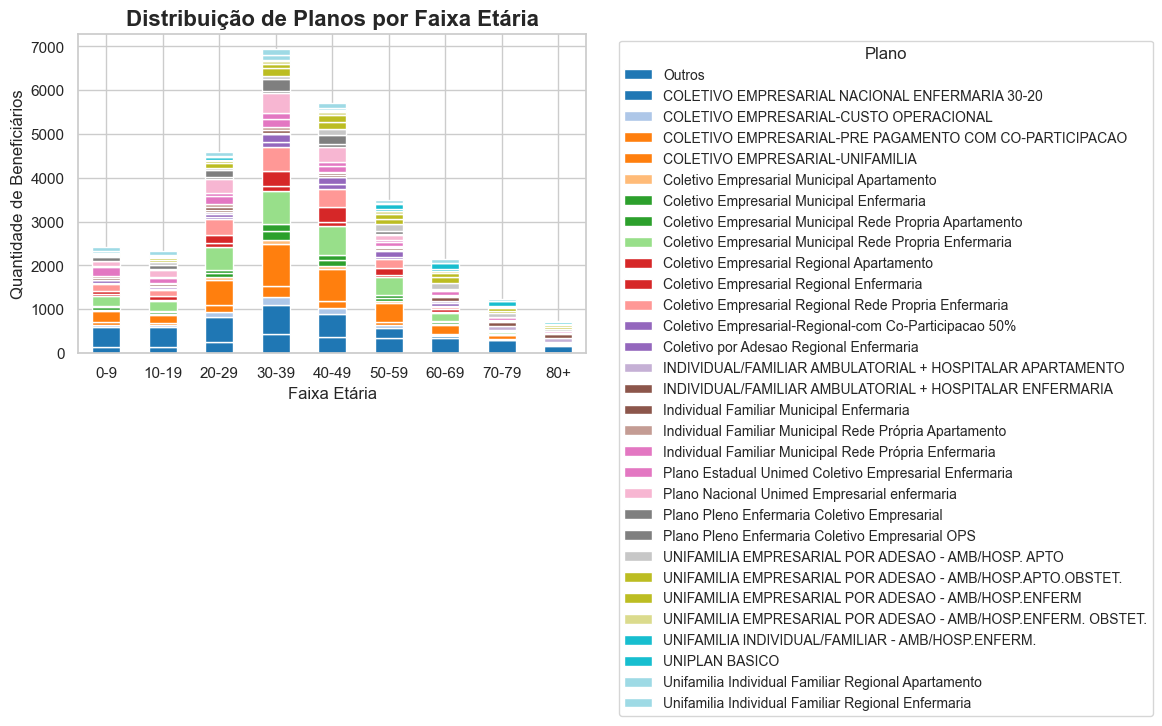

In [134]:
#plano relacionado a idade
# 1. Criar faixas etárias
bins = [0, 9, 19, 29, 39, 49, 59, 69, 79, 120]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
beneficiario_hgu['faixa_etaria'] = pd.cut(beneficiario_hgu['qt_idade_x'], bins=bins, labels=labels, right=True)

# 2. Agrupar planos pouco frequentes em "Outros"
plano_counts = beneficiario_hgu['ds_plano'].value_counts()
limite_minimo = 200  # Limite mínimo para destacar um plano individualmente
planos_menos_frequentes = plano_counts[plano_counts < limite_minimo].index
beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].replace(planos_menos_frequentes, 'Outros')

# 3. Gerar a crosstab (faixa etária × plano agrupado)
ct = pd.crosstab(beneficiario_hgu['faixa_etaria'], beneficiario_hgu['plano_agrupado'])

# 4. Gráfico
sns.set_theme(style="whitegrid")
ct.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# 5. Plotar
plt.title("Distribuição de Planos por Faixa Etária", fontsize=16, fontweight='bold')
plt.xlabel("Faixa Etária", fontsize=12)
plt.ylabel("Quantidade de Beneficiários", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Plano", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_18424\119357086.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].replace(planos_menos_frequentes, 'Outros')


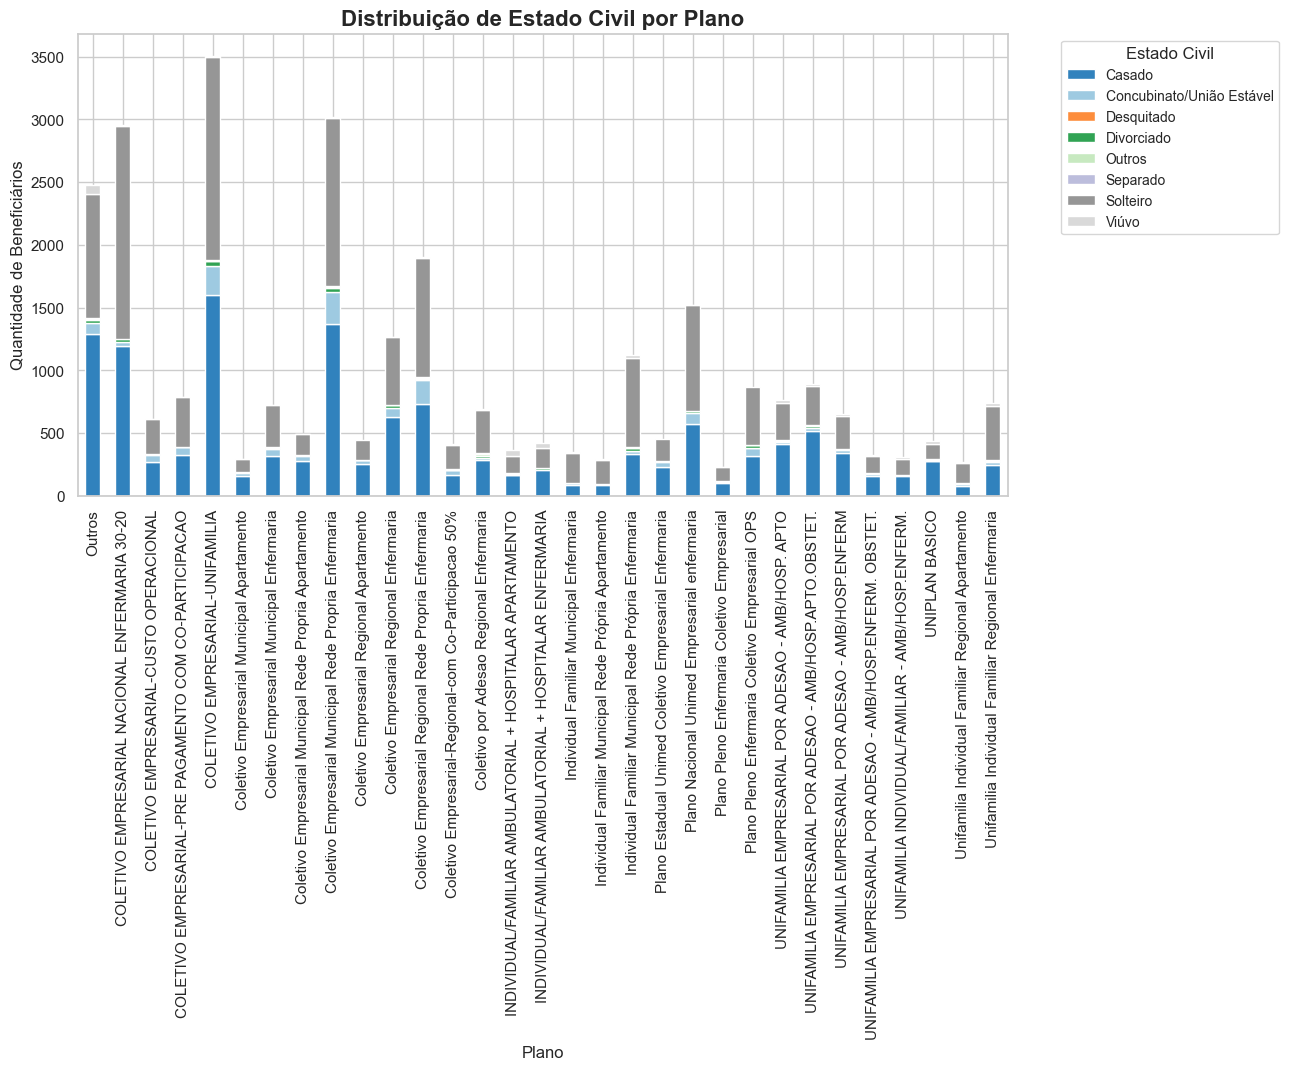

In [135]:
#plano relacionado a estado civil
# 1. Agrupar planos pouco frequentes em "Outros"
plano_counts = beneficiario_hgu['ds_plano'].value_counts()
limite_minimo = 200  
planos_menos_frequentes = plano_counts[plano_counts < limite_minimo].index
beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].replace(planos_menos_frequentes, 'Outros')

# 2. Crosstab com planos agrupados e estado civil
ct_estado_civil = pd.crosstab(beneficiario_hgu['plano_agrupado'], beneficiario_hgu['ds_estado_civil'])

# 3. Plotar gráfico de barras empilhadas
sns.set_theme(style="whitegrid")
ct_estado_civil.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20c')

# 4. Melhorias visuais
plt.title("Distribuição de Estado Civil por Plano", fontsize=16, fontweight='bold')
plt.xlabel("Plano", fontsize=12)
plt.ylabel("Quantidade de Beneficiários", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="Estado Civil", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

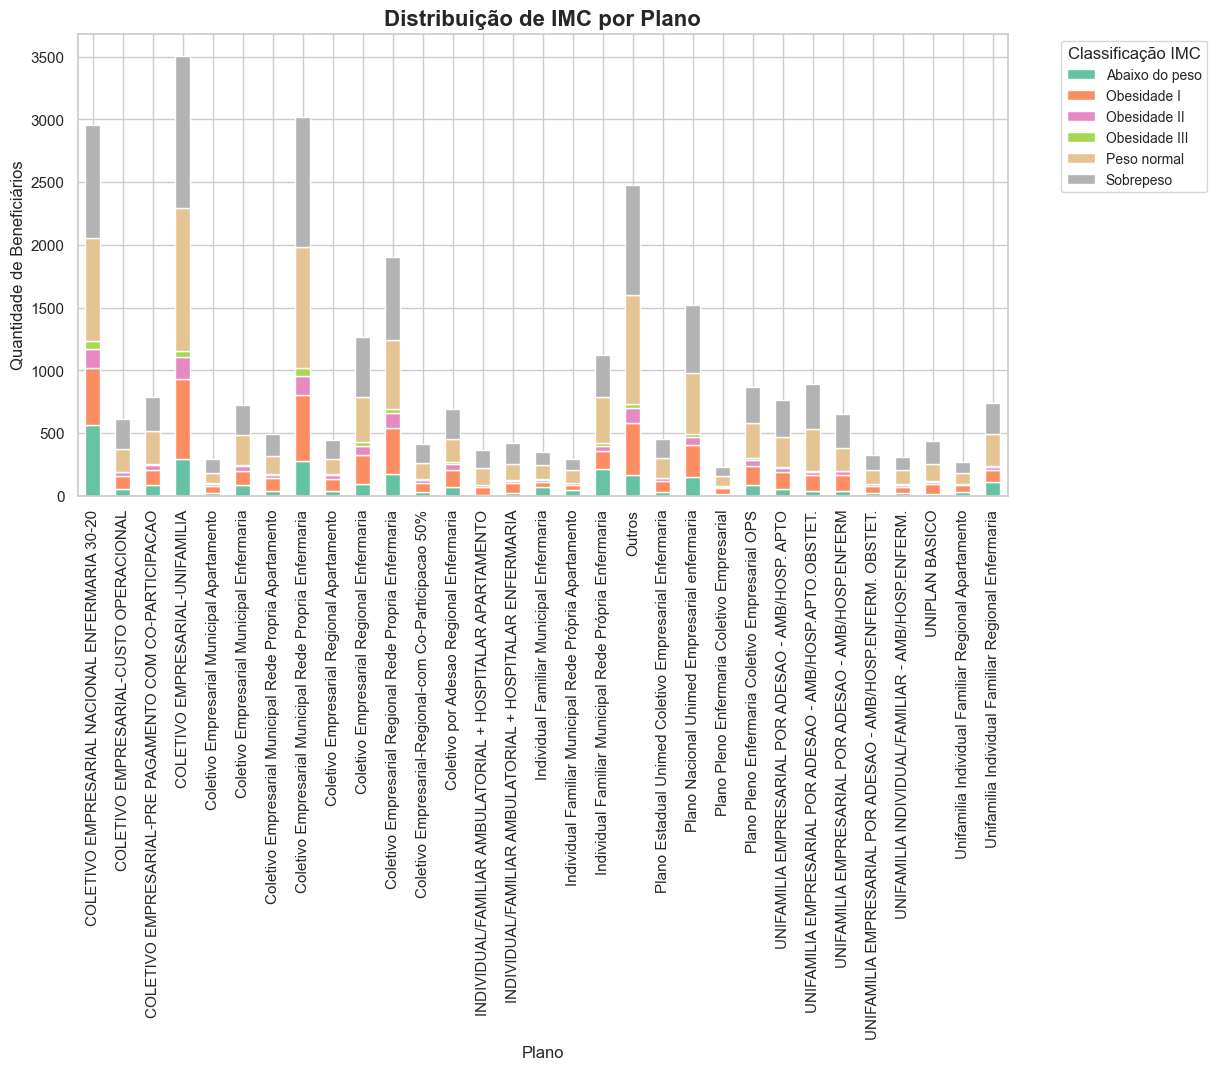

In [136]:
#plano relacionado a imc
# 1. Classificar IMC em categorias da OMS
def classificar_imc(imc):
    if imc < 18.5:
        return 'Abaixo do peso'
    elif 18.5 <= imc < 25:
        return 'Peso normal'
    elif 25 <= imc < 30:
        return 'Sobrepeso'
    elif 30 <= imc < 35:
        return 'Obesidade I'
    elif 35 <= imc < 40:
        return 'Obesidade II'
    else:
        return 'Obesidade III'

beneficiario_hgu['faixa_imc'] = beneficiario_hgu['qt_imc'].apply(classificar_imc)

# 2. Agrupar planos pouco frequentes
plano_counts = beneficiario_hgu['ds_plano'].value_counts()
limite_minimo = 200 
planos_menos_frequentes = plano_counts[plano_counts < limite_minimo].index
beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].astype(str).replace(planos_menos_frequentes, 'Outros')

# 3. Gerar a tabela cruzada
ct_imc = pd.crosstab(beneficiario_hgu['plano_agrupado'], beneficiario_hgu['faixa_imc'])

# 4. Plotar gráfico
sns.set_theme(style="whitegrid")
ct_imc.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title("Distribuição de IMC por Plano", fontsize=16, fontweight='bold')
plt.xlabel("Plano", fontsize=12)
plt.ylabel("Quantidade de Beneficiários", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="Classificação IMC", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_18424\1100917980.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  beneficiario_hgu['sexo_legivel'] = beneficiario_hgu['cd_sexo'].replace({


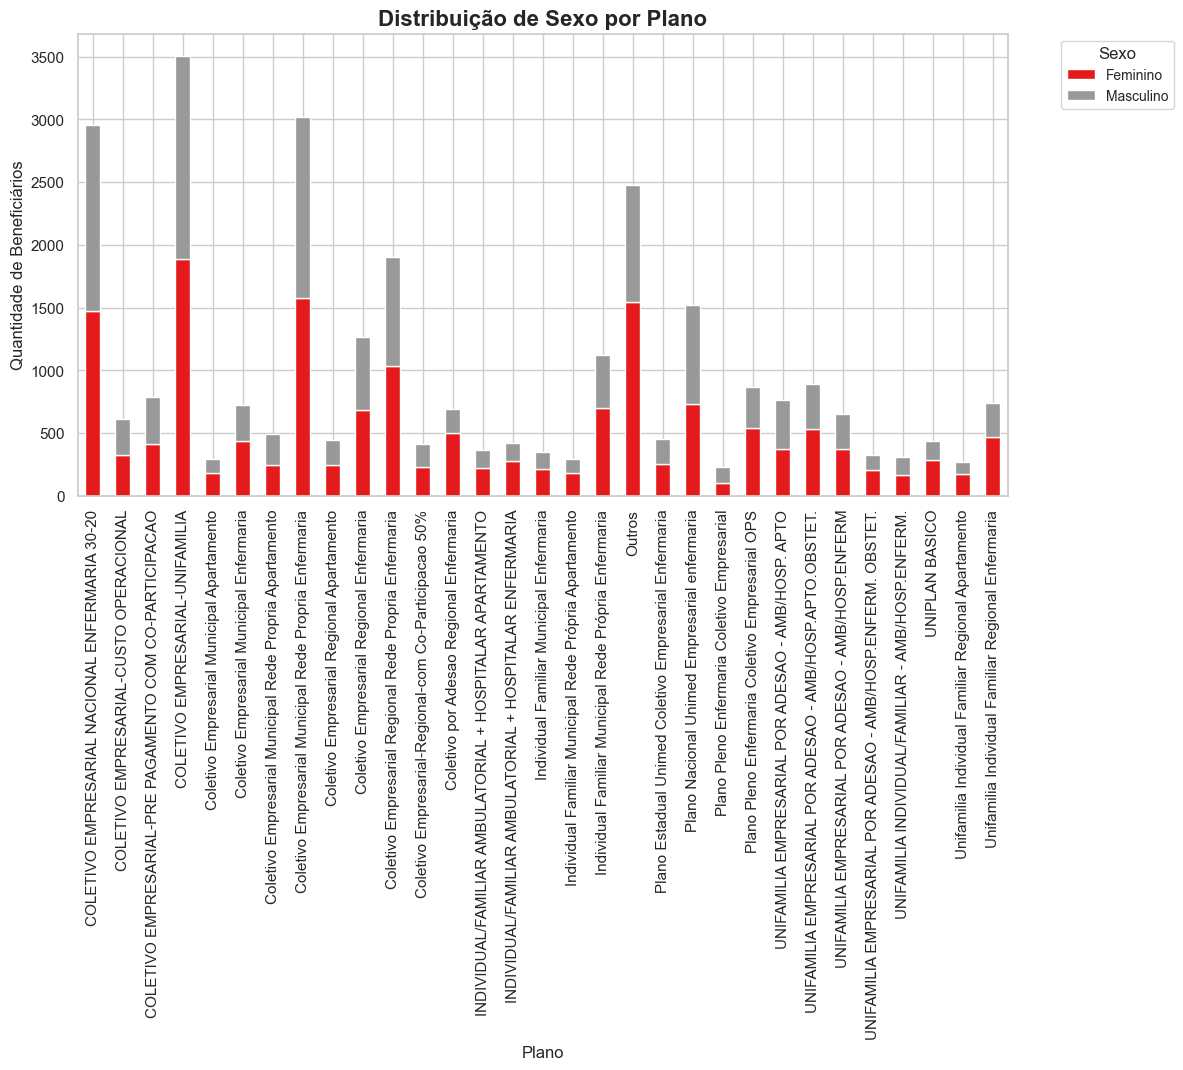

In [137]:
#plano relacionado a sexo
# 1. Agrupar planos pouco frequentes
plano_counts = beneficiario_hgu['ds_plano'].value_counts()
limite_minimo = 200  
planos_menos_frequentes = plano_counts[plano_counts < limite_minimo].index

# Evita FutureWarning ao usar .replace
beneficiario_hgu['plano_agrupado'] = beneficiario_hgu['ds_plano'].astype(str).replace(planos_menos_frequentes, 'Outros')

# 2. Renomear os códigos de sexo (se necessário)
beneficiario_hgu['sexo_legivel'] = beneficiario_hgu['cd_sexo'].replace({
    'M': 'Masculino',
    'F': 'Feminino',
})

# 3. Gerar a tabela cruzada
ct_sexo = pd.crosstab(beneficiario_hgu['plano_agrupado'], beneficiario_hgu['sexo_legivel'])

# 4. Plotar gráfico
sns.set_theme(style="whitegrid")
ct_sexo.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set1')

plt.title("Distribuição de Sexo por Plano", fontsize=16, fontweight='bold')
plt.xlabel("Plano", fontsize=12)
plt.ylabel("Quantidade de Beneficiários", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="Sexo", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

#### prodecimento_linha_cuidado

In [138]:
#relacionamento entre os item utilizado e linha de cuiadado
pd.crosstab(df9u['ds_item'], df9u['ds_linha_cuidado'])

ds_linha_cuidado                              Gestantes
ds_item                                                
Obstétrica                                            1
Obstétrica 1º Trimestre (Endovaginal)                 1
Obstétrica Com Translucência Nucal                    1
Obstétrica Convencional Com Doppler Colorido          1
Obstétrica Gestação Múltipla: Cada Feto               1
Obstétrica Morfológica                                1

#### procedimento

In [139]:
#relacionamento entre os item e sua origem
print("\nDistribuição por origem do item:")
print(df10u['ds_origem_item'].value_counts())


Distribuição por origem do item:
ds_origem_item
TUSS        9264
CBHPM       5919
AMB         5844
SUS-AIH     5763
SUS_2008    4776
SUS-BPA     3298
PROPRIO     1420
Name: count, dtype: int64


In [140]:
#relacionamento entre os item e classificacao
print("\nDistribuição por classificação:")
print(df10u['ds_classificacao'].value_counts())


Distribuição por classificação:
ds_classificacao
Procedimentos                 31970
Serviços Hospitalares          4071
Diárias                         242
erro: valor não encontrado        1
Name: count, dtype: int64


### Conclusões obtidas

#### cid_paciente + custo_beneficiario + procedimento_linha_cuidado + procedimento

- Linha de cuidado dominante: A linha Gestantes é a mais frequente, com ampla variedade de diagnósticos (CIDs) e forte concentração de atendimentos em mulheres de 20 a 35 anos. Isso indica uma alta demanda por serviços obstétricos e necessidade de atenção especializada.

- Doenças crônicas: Diabetes e Hipertensão Arterial aparecem com menor diversidade de diagnósticos, mas estão fortemente associados a faixas etárias mais altas (acima de 30 e 40 anos, respectivamente). Há uma clara relação entre essas condições e sobrepeso/obesidade, especialmente entre homens.

- IMC e perfil demográfico: O IMC é mais bem registrado para gestantes. A ausência desses dados para crônicos limita o monitoramento de riscos. Homens tendem a utilizar o sistema de forma mais tardia, mas com gastos médios mais altos.

- Custo e utilização: A maioria dos atendimentos tem baixo custo, concentrados em valores abaixo de R$ 100. Os custos aumentam com a idade, refletindo a complexidade crescente dos cuidados. Procedimentos caros e pontuais geram grande impacto financeiro, apesar de ocorrerem com baixa frequência.

- Distribuição por estado civil: Solteiros e pessoas em união estável apresentam gastos médios mais elevados, embora casados sejam o grupo com maior número de registros. Pequenos grupos exigem cautela na análise.

- Concentração de gastos por item: Poucos procedimentos concentram a maior parte dos custos por plano. Isso aponta para oportunidades de otimização de contratos e protocolos clínicos.

- Classificação e origem dos procedimentos: Predominância da codificação TUSS e de itens classificados como “Procedimentos”, o que sugere foco em atendimentos ambulatoriais. Problemas de padronização e inconsistências nos dados destacam a importância de qualificação das bases para análises mais precisas.

#### Lc_beneficiario
Conclusão de lc_beneficiario:
- Envelhecimento está fortemente relacionado à maior demanda por Diabetes e Hipertensão.

- Mulheres demandam mais diversidade de cuidado, especialmente relacionado à maternidade.

- Condições socioeconômicas e civis, como casamento e viuvez, influenciam no tipo de cuidado requerido.

- Planos empresariais são mais usados, especialmente nos cuidados mais frequentes, como hipertensão.

#### cid_atendimento

Coclusão de cid_atendimento:
- Pronto-socorro é o modelo mais utilizado, inclusive para doenças que poderiam ser tratadas em atenção primária — há espaço para reestruturar fluxos de cuidado.

- Idosos demandam mais internações e cuidado contínuo, o que requer integração entre atenção hospitalar e domiciliar.

#### at_hgu

Conclusão de at_hgu:
- Os tipos de atendimento mais frequentes estão em sintonia com os tipos de clínica associados. Por exemplo, exames externos se concentram em clínicas diagnósticas, enquanto atendimentos de urgência/pediatria noturna se concentram em emergência.

#### lc_cid

Conclusão de lc_cid:
- Foco de atendimentos está principalmente em gestantes e em doenças infecciosas graves.

- Doenças crônicas como diabetes e hipertensão não aparecem entre os 20 principais CIDs — talvez por menor frequência nos registros analisados ou por estarem mais diluídas em outros diagnósticos menos específicos.

#### beneficiario_hgu

Conclusão de beneficiario_hgu:

- A categoria “sobrepeso” é a mais frequente em praticamente todos os planos, seguida de “peso normal”.

- Há uma leve predominância de mulheres em todos os planos, especialmente nos planos coletivos regionais e individuais, o que pode refletir maior adesão feminina aos cuidados de saúde e planos com cobertura de enfermaria.

- Prevenção e promoção da saúde: concentrar programas de combate ao sobrepeso e obesidade (nutrição, atividade física, acompanhamento multidisciplinar) nos planos com maior índice de sobrepeso.



# Matplotlib

Preparar visualizações das principais informações obtidas na base de dados apresentada pela UNIMED, como, por exemplo:
### - Evolução do número de beneficiários dos últimos anos 
### - Quantidade de beneficiários nos últimos anos que apresentam pelo menos uma DCNT e um segundo gráfico dos que não apresentaram. Utilizem dois eixos na mesma figura
### - Tempo médio de atendimento de beneficiários já diagnosticados com DCNT e que já fazem parte do programa de cuidados da UNIMED
### - Apresentar, em porcentagem, as principais características apresentadas por pacientes com DCNT 

Busquem extrair mais ***três principais informações da base*** e preparem, de acordo com as boas práticas de visualização de dados (ex: cores, tamanhos, gráficos comparativos, legenda, tipo de gráfico, usem legendas, títulos, o annotate entre outros recursos vistos nas aulas presenciais)


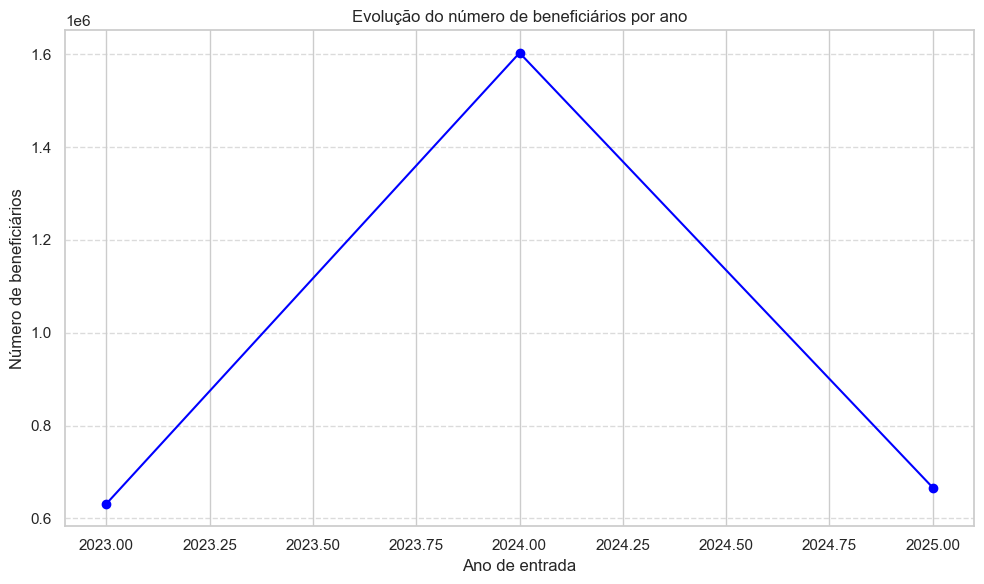

In [141]:
# Evolução do número de beneficiários dos últimos anos 

# Extrair o ano da data de entrada
cid_paciente['ano_entrada'] = cid_paciente['dt_entrada'].dt.year

# Contar o número de entradas por ano
benef_por_ano = cid_paciente['ano_entrada'].value_counts().sort_index()

# Plotar
plt.figure(figsize=(10, 6))
benef_por_ano.plot(kind='line', marker='o', color='blue')
plt.title('Evolução do número de beneficiários por ano')
plt.xlabel('Ano de entrada')
plt.ylabel('Número de beneficiários')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

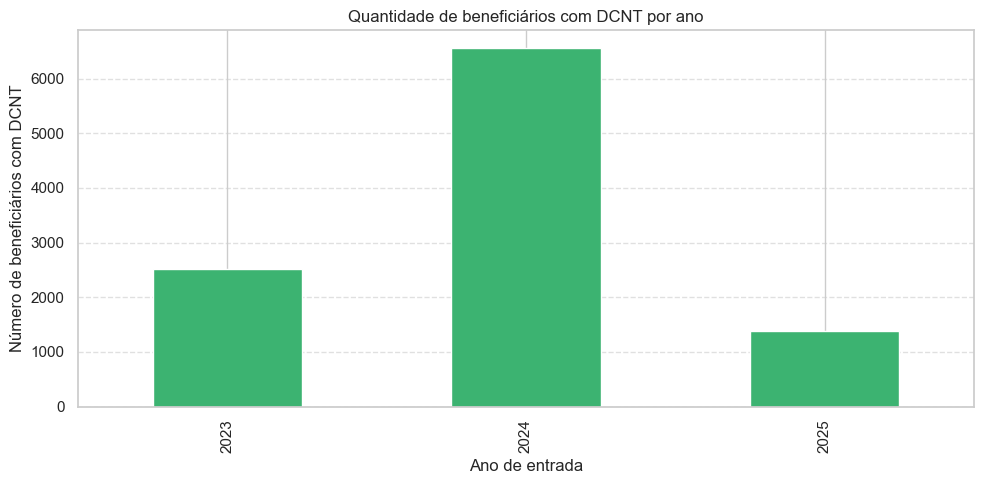

In [142]:
# Quantidade de beneficiários nos últimos que apresentam pelo menos uma DCNT
# Garante o formato datetime
cid_atendimento['dt_entrada'] = pd.to_datetime(cid_atendimento['dt_entrada'])

# Extrai o ano
cid_atendimento['ano_entrada'] = cid_atendimento['dt_entrada'].dt.year

# Filtra beneficiários com DCNT (ds_cid preenchido)
cid_atendimento_dcnt = cid_atendimento[cid_atendimento['cd_doenca'].notnull()].copy()

# Conta beneficiários com DCNT por ano
dcnt_por_ano = cid_atendimento_dcnt['ano_entrada'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
dcnt_por_ano.plot(kind='bar', color='mediumseagreen')
plt.title('Quantidade de beneficiários com DCNT por ano')
plt.xlabel('Ano de entrada')
plt.ylabel('Número de beneficiários com DCNT')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Tempo médio de atendimento (em dias): 1.71


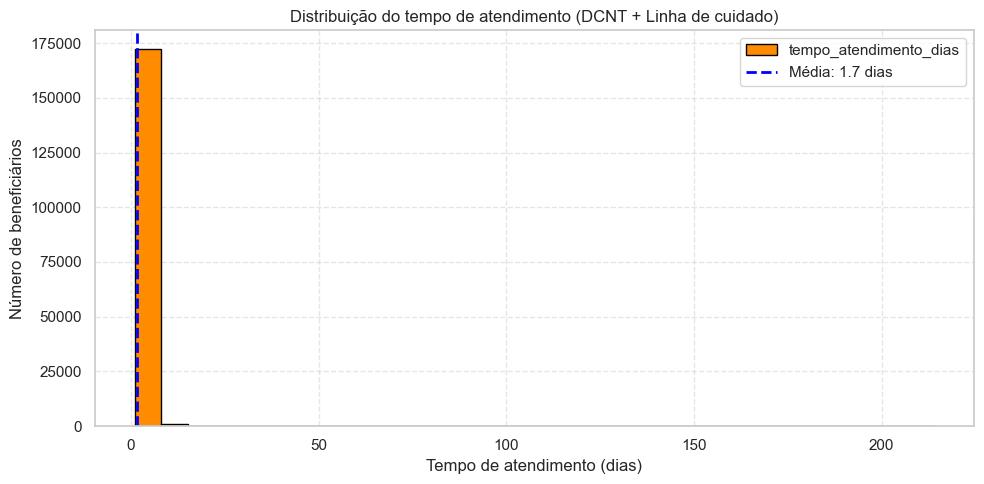

In [143]:
# Tempo médio de atendimento de beneficiários já diagnosticados com DCNT e que já fazem parte do programa de
# cuidados da UNIMED

# Garante que datas sejam datetime
cid_paciente['dt_entrada'] = pd.to_datetime(cid_paciente['dt_entrada'])
cid_paciente['dt_alta'] = pd.to_datetime(cid_paciente['dt_alta'])

# Filtro: pacientes com DCNT e linha de cuidado preenchida
cid_paciente_dcnt_linhacuidado = cid_paciente[cid_paciente['ds_cid'].notnull() & cid_paciente['ds_linha_cuidado'].notnull()].copy()

# Tempo de atendimento
cid_paciente_dcnt_linhacuidado['tempo_atendimento_dias'] = (
    cid_paciente_dcnt_linhacuidado['dt_alta'] - cid_paciente_dcnt_linhacuidado['dt_entrada']
).dt.days

# Remove casos negativos ou inválidos
cid_paciente_dcnt_linhacuidado = cid_paciente_dcnt_linhacuidado[cid_paciente_dcnt_linhacuidado['tempo_atendimento_dias'] > 0]

# Média
tempo_medio = cid_paciente_dcnt_linhacuidado['tempo_atendimento_dias'].mean()

print(f"Tempo médio de atendimento (em dias): {tempo_medio:.2f}")

# Plotando
plt.figure(figsize=(10, 5))
cid_paciente_dcnt_linhacuidado['tempo_atendimento_dias'].plot(kind='hist', bins=30, color='darkorange', edgecolor='black')
plt.axvline(tempo_medio, color='blue', linestyle='--', linewidth=2, label=f'Média: {tempo_medio:.1f} dias')
plt.title('Distribuição do tempo de atendimento (DCNT + Linha de cuidado)')
plt.xlabel('Tempo de atendimento (dias)')
plt.ylabel('Número de beneficiários')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

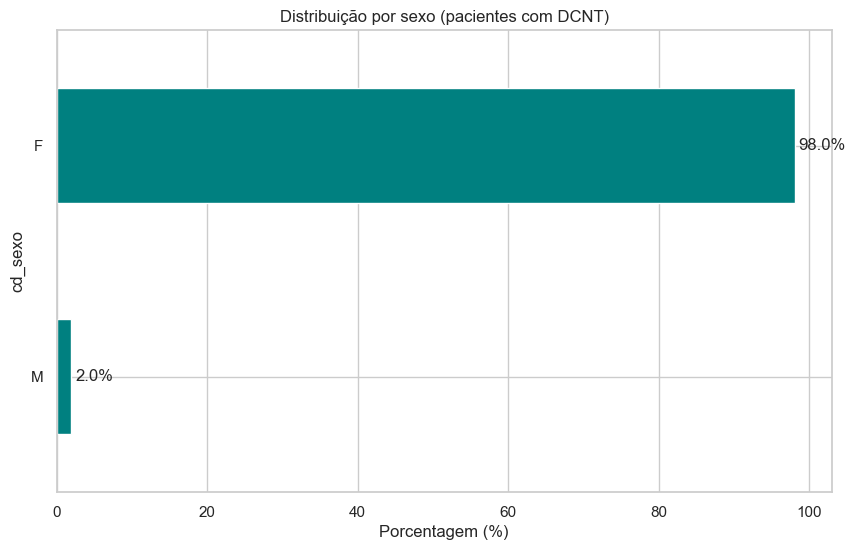

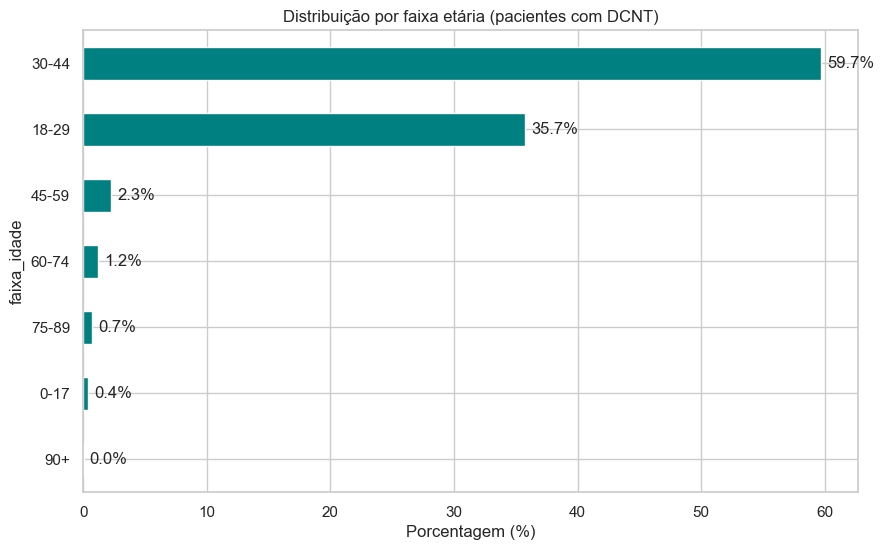

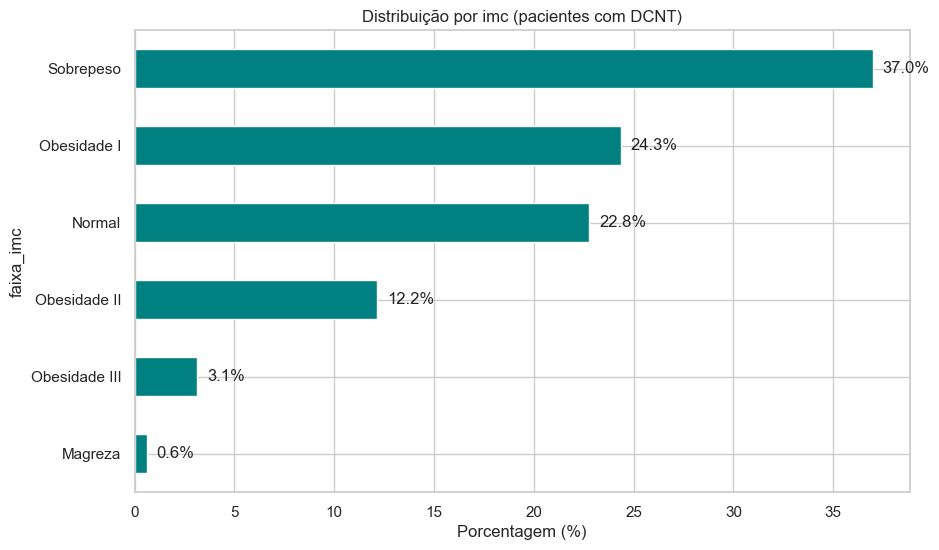

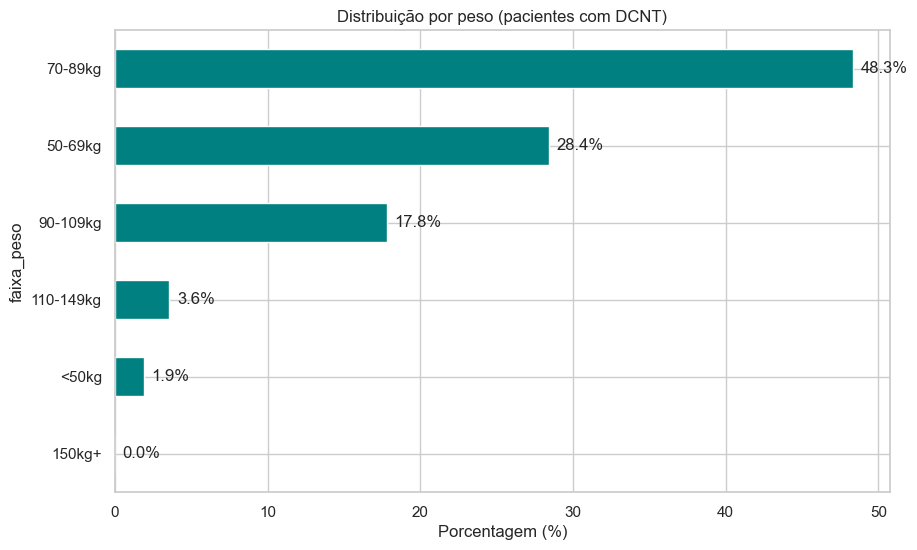

In [144]:
# Apresentar, em porcentagem, as principais características apresentandas por pacientes com DCNT 
# Filtra pacientes com DCNT
cid_paciente_dcnt = cid_paciente[cid_paciente['ds_cid'].notnull()].copy()

# Função para gráfico em porcentagem
def plot_porcentagem(coluna, titulo, top_n=None):
    proporcao = cid_paciente_dcnt[coluna].value_counts(normalize=True) * 100
    if top_n:
        proporcao = proporcao.head(top_n)

    plt.figure(figsize=(10, 6))
    proporcao.sort_values().plot(kind='barh', color='teal')
    plt.title(titulo)
    plt.xlabel('Porcentagem (%)')
    for i, v in enumerate(proporcao.sort_values()):
        plt.text(v + 0.5, i, f"{v:.1f}%", va='center')
    plt.show()

# Faixas de idade
bins_idade = [0, 18, 30, 45, 60, 75, 90, 120]
labels_idade = ['0-17', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']
cid_paciente_dcnt['faixa_idade'] = pd.cut(cid_paciente_dcnt['qt_idade'], bins=bins_idade, labels=labels_idade, right=False)

# Faixas de IMC (classificação da OMS)
bins_imc = [0, 18.5, 24.9, 29.9, 34.9, 39.9, 100]
labels_imc = ['Magreza', 'Normal', 'Sobrepeso', 'Obesidade I', 'Obesidade II', 'Obesidade III']
cid_paciente_dcnt['faixa_imc'] = pd.cut(cid_paciente_dcnt['qt_imc'], bins=bins_imc, labels=labels_imc, right=False)

# Faixas de peso (exemplo ajustável conforme o seu público)
bins_peso = [0, 50, 70, 90, 110, 150, 300]
labels_peso = ['<50kg', '50-69kg', '70-89kg', '90-109kg', '110-149kg', '150kg+']
cid_paciente_dcnt['faixa_peso'] = pd.cut(cid_paciente_dcnt['qt_peso'], bins=bins_peso, labels=labels_peso, right=False)
# Características
plot_porcentagem('cd_sexo', 'Distribuição por sexo (pacientes com DCNT)')
plot_porcentagem('faixa_idade', 'Distribuição por faixa etária (pacientes com DCNT)')
plot_porcentagem('faixa_imc', 'Distribuição por imc (pacientes com DCNT)')
plot_porcentagem('faixa_peso', 'Distribuição por peso (pacientes com DCNT)')

## Extrair mais 3 principais informações da base e elaborem os gráficos para visualizá-las. Cada código em uma célula separada

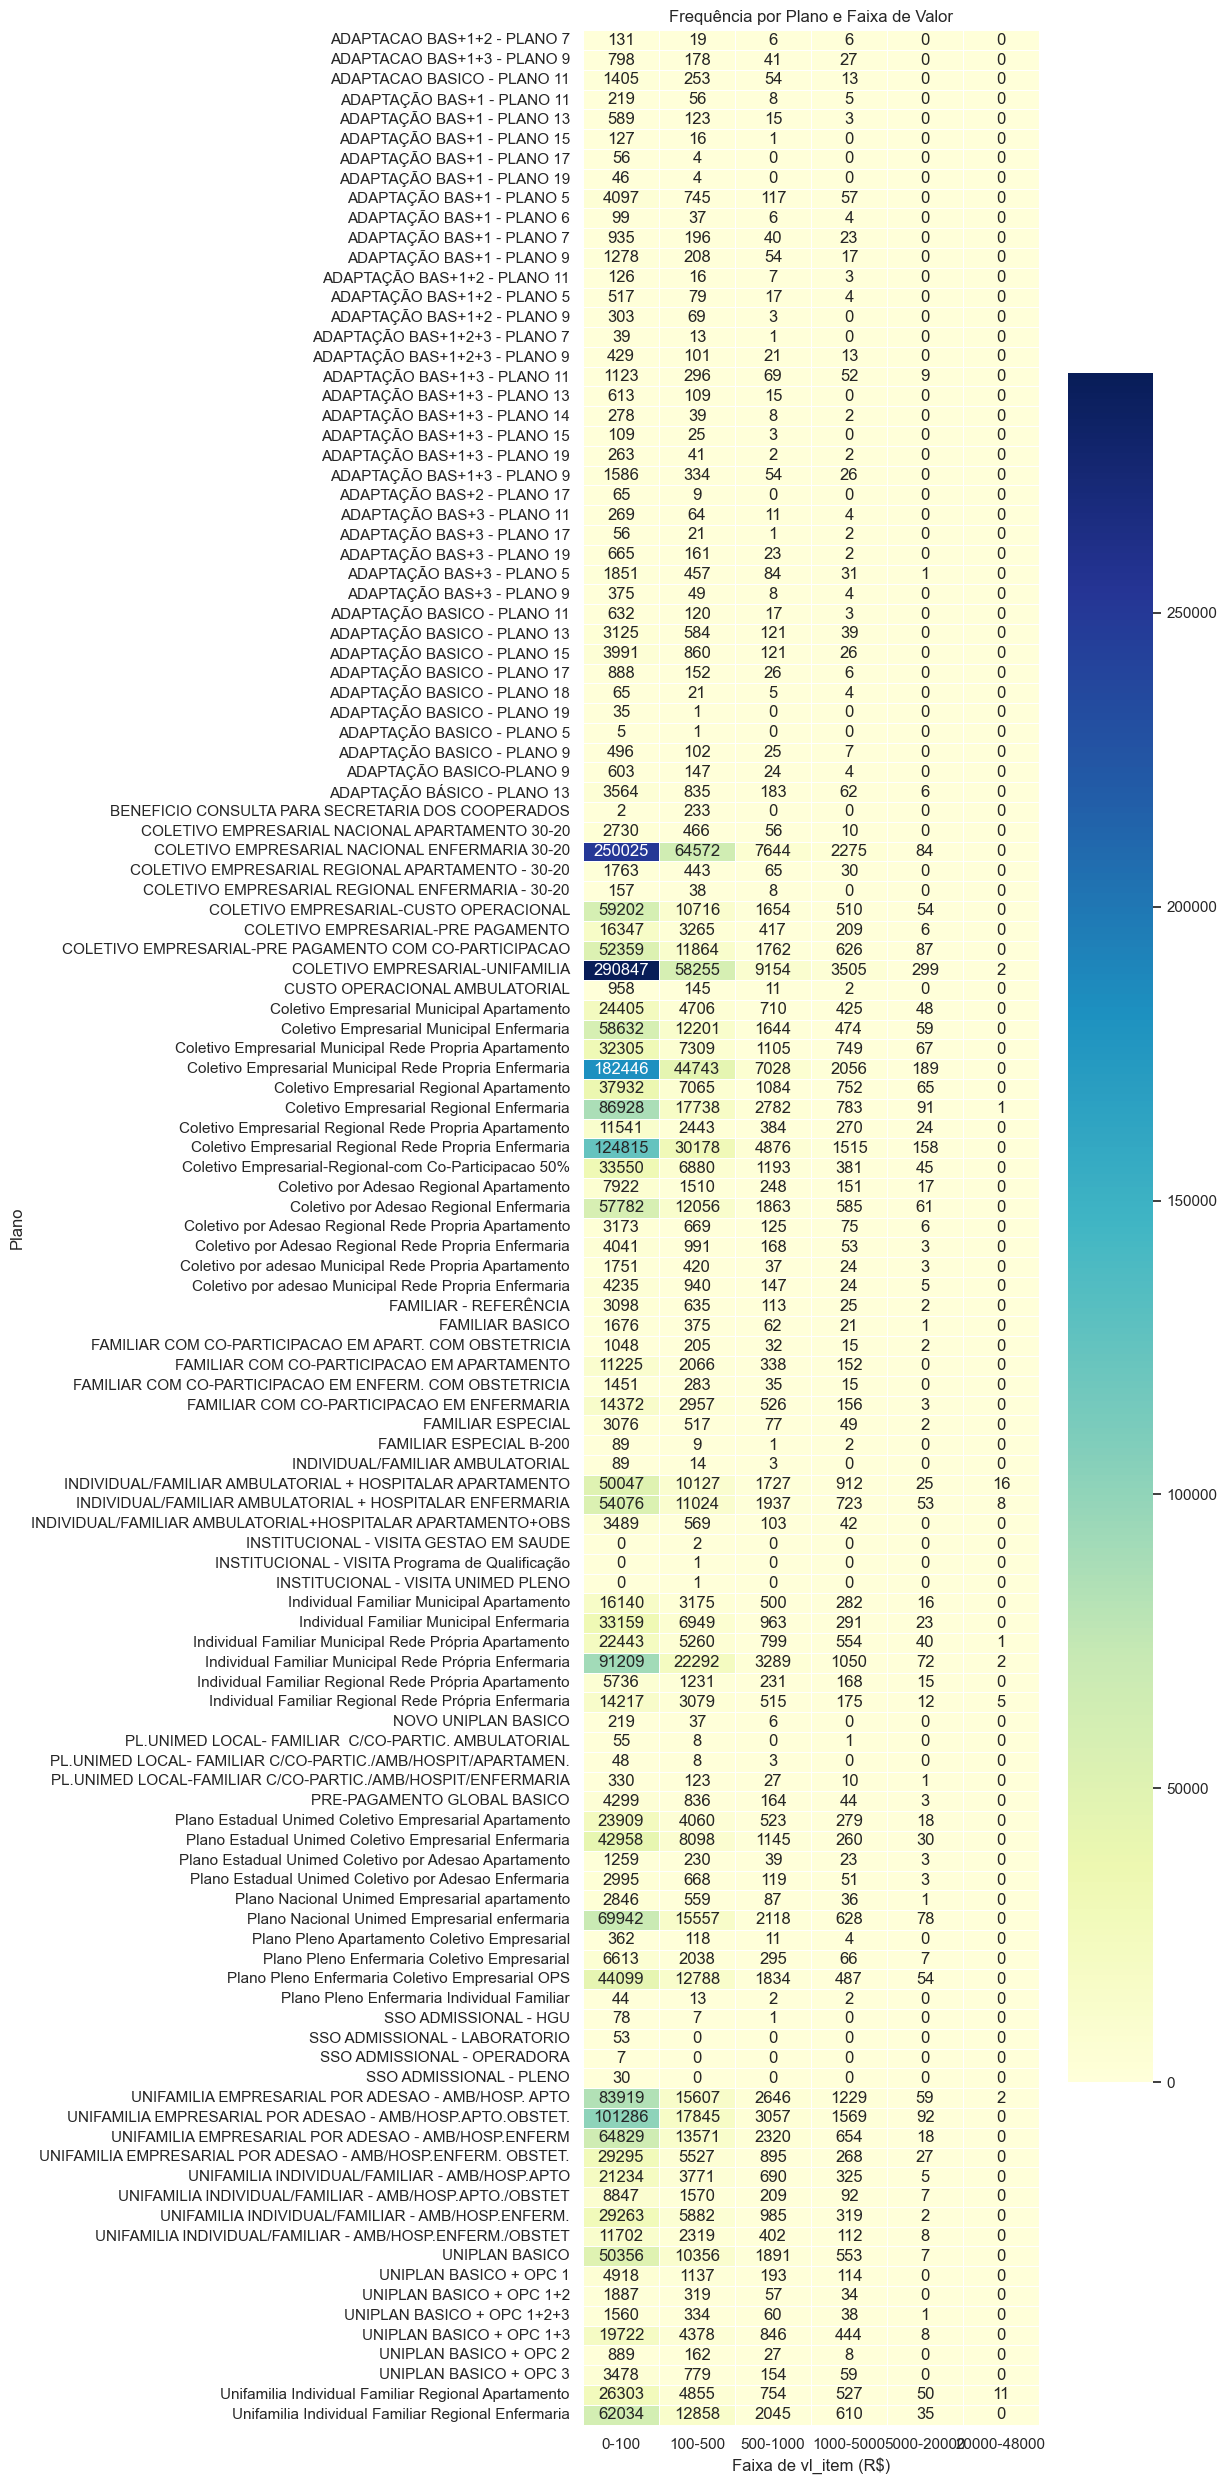

In [145]:
#gasto em relação ao plano 	
crosstab = pd.crosstab(custo_beneficiario['ds_plano'], custo_beneficiario['vl_item'])

# Define as faixas (você pode ajustar os limites conforme seus dados)
bins = [0, 100, 500, 1000, 5000, 20000, 48000]
labels = ['0-100', '100-500', '500-1000', '1000-5000', '5000-20000', '20000-48000']

# Cria a coluna com as faixas
custo_beneficiario['faixa_vl_item'] = pd.cut(custo_beneficiario['vl_item'], bins=bins, labels=labels, include_lowest=True)

# Crosstab entre plano e faixa de valor
crosstab = pd.crosstab(custo_beneficiario['ds_plano'], custo_beneficiario['faixa_vl_item'])

# Heatmap
plt.figure(figsize=(12,25))
sns.heatmap(crosstab, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)

plt.title('Frequência por Plano e Faixa de Valor')
plt.xlabel('Faixa de vl_item (R$)')
plt.ylabel('Plano')
plt.tight_layout()
plt.show()

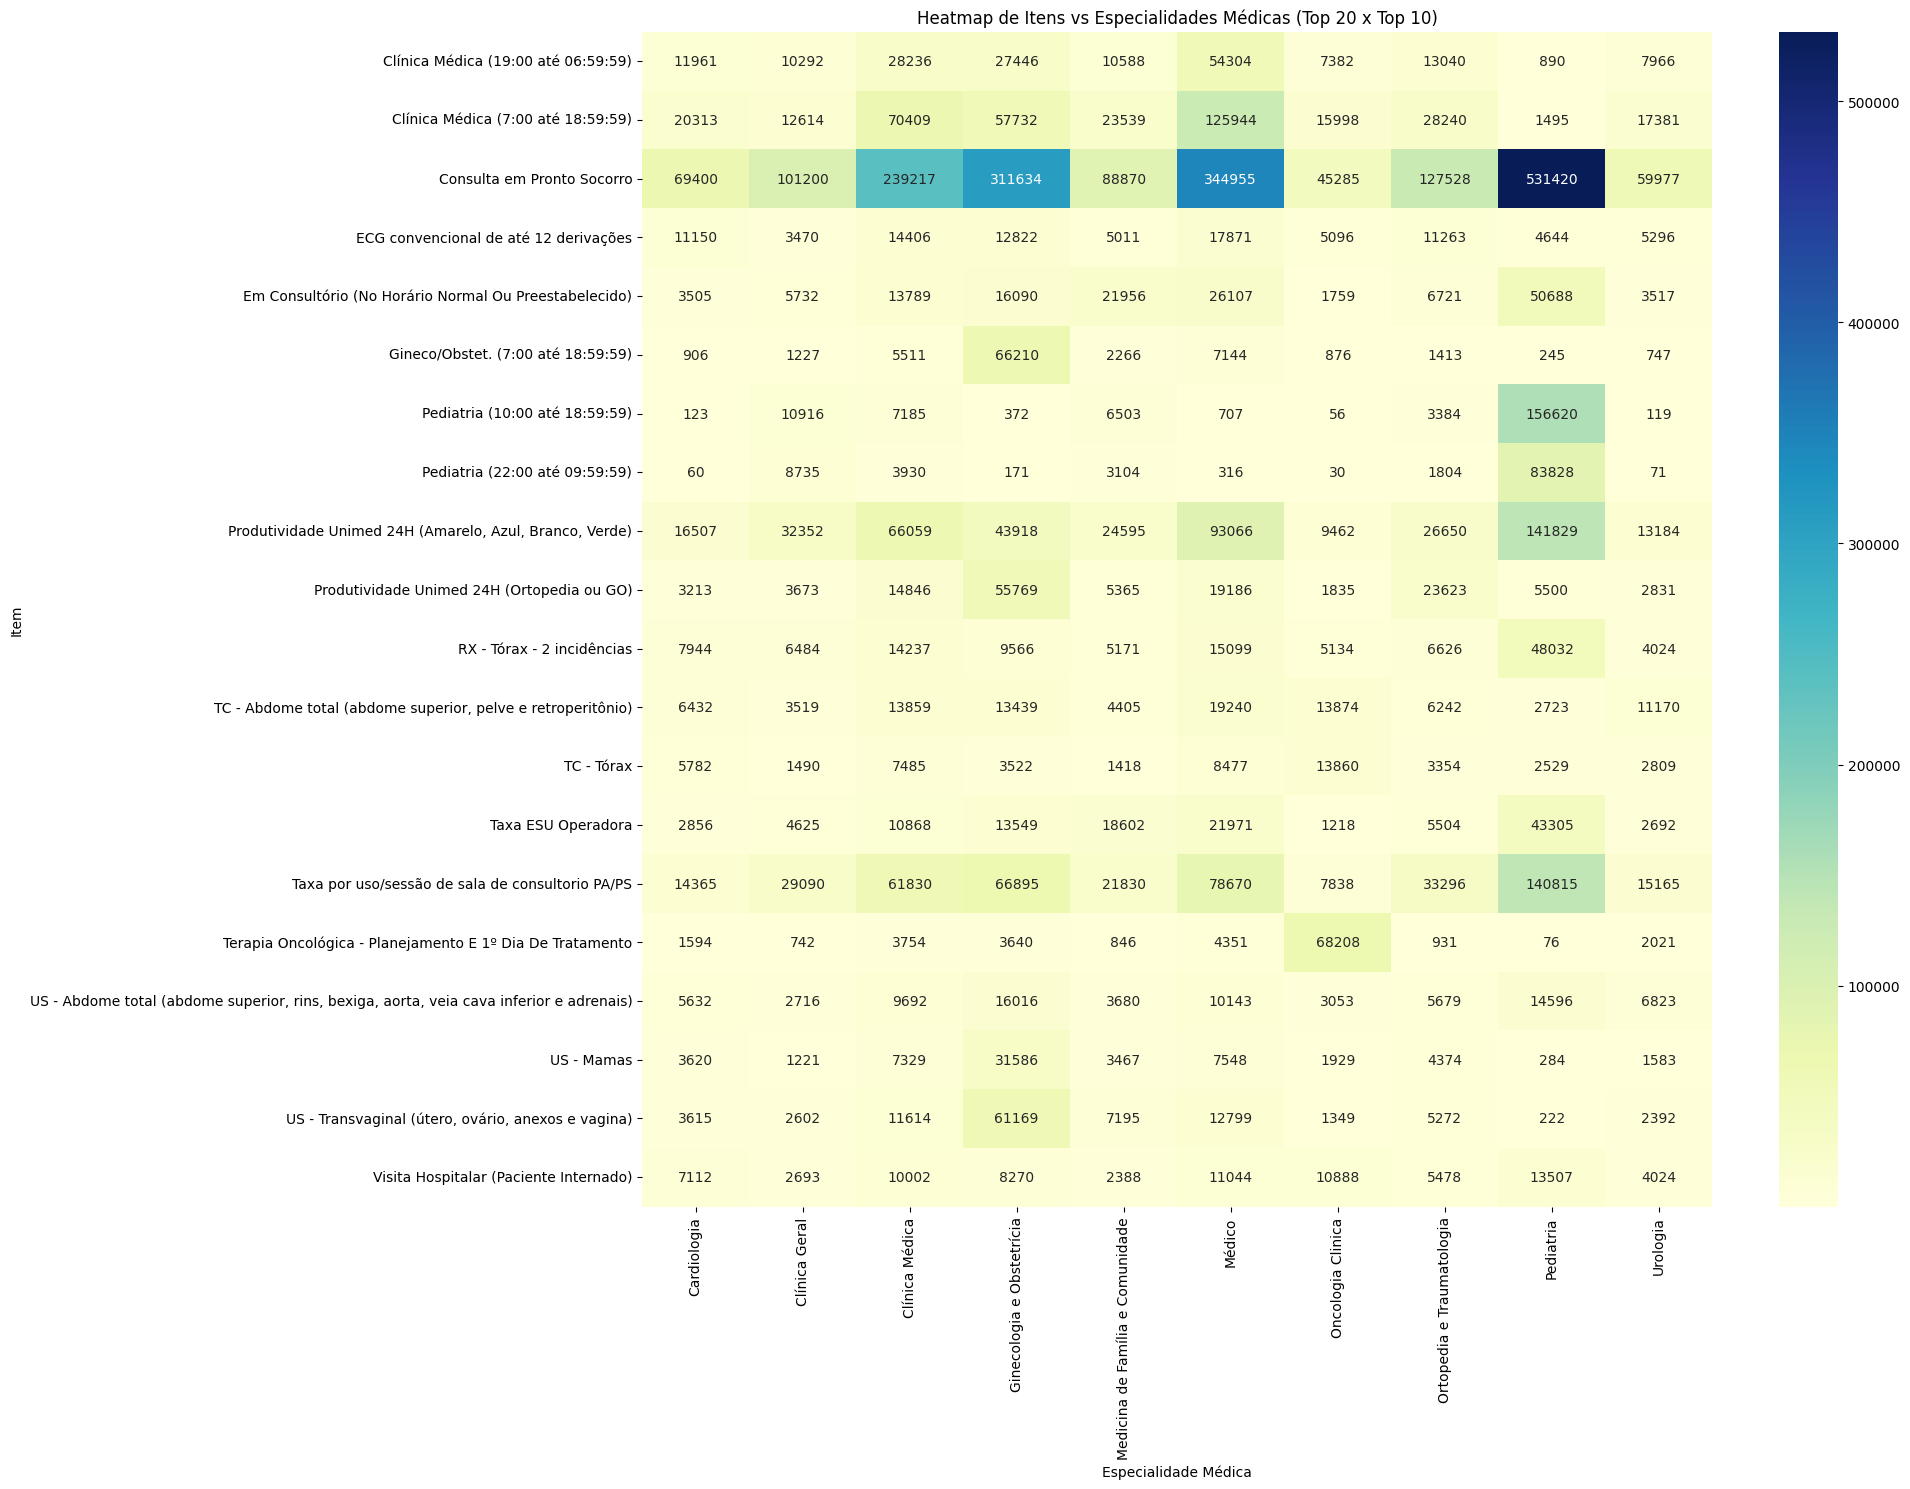

In [16]:
#Relacionamento entre item utilizado no hgu e medico que o paciente passou
crosstab = pd.crosstab(at_hgu['ds_item'], at_hgu['ds_especialidade_medico_responsavel'])

# Usar apenas os 20 principais itens e especialidades
top_items = at_hgu['ds_item'].value_counts().nlargest(20).index
top_especialidades = at_hgu['ds_especialidade_medico_responsavel'].value_counts().nlargest(10).index

heatmap_df = at_hgu[
    at_hgu['ds_item'].isin(top_items) & 
    at_hgu['ds_especialidade_medico_responsavel'].isin(top_especialidades)
]

ct = pd.crosstab(heatmap_df['ds_item'], heatmap_df['ds_especialidade_medico_responsavel'])

plt.figure(figsize=(20, 15))
sns.heatmap(ct, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Heatmap de Itens vs Especialidades Médicas (Top 20 x Top 10)')
plt.xlabel('Especialidade Médica')
plt.ylabel('Item')
plt.tight_layout()
plt.show()

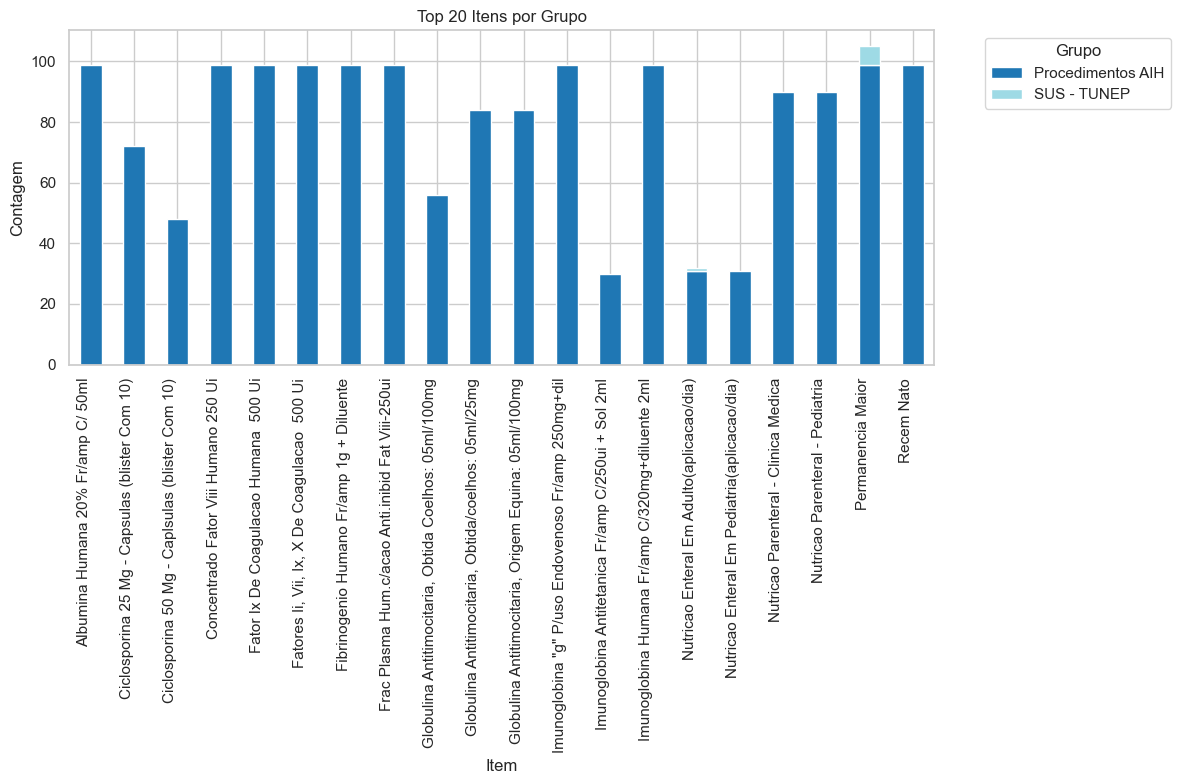

In [147]:
#Relacionamento de itens e grupos que os utilizam
# Filtra os 20 itens mais frequentes
top_items = df10u['ds_item'].value_counts().nlargest(20).index
filtered_df = df10u[df10u['ds_item'].isin(top_items)]

# Crosstab
ct = pd.crosstab(filtered_df['ds_item'], filtered_df['ds_grupo'])

# Plotar
ct.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Top 20 Itens por Grupo')
plt.xlabel('Item')
plt.ylabel('Contagem')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Grupo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
max_rows = 1048576
num_chunks = math.ceil(len(at_hgu) / max_rows)

with pd.ExcelWriter('at_hgu.xlsx') as writer:
    for i in range(num_chunks):
        start_row = i * max_rows
        end_row = (i + 1) * max_rows
        chunk = at_hgu.iloc[start_row:end_row].reset_index(drop=True)
        chunk.to_excel(writer, sheet_name=f'aba_{i+1}', index=False)

In [154]:
cid_atendimento.to_excel('cid_atendimento.xlsx', index=False)
lc_beneficiario.to_excel('lc_beneficiario.xlsx', index=False)
lc_cid.to_excel('lc_cid.xlsx', index=False)
beneficiario_hgu.to_excel('beneficiario_hgu.xlsx', index=False)
df9u.to_excel('procedimento_lc.xlsx', index=False)
df10u.to_excel('procedimentos.xlsx', index=False)